In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df.shape[0])
print("Número de variables: %d" % df.shape[1])
if df.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


In [3]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [4]:
process_cadastral(df)

In [5]:
df = df.dropna()

In [6]:
X = df.drop(columns=['CLASE']).copy()
y = df['CLASE'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train.merge(y_train, on='ID')
df_modelar_new = X_val.merge(y_val, on='ID')

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  87728
Tamaño del conjunto de nuevos datos:  15482


In [7]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

## Distancia al centro

In [8]:
center_x = df_modelar['X'].sum()/len(df_modelar['X'])
center_y = df_modelar['Y'].sum()/len(df_modelar['Y'])

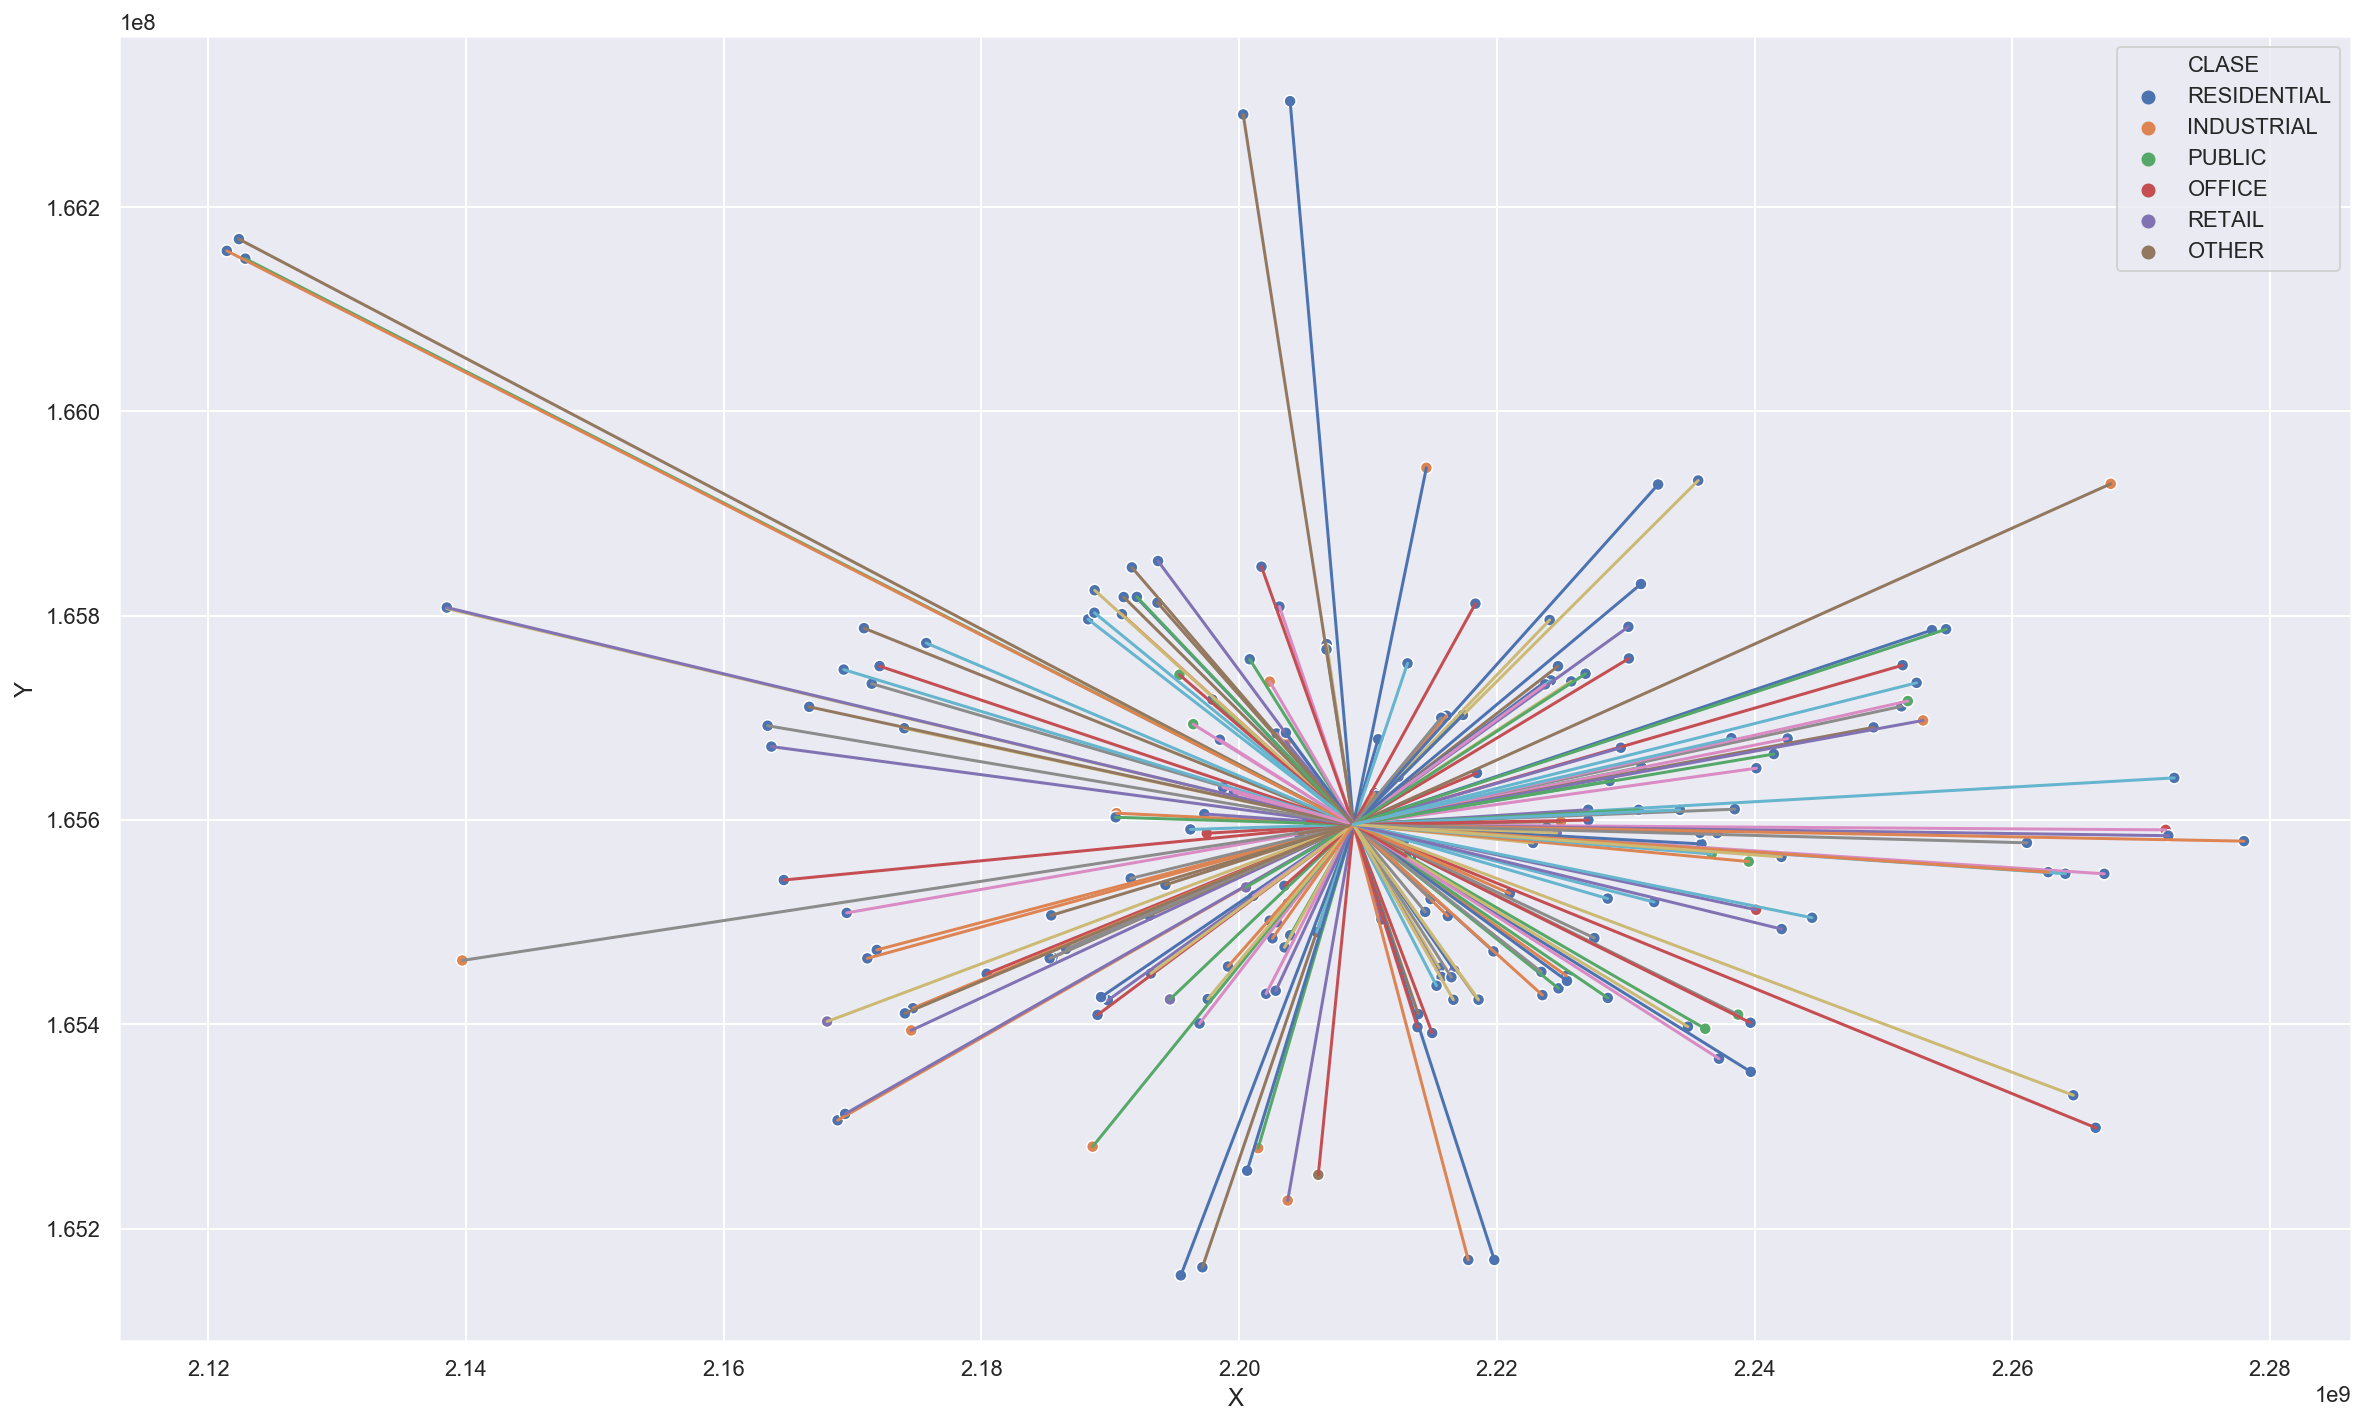

In [9]:
plt.figure(figsize=(20,12))
for i in range(200):
    point1 = [df_modelar.iloc[i]['X'], df_modelar.iloc[i]['Y']]
    point2 = [center_x, center_y]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values)
sns.scatterplot(df_modelar['X'][:200], df_modelar['Y'][:200], hue=df_modelar['CLASE'][:200])

In [10]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

In [11]:
df_modelar['distance_to_center'] = df_modelar.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)

In [12]:
df_modelar['distance_to_center'] = df_modelar['distance_to_center'] / df_modelar['distance_to_center'].max() #Normalizamos 0,1

In [13]:
df_modelar.groupby('CLASE')['distance_to_center'].mean()

CLASE
AGRICULTURE    0.348430
INDUSTRIAL     0.372862
OFFICE         0.183858
OTHER          0.213616
PUBLIC         0.226200
RESIDENTIAL    0.230438
RETAIL         0.230114
Name: distance_to_center, dtype: float64

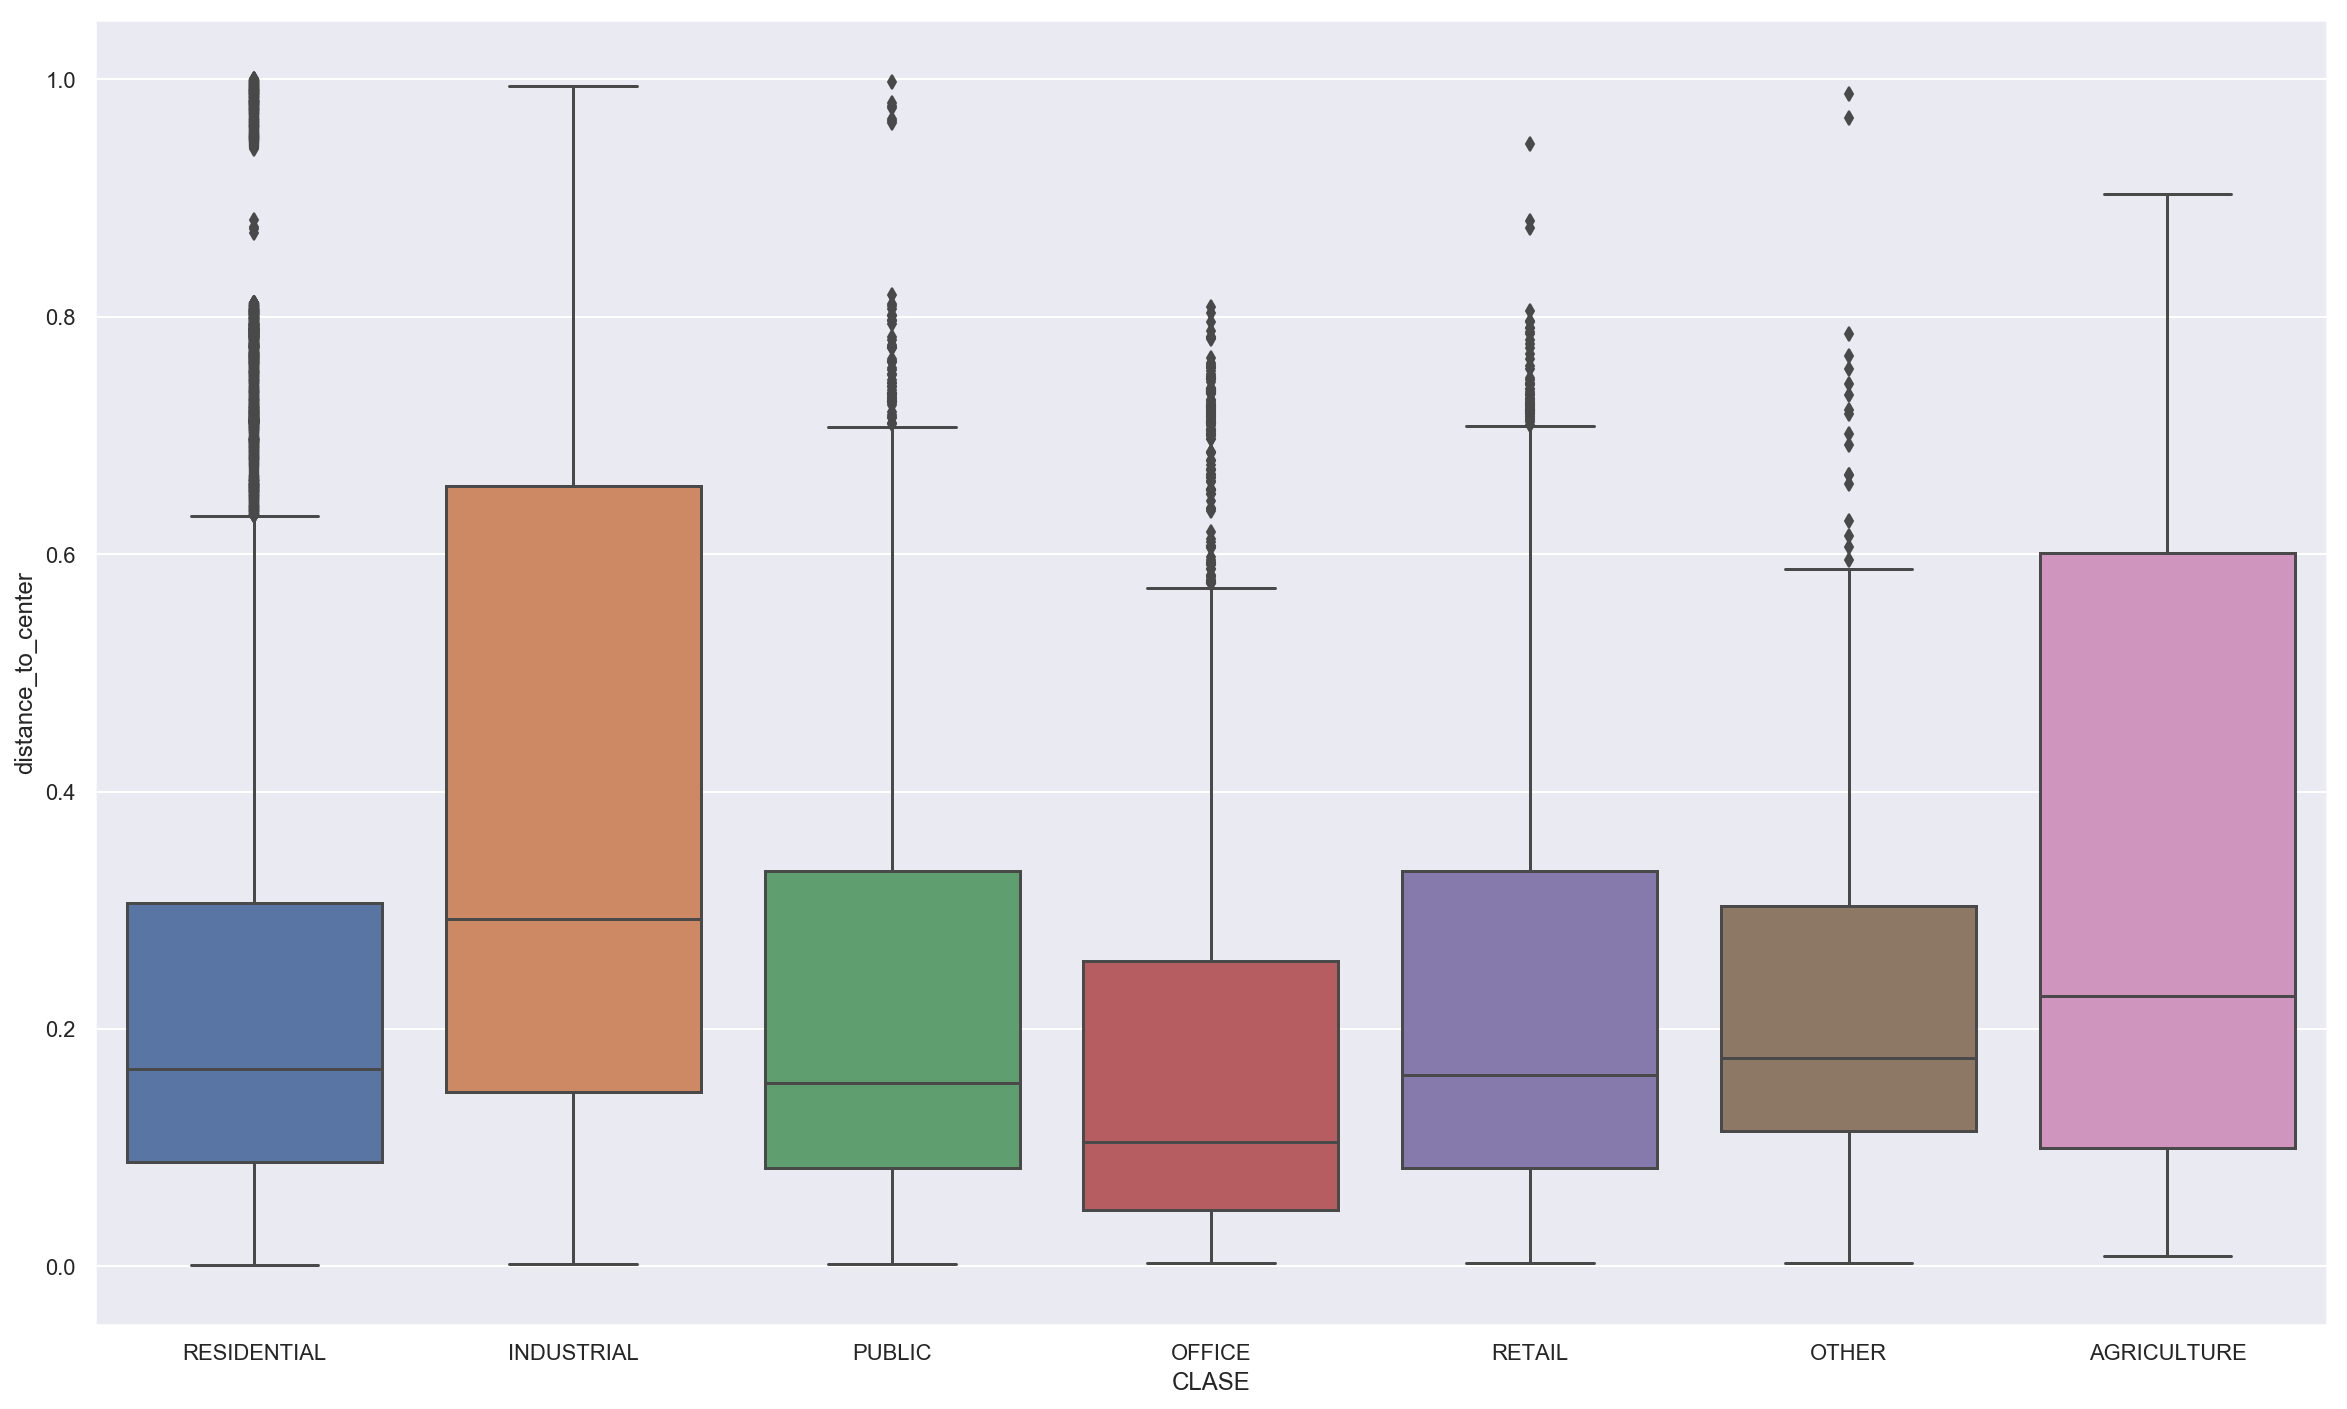

In [14]:
plt.figure(figsize=(20,12))
sns.boxplot(x="CLASE", y="distance_to_center", data=df_modelar)

## Densidad de vecinos

In [15]:
from sklearn.neighbors import KNeighborsClassifier

X = df_modelar[['X', 'Y']].copy()
y = df_modelar['CLASE'].copy()

w = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [124]:
#for n in range(1, 15):
#    neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
#    neigh.fit(X, y)
#    predictKNN = neigh.predict(X_test)
#    w.append(accuracy_score(y_test, predictKNN))             

In [125]:
#plt.figure(figsize=(12,6))
#plt.plot(range(1,15), w)
#plt.xlabel('K-neighbours')
#plt.ylabel('Accuracy');

Como podemos observar si elegiesemos k con valor a 1, estaríamos obteniendo un 1 de accuracy, es decir, no estaríamos fallando en la predicción. Dado que lo que nos interesa es conocer el entorno del registro, no nos vale con un k relativamente pequeño como puede ser 1 o 2. Sin embargo, para poder conocer mejor el entorno del registro a predecir, podemos observar que a partir del valor 5, dejamos de disminuir el accuracy, por lo que creemos que es un valor lo suficientemente representativo del entorno y no sacrificamos demasiado el accuracy. Lo que nos interesa con este proceso no es obtener una clasificación de 1 y no fallar, lo que nos interesa es obtener más registros alrededor de nuestra predicción que nos aporte información con respecto a la situación en la que está. Por ejemplo, si estuviese en el centro la probabilidad de los vecinos a que sean Residenciales serían de 1, mientra que si estuviese a las afueras quizás tendría 2 vecinos residenciales y 3 industriales. Por lo que ello, creemos que le puede aportar mayor información al modelo.

In [16]:
n = 5
neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [17]:
y_pred = neigh.predict(X_test)
y_prob = neigh.predict_proba(X_test)

In [18]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 AGRICULTURE       0.74      0.35      0.48        82
  INDUSTRIAL       0.74      0.51      0.60      1144
      OFFICE       0.54      0.14      0.22       466
       OTHER       0.57      0.06      0.11       340
      PUBLIC       0.60      0.09      0.16       759
 RESIDENTIAL       0.91      0.99      0.95     22995
      RETAIL       0.62      0.07      0.13       533

    accuracy                           0.90     26319
   macro avg       0.67      0.32      0.38     26319
weighted avg       0.87      0.90      0.87     26319



In [19]:
aux = pd.DataFrame(y_prob*n, columns=neigh.classes_, index=X_test.index)

In [20]:
aux_2 = X_test.merge(aux, on='ID', how='inner')

In [21]:
aux_2[neigh.classes_].sum()

AGRICULTURE       245.0
INDUSTRIAL       5238.0
OFFICE           2074.0
OTHER            1561.0
PUBLIC           3335.0
RESIDENTIAL    116525.0
RETAIL           2617.0
dtype: float64

In [132]:
#import pickle
#pickle.dump(neigh, open('./knn_CCG.model', 'wb'))

---

In [19]:
predict = neigh.predict_proba(df_modelar[['X', 'Y']])

In [20]:
aux = pd.DataFrame(predict*n, columns=[ 'N_'+c for c in neigh.classes_ ], index=df_modelar.index)
df_modelar = df_modelar.merge(aux, on='ID', how='inner')

In [21]:
#df_modelar[df_modelar['C_RESIDENTIAL'] == 0].head()

In [22]:
df_modelar.drop(columns=['X', 'Y'], inplace=True)

Correlaciones

In [23]:
df_modelar[df_modelar.columns[-7:]].corr().style.background_gradient(cmap='coolwarm')

Media de cada uno de los vecinos en función a su clase (Recordemos que el máximo es 5)

In [25]:
df_modelar.groupby('CLASE')[df_modelar.columns[-7:]].mean().style.background_gradient(cmap='coolwarm')

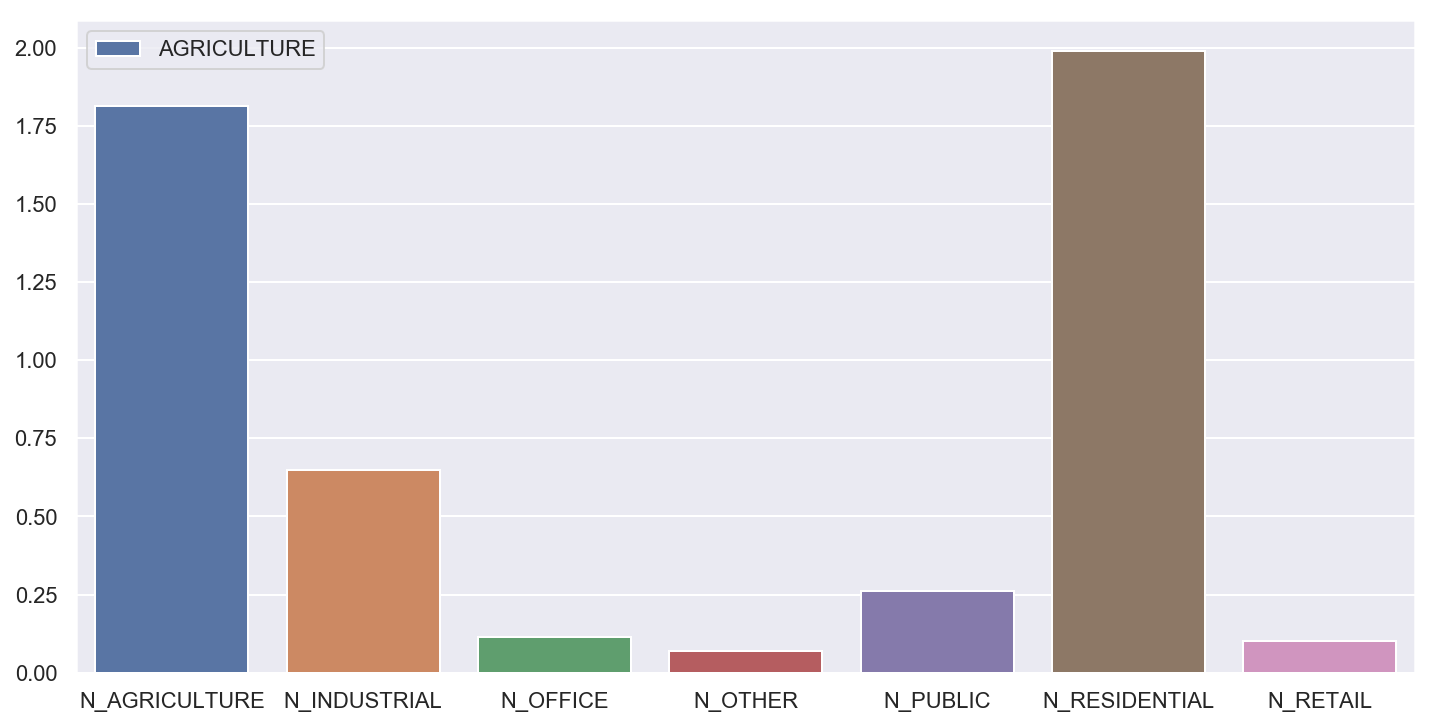

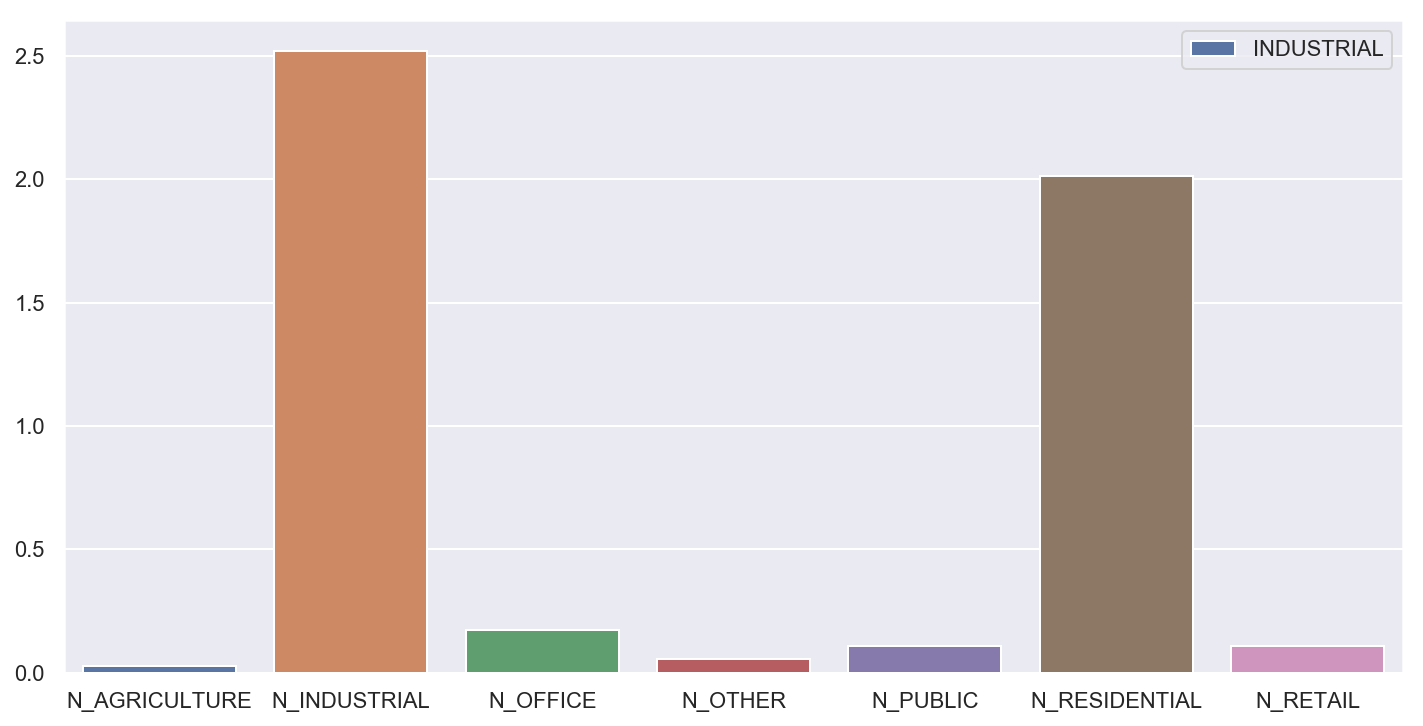

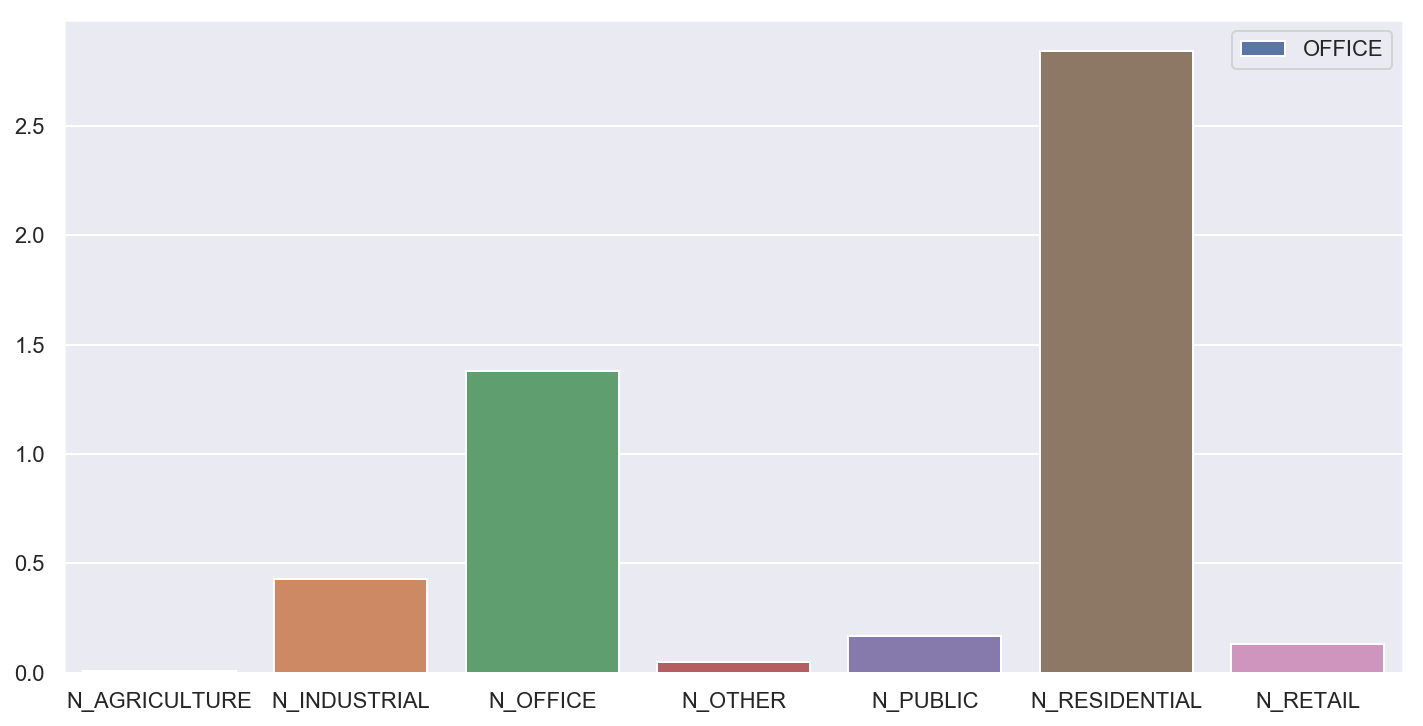

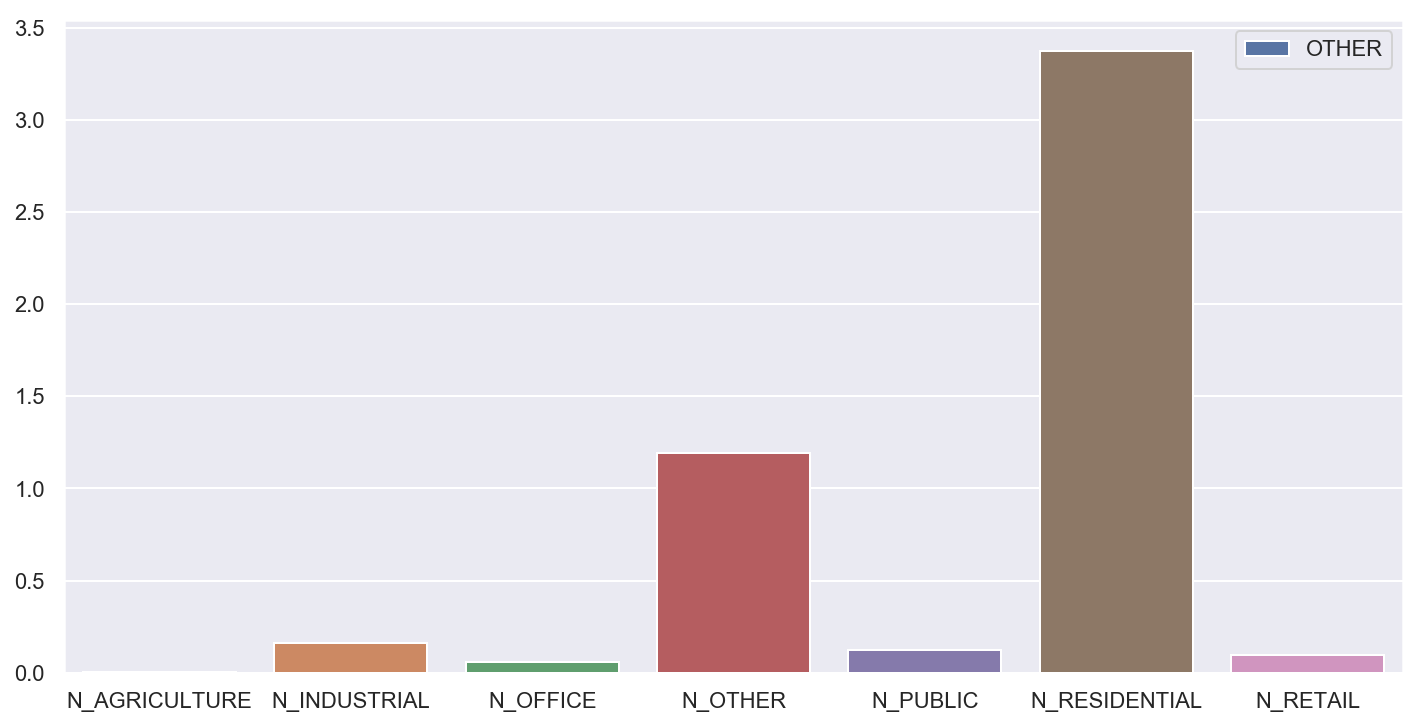

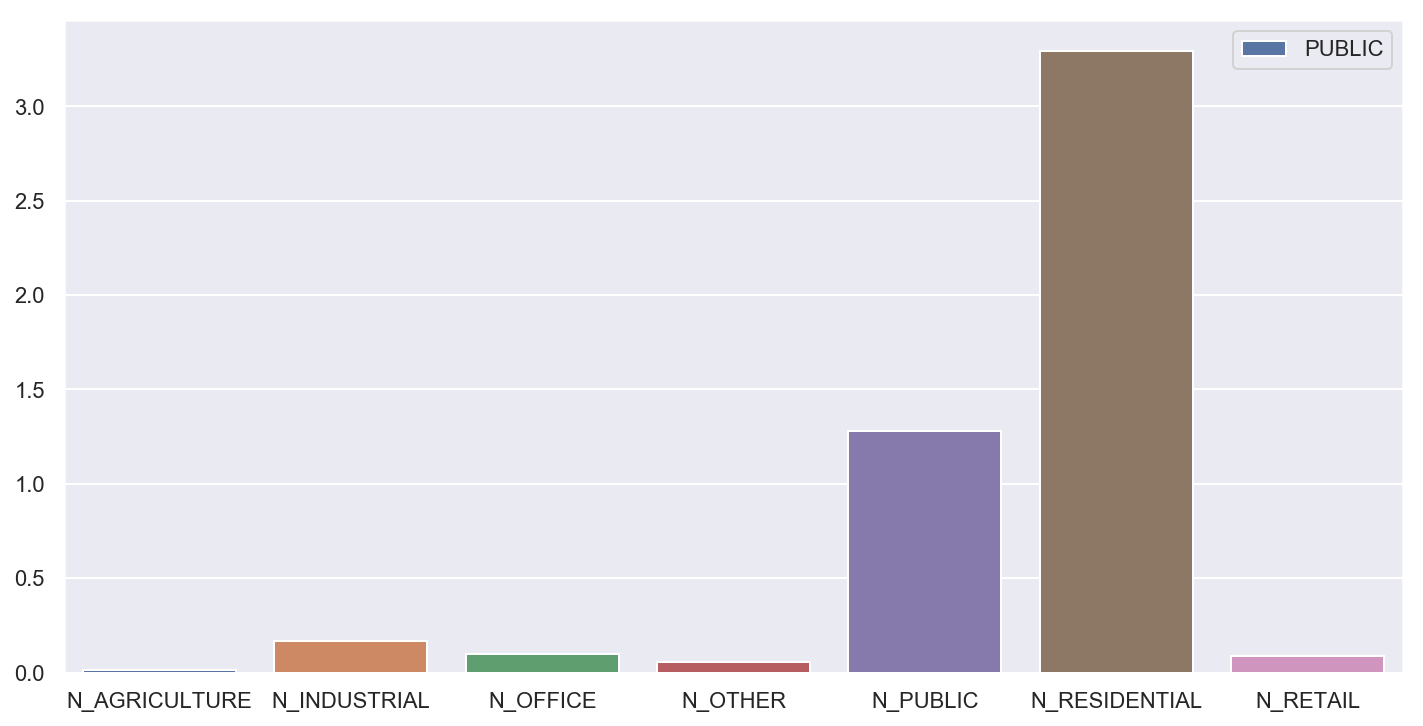

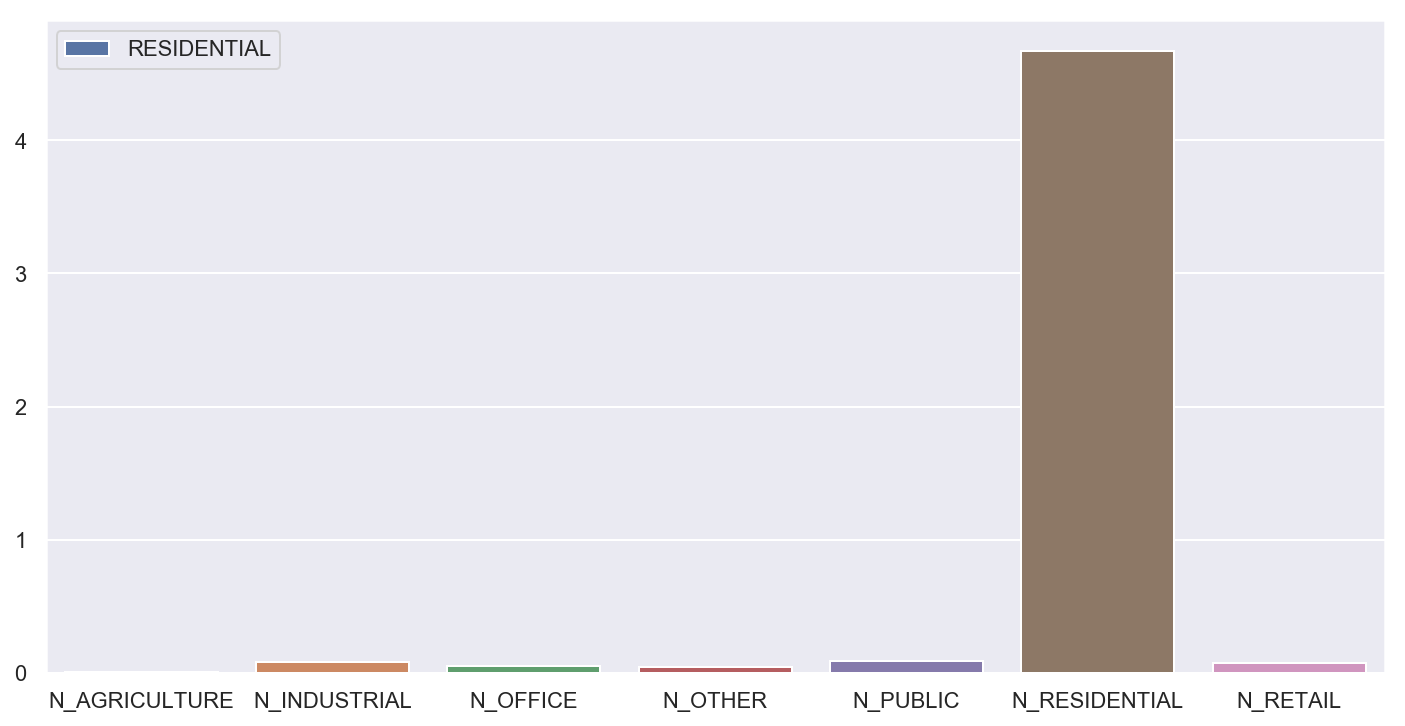

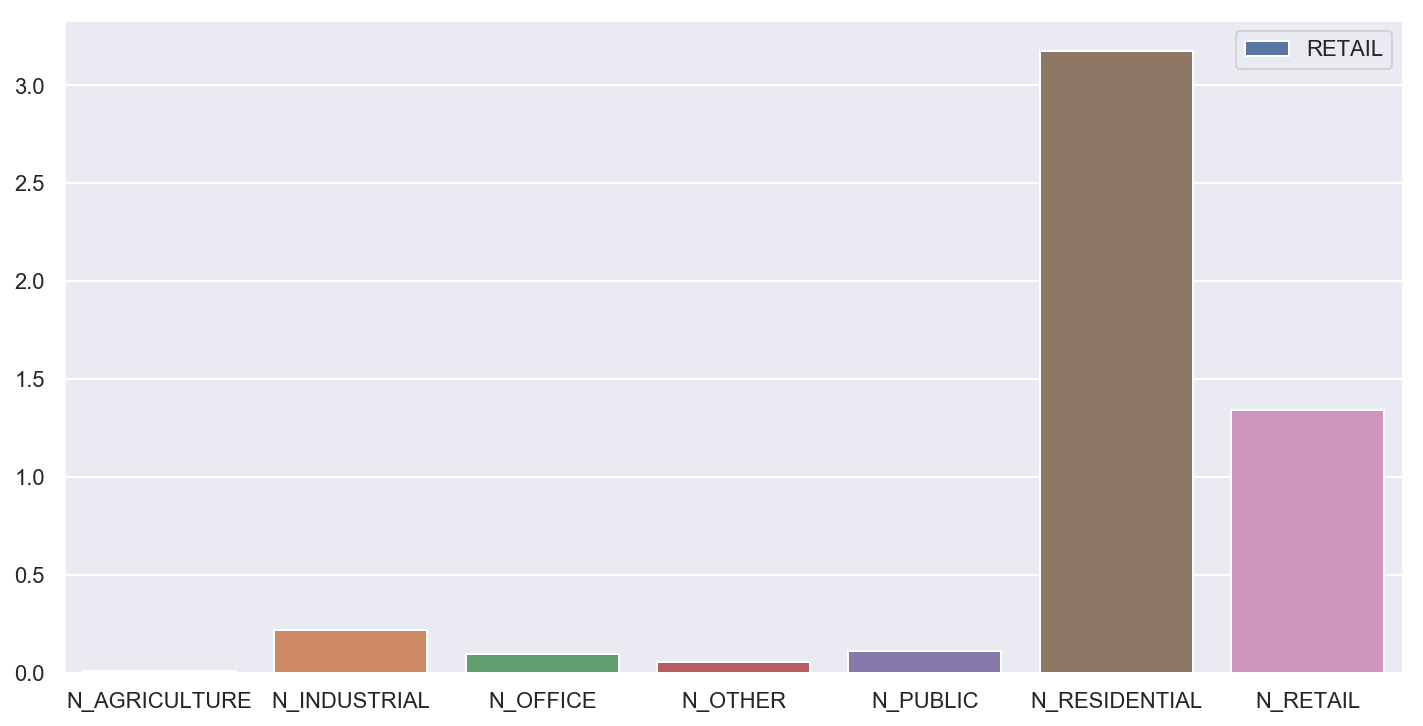

In [38]:
grouped = df_modelar.groupby('CLASE')[df_modelar.columns[-7:]]
for name, group in grouped:  
    values = group[df_modelar.columns[-7:]].mean()
    plt.figure(figsize=(12,6))
    sns.barplot(x=values.index, y =values.values, label=name)
    plt.legend()
    plt.show()

---

# Colores

In [40]:
df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].head()

Q_R_4_0_0   Q_R_4_0_1   Q_R_4_0_2   Q_R_4_0_3  \
ID                                                                   
ED9D46EC9089E51C  0.000000e+00  318.997910  492.003845  632.999634   
F9643836C56CEF97  3.225805e-10  386.998962  543.007788  656.000073   
55C034472ED68EAC  1.105847e-06  445.999637  634.001172  780.000568   
37BA5591BA9128AF  2.370434e-06  369.002548  509.001099  623.502045   
1F0DC2B421224578  0.000000e+00  357.997101  532.001343  655.999054   

                   Q_R_4_0_4    Q_R_4_0_5    Q_R_4_0_6    Q_R_4_0_7  \
ID                                                                    
ED9D46EC9089E51C  757.002197   882.999908  1019.008911  1175.993103   
F9643836C56CEF97  773.999634   895.998505  1029.996167  1209.001526   
55C034472ED68EAC  902.004053  1025.997009  1157.997681  1304.999585   
37BA5591BA9128AF  741.999512   865.006531   997.999084  1155.004517   
1F0DC2B421224578  770.997498   888.997162  1029.000488  1192.003174   

                    Q_R_4_0_8    Q_R_4_0_9    Q_R_4_1_0  
ID                                                       
ED9D46EC9089E51C  1401.000488  1756.994141  7376.529218  
F9643836C56CEF97  1448.995605  1837.001917  5925.849598  
55C034472ED68EAC  1501.002661  1830.998926  7098.504905  
37BA5591BA9128AF  1355.998047  1668.995605  5036.602827  
1F0DC2B421224578  1422.001099  1799.502014  6597.430375

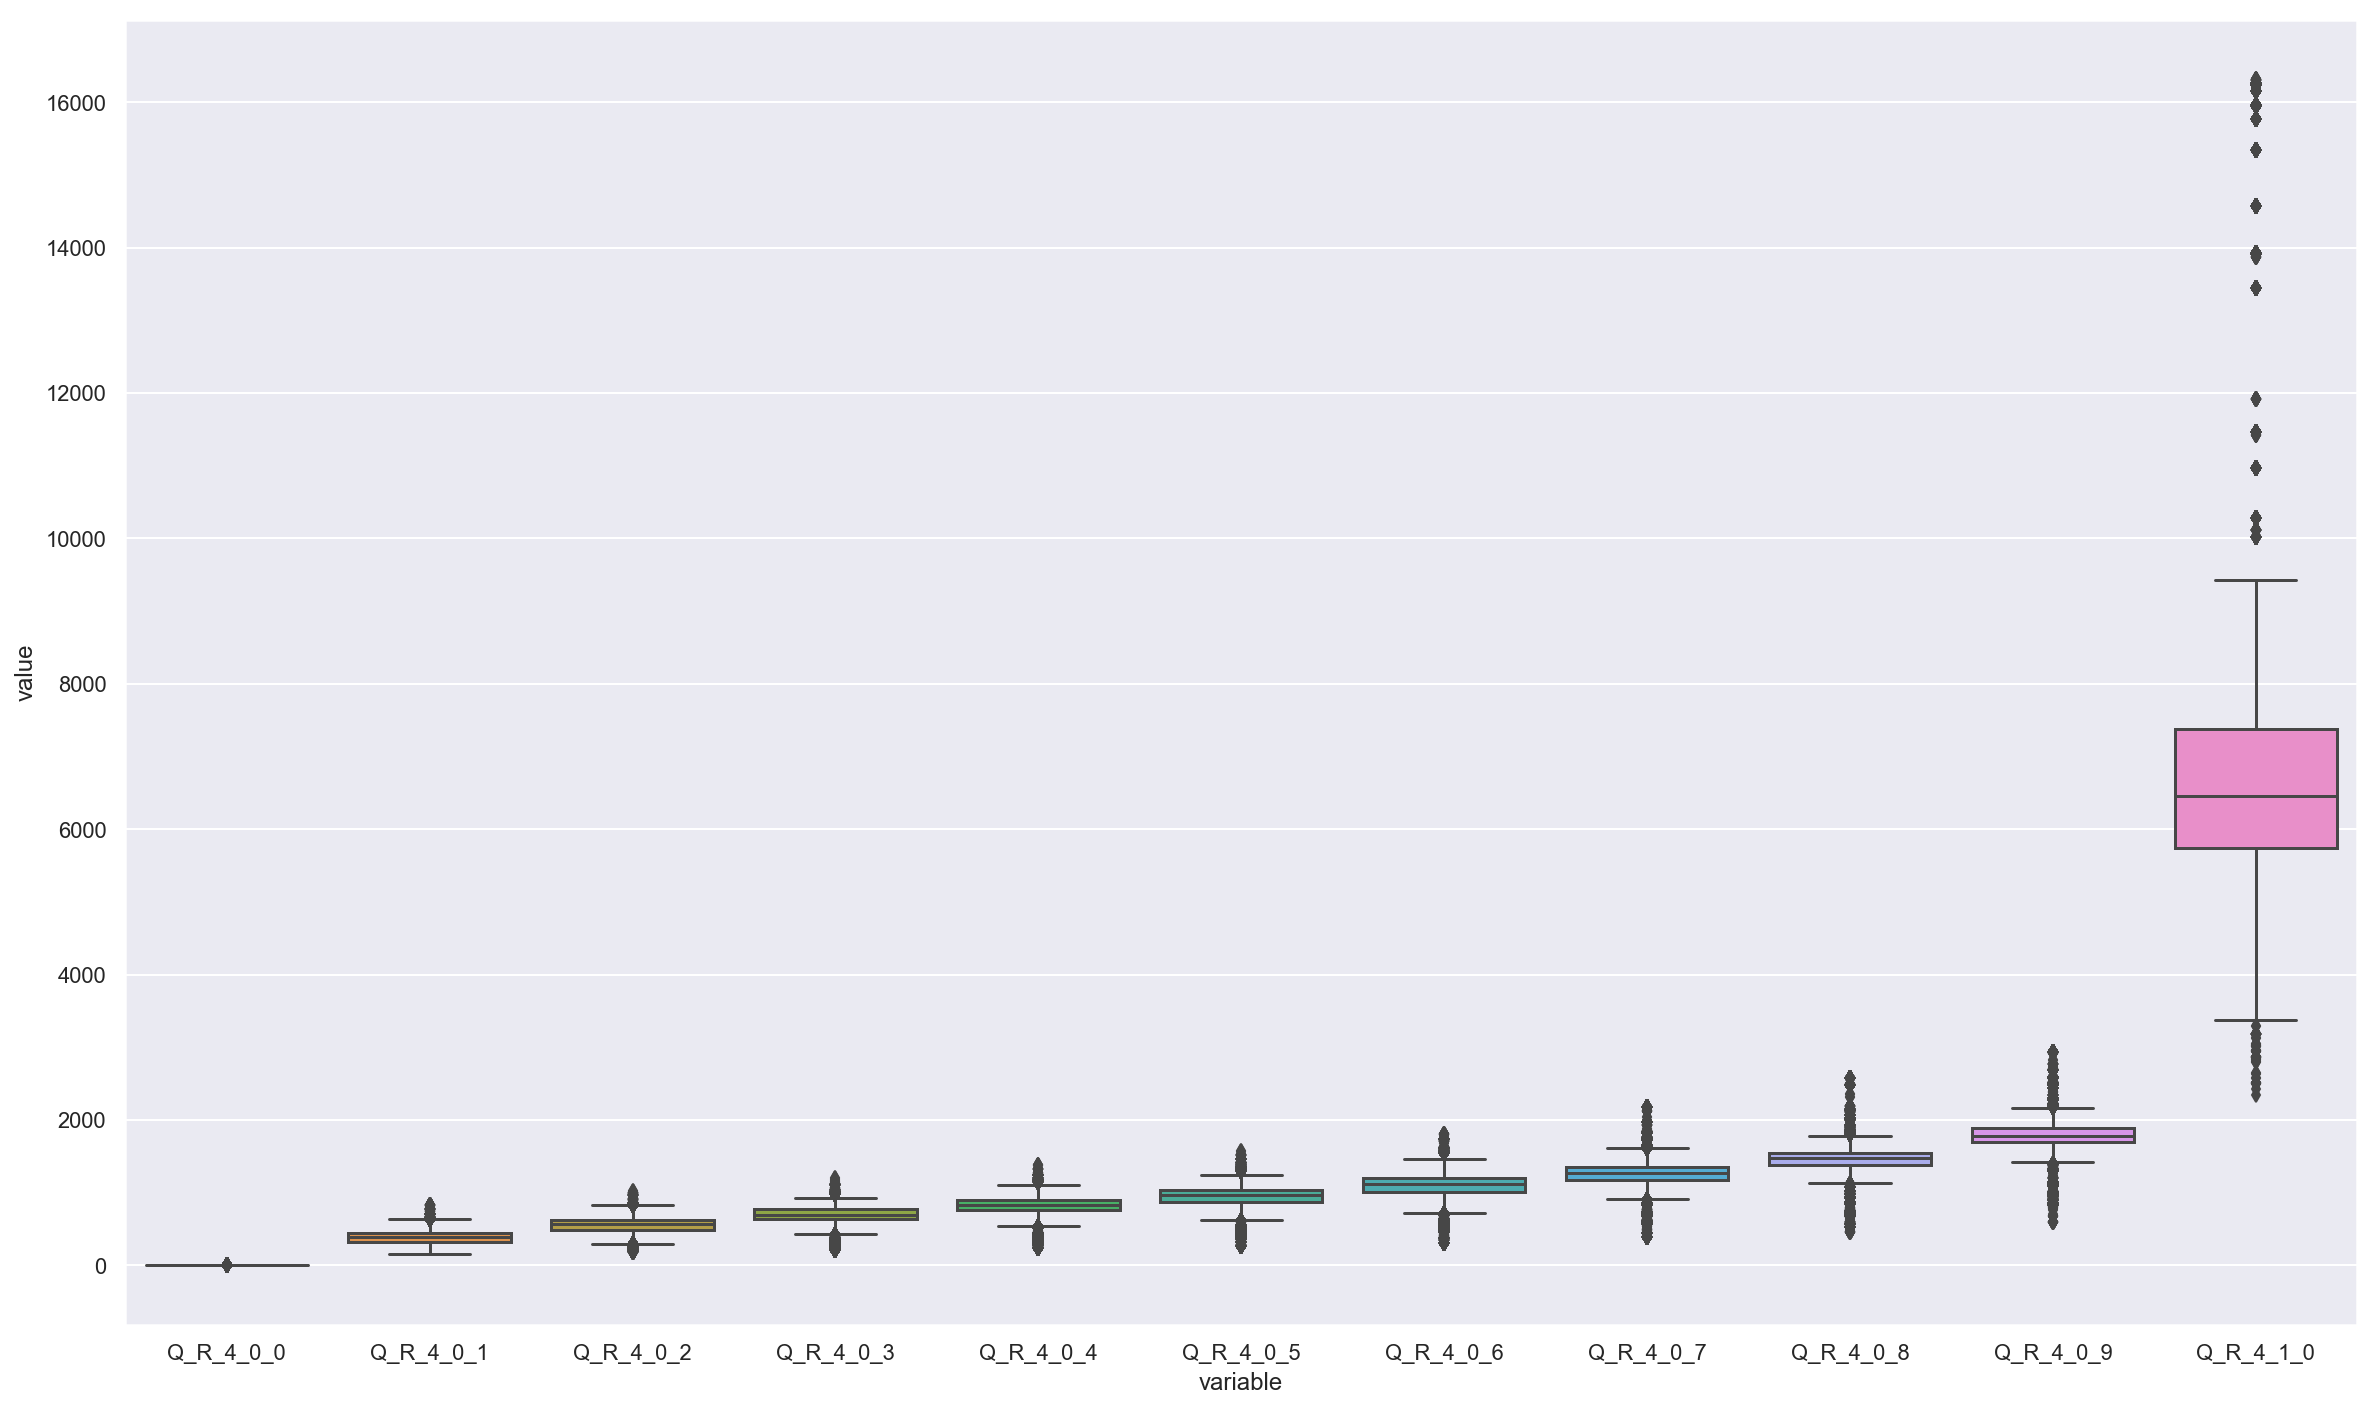

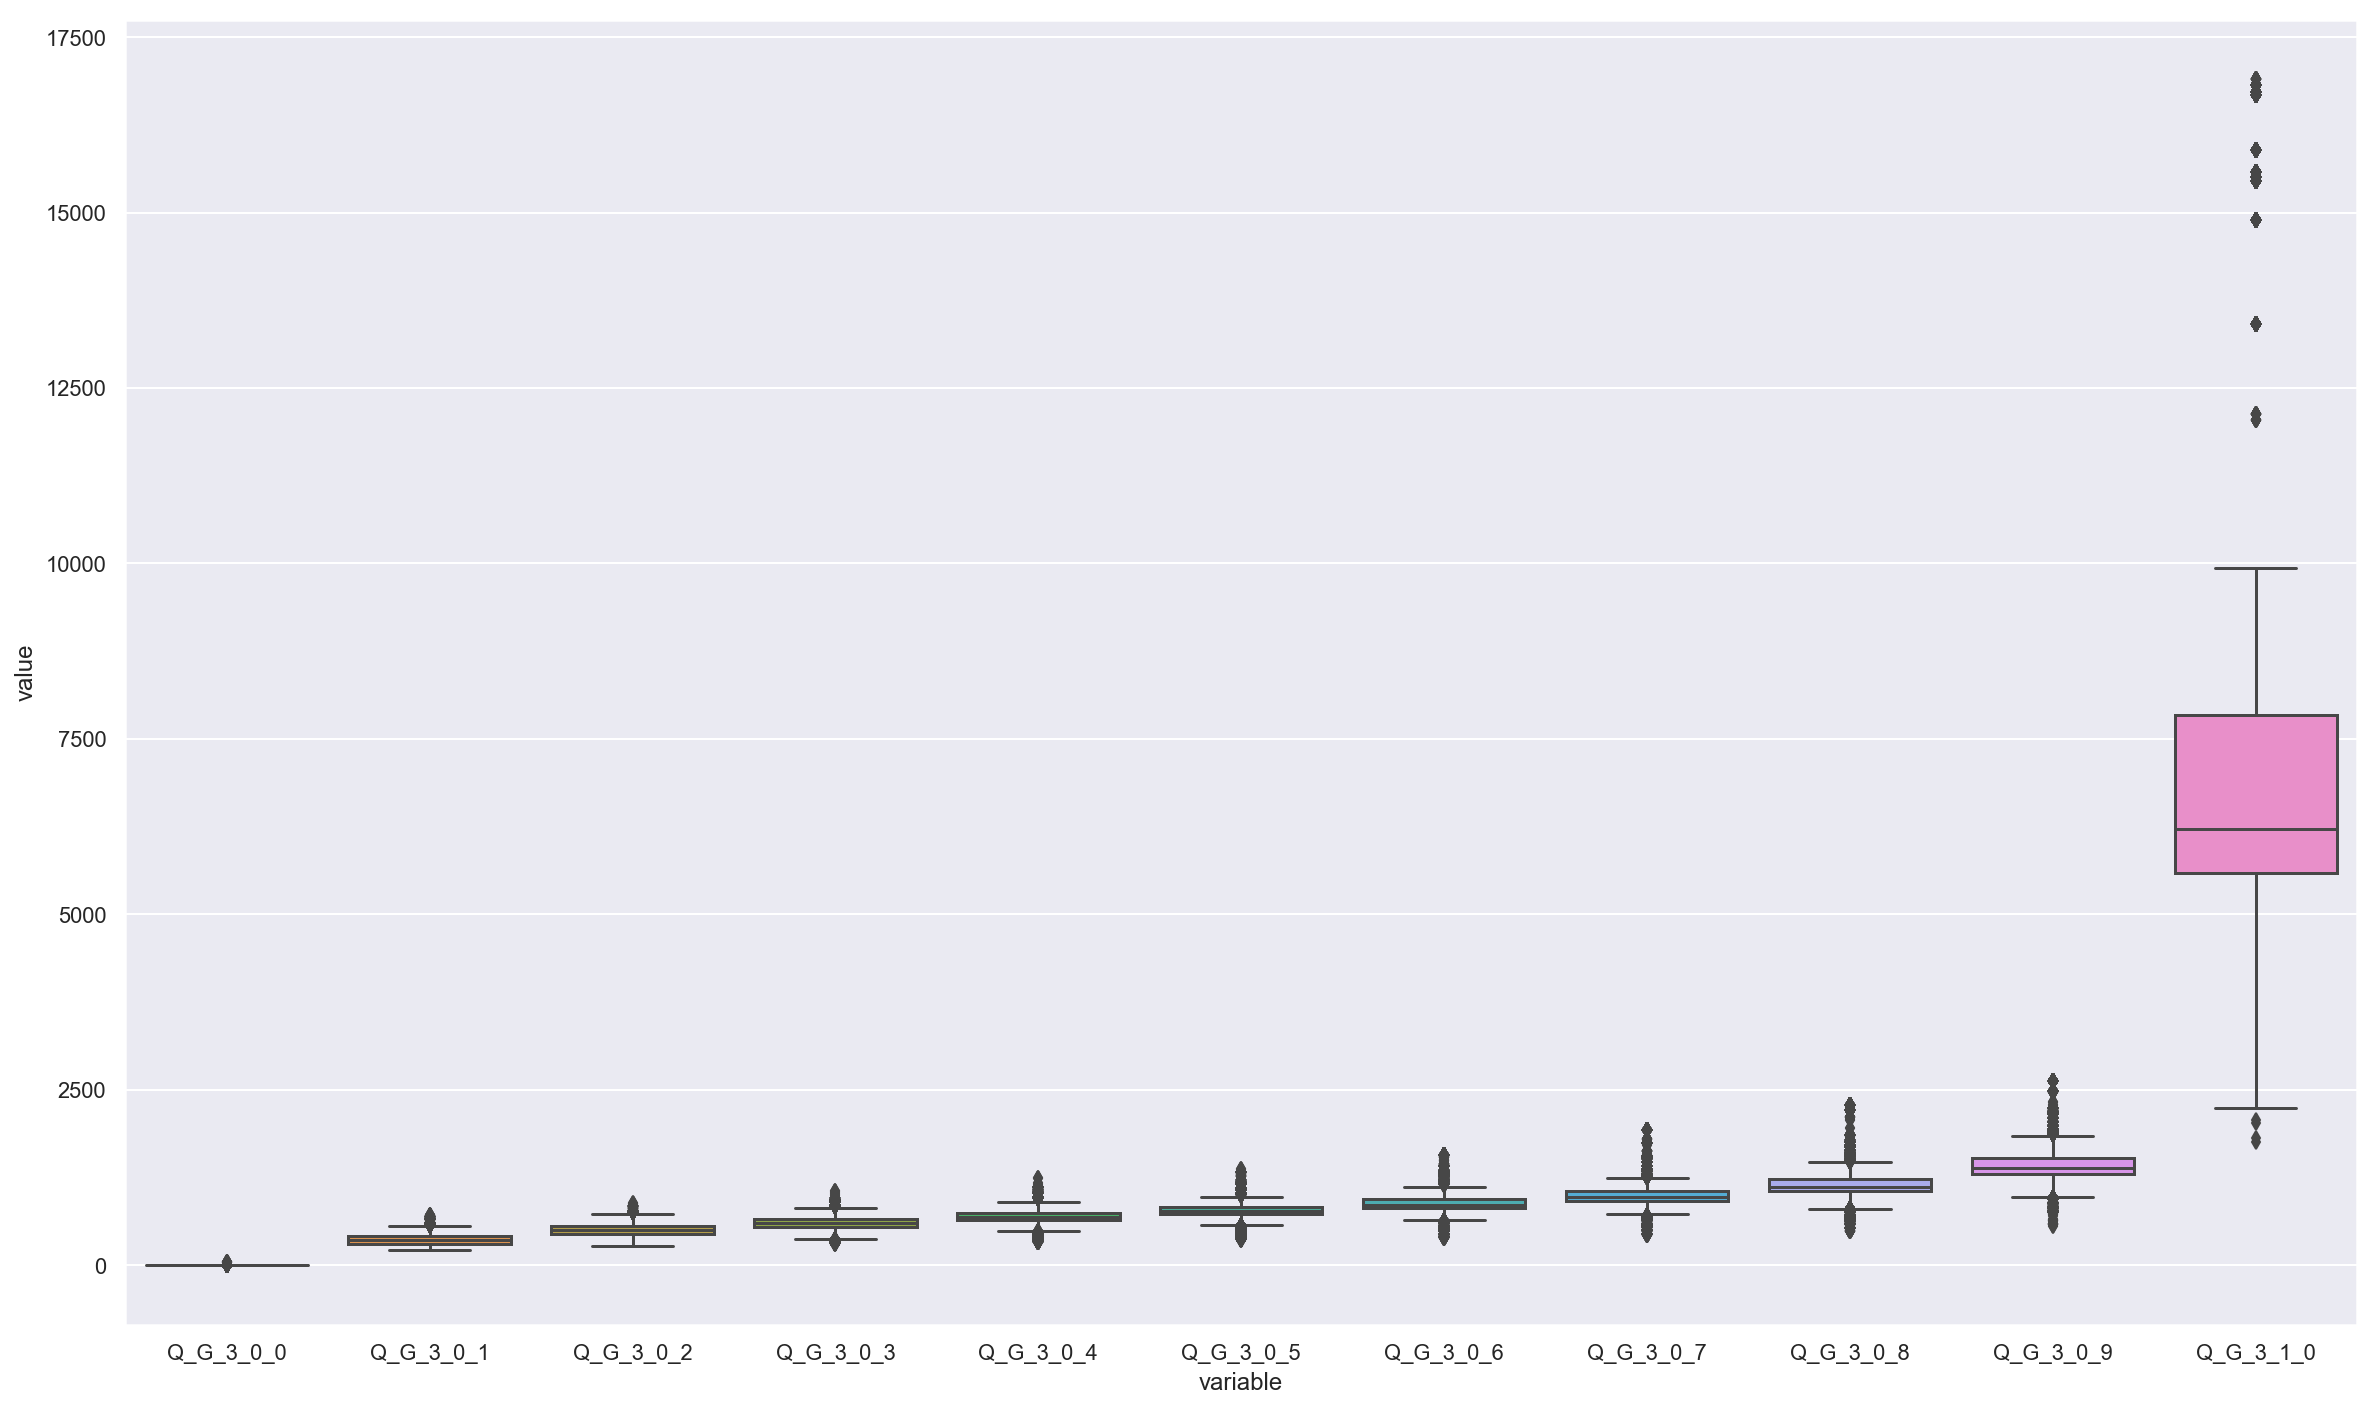

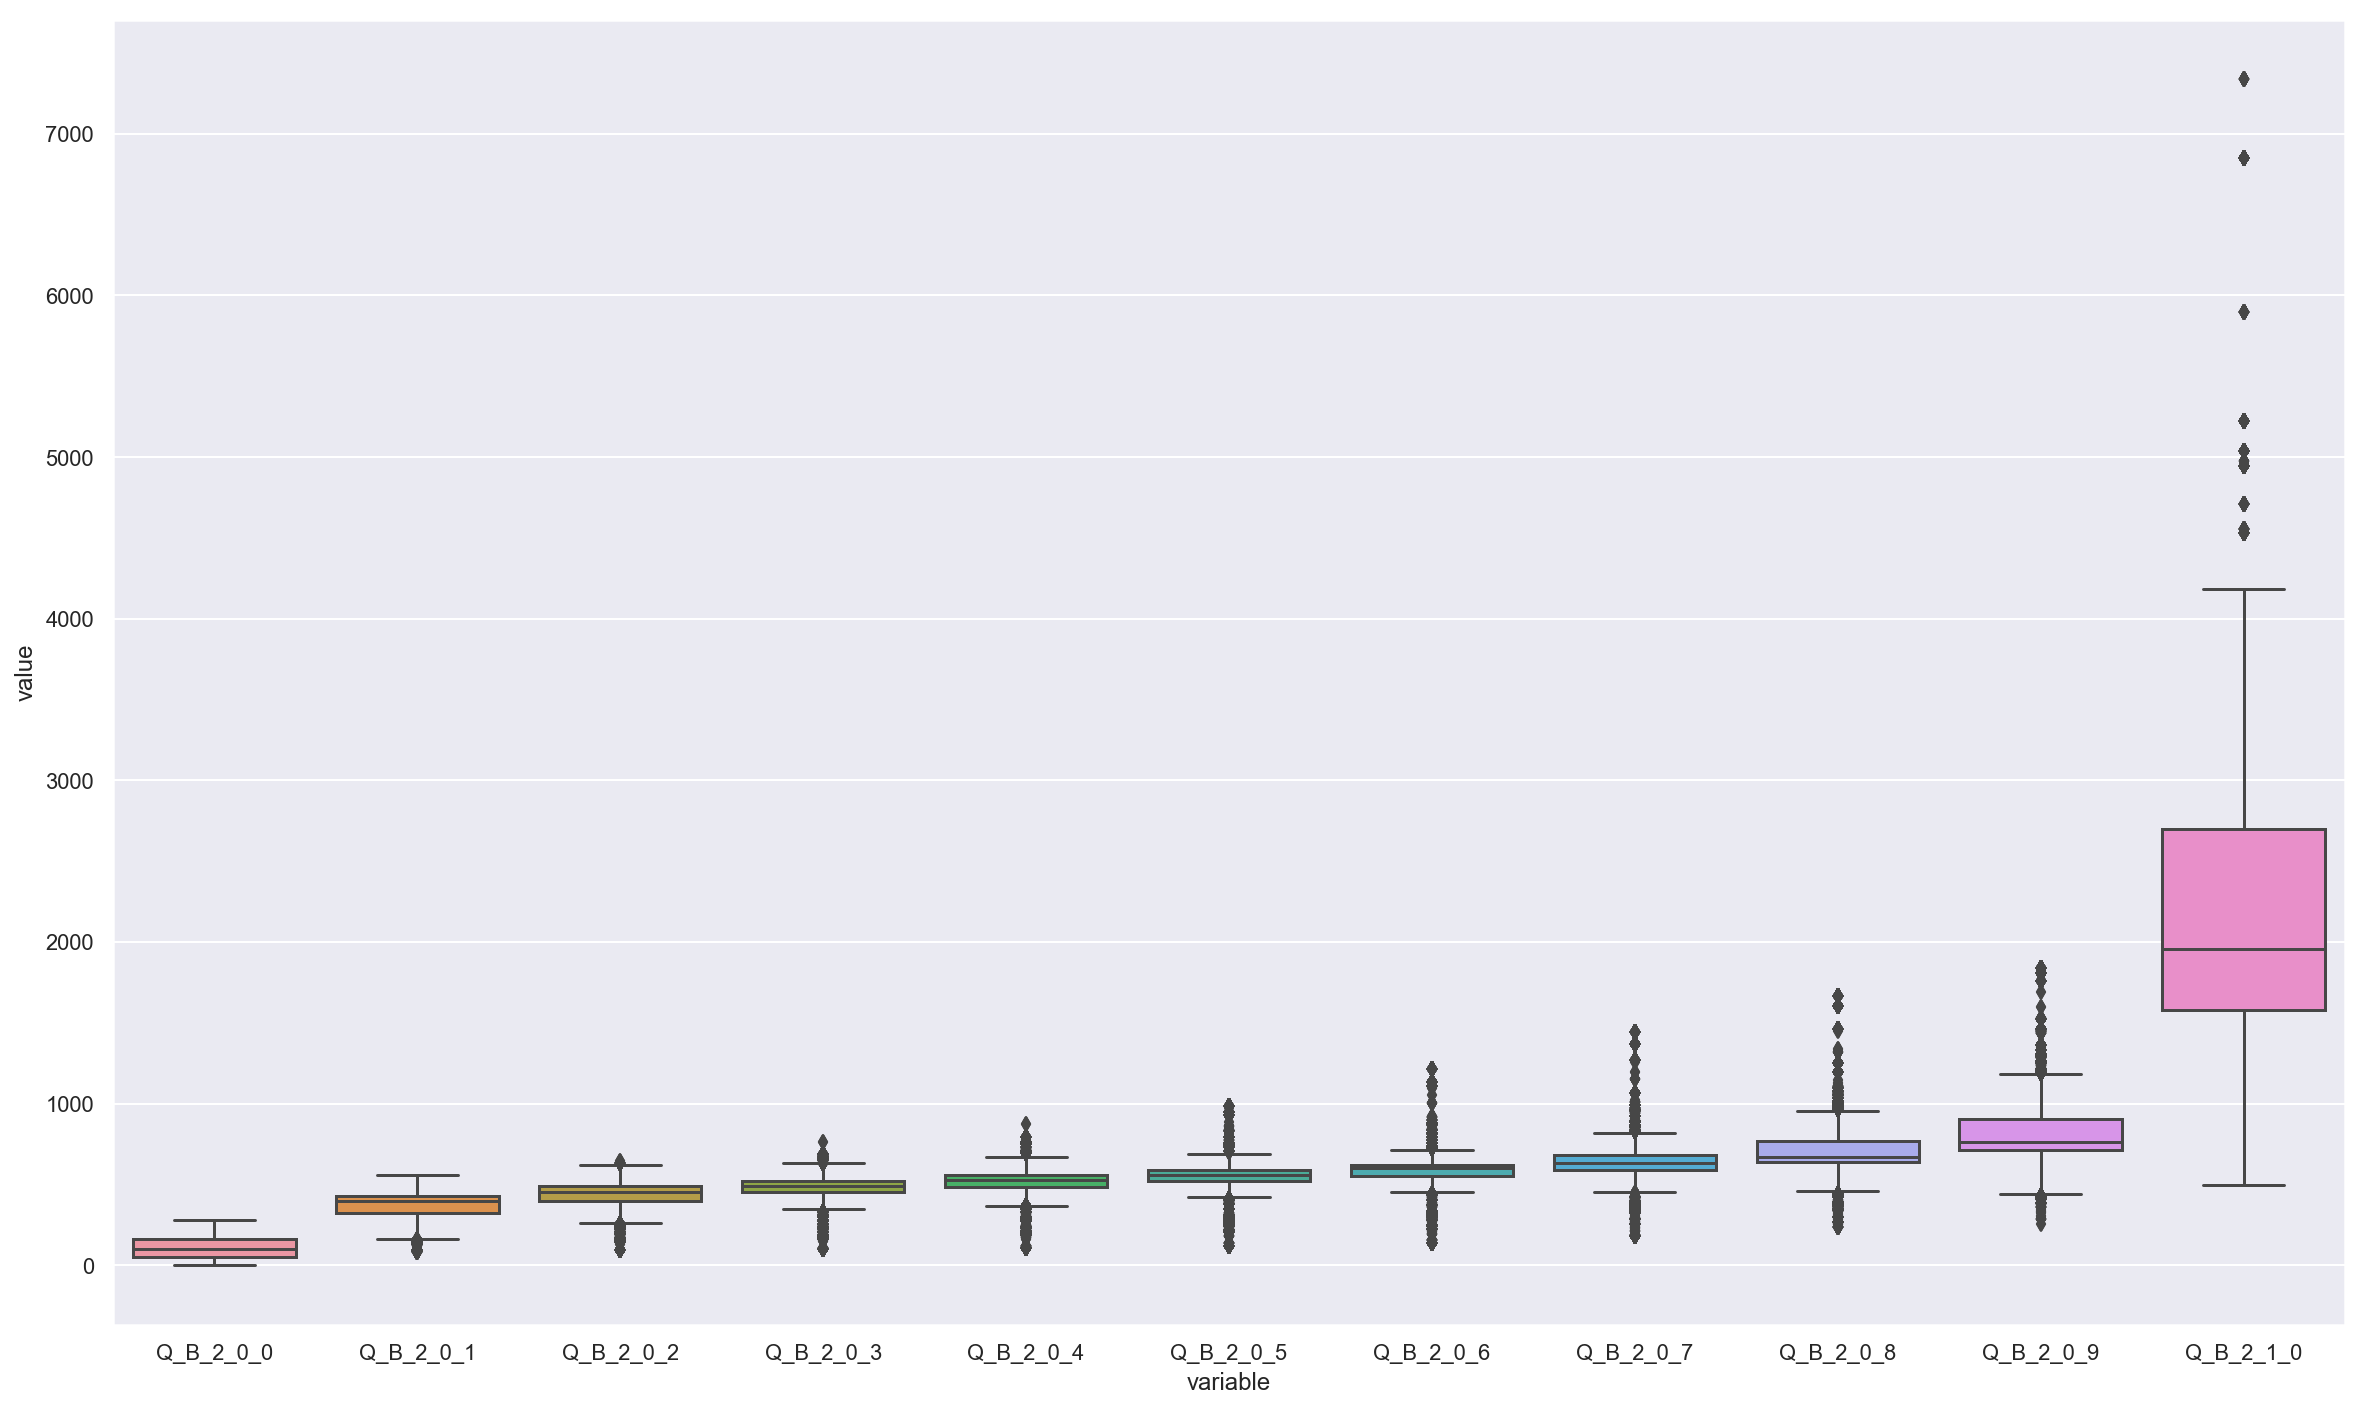

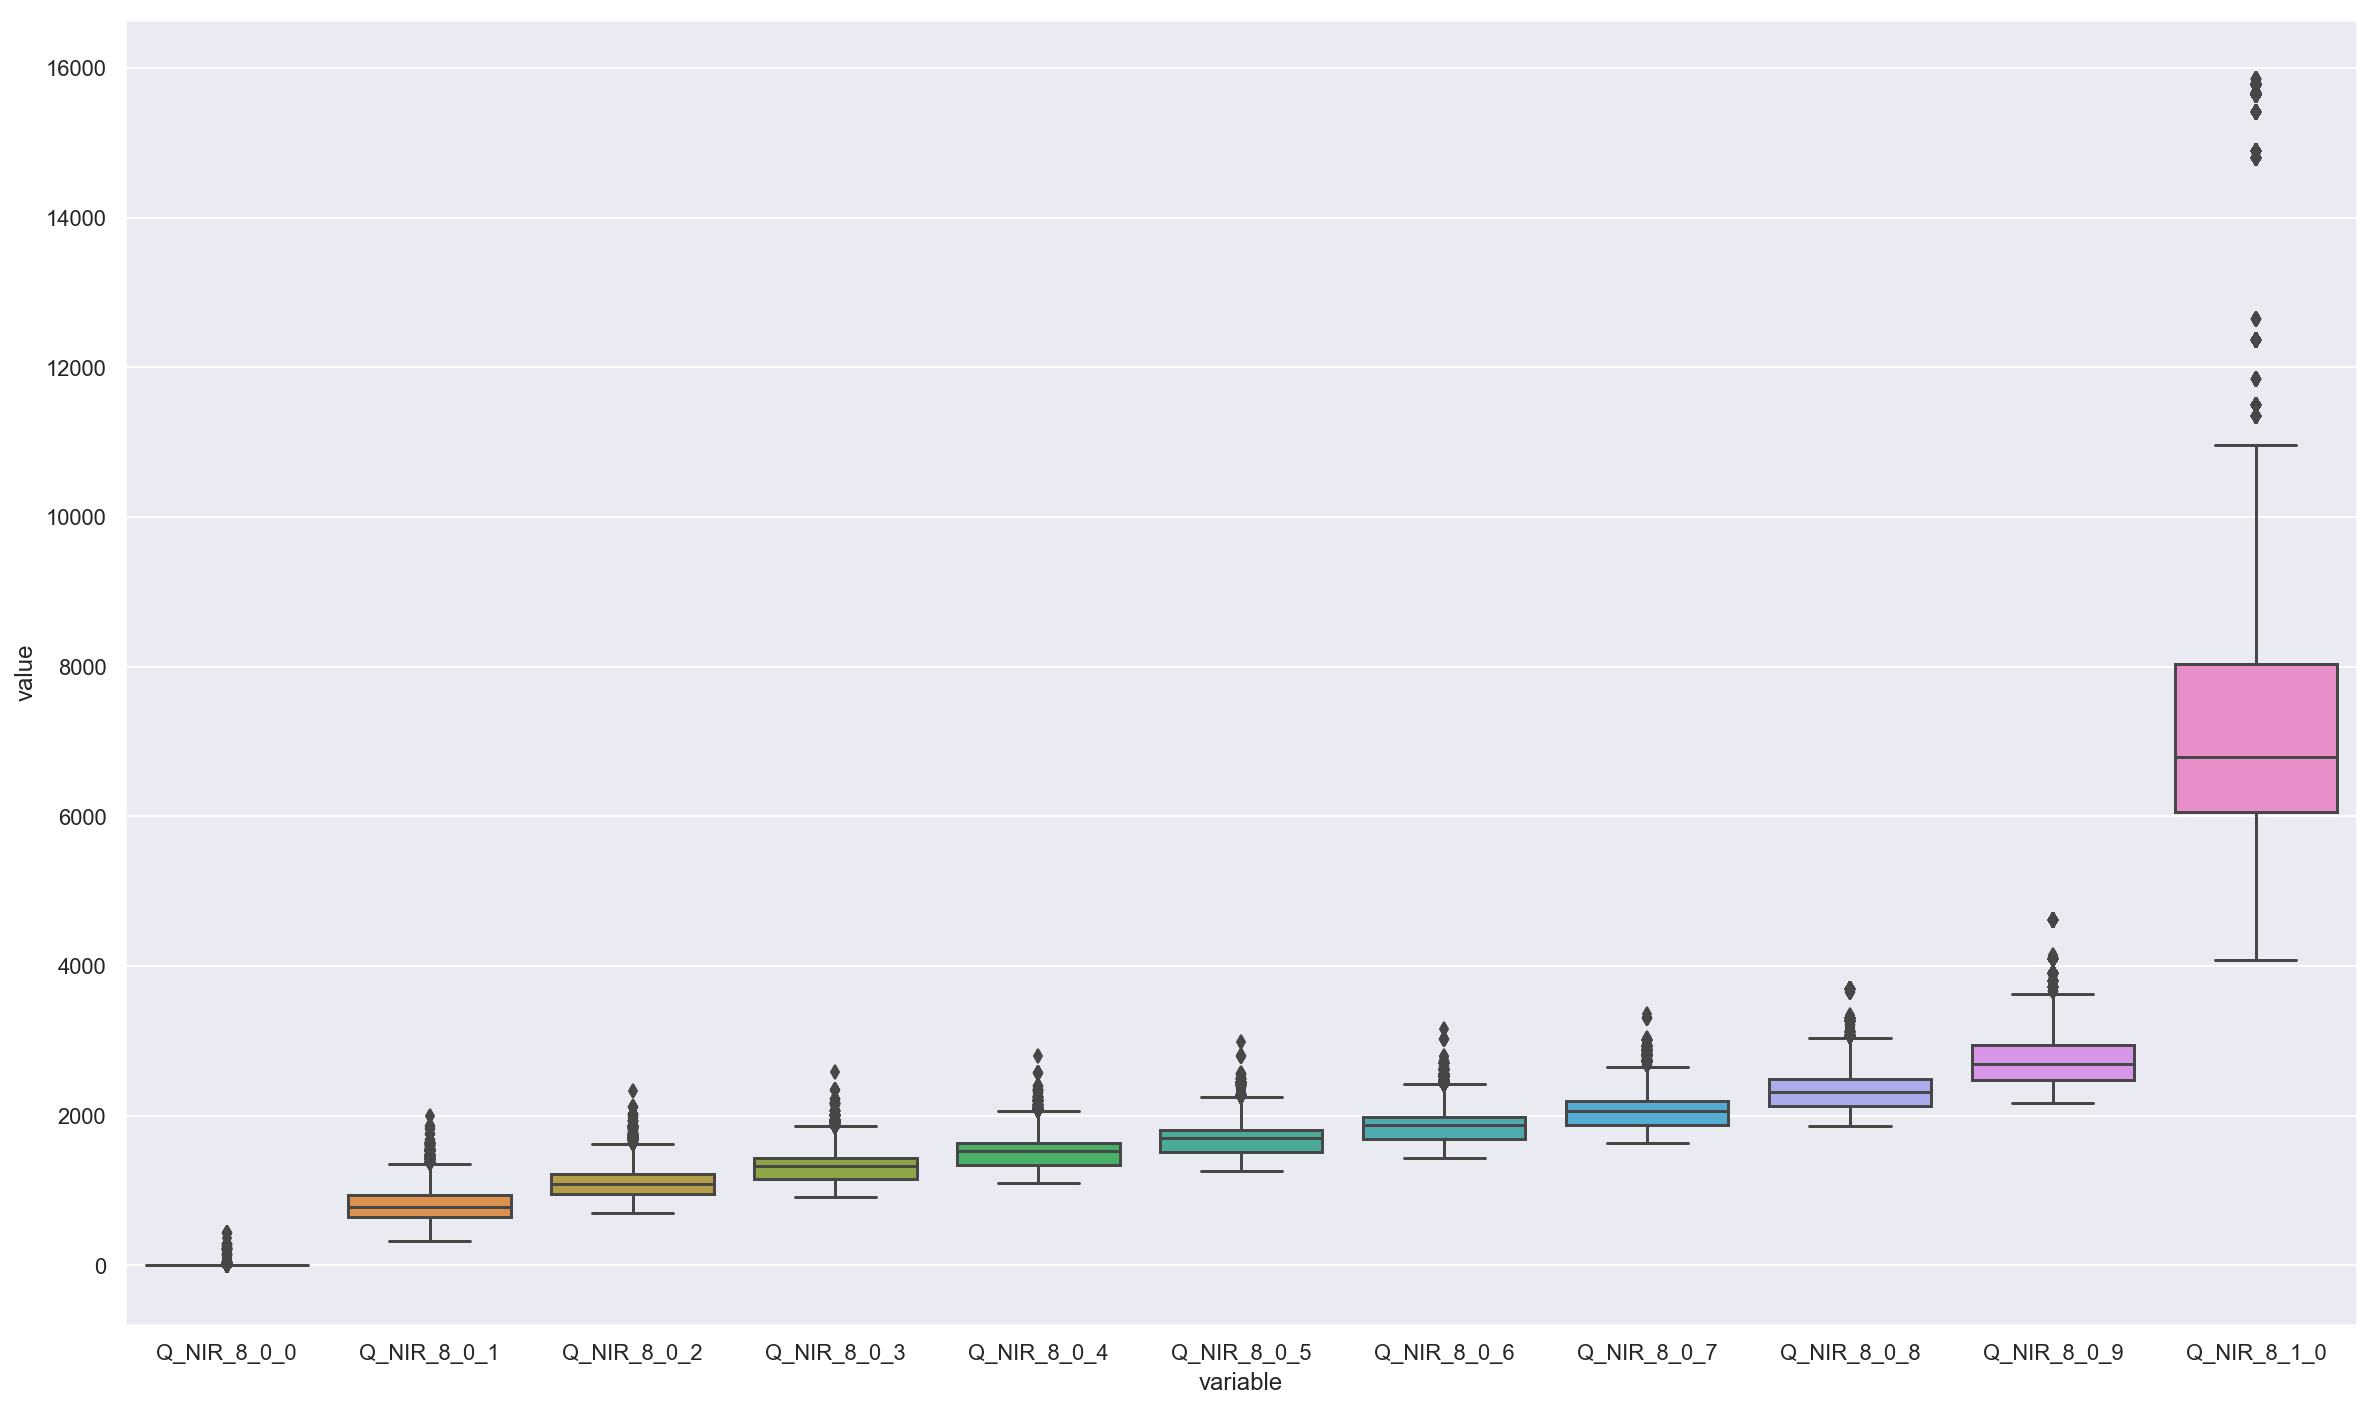

In [126]:
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0']))
plt.show()
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0']))
plt.show()
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0']))
plt.show()
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=pd.melt(df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0']))
plt.show()

# Agrupaciones de los colores

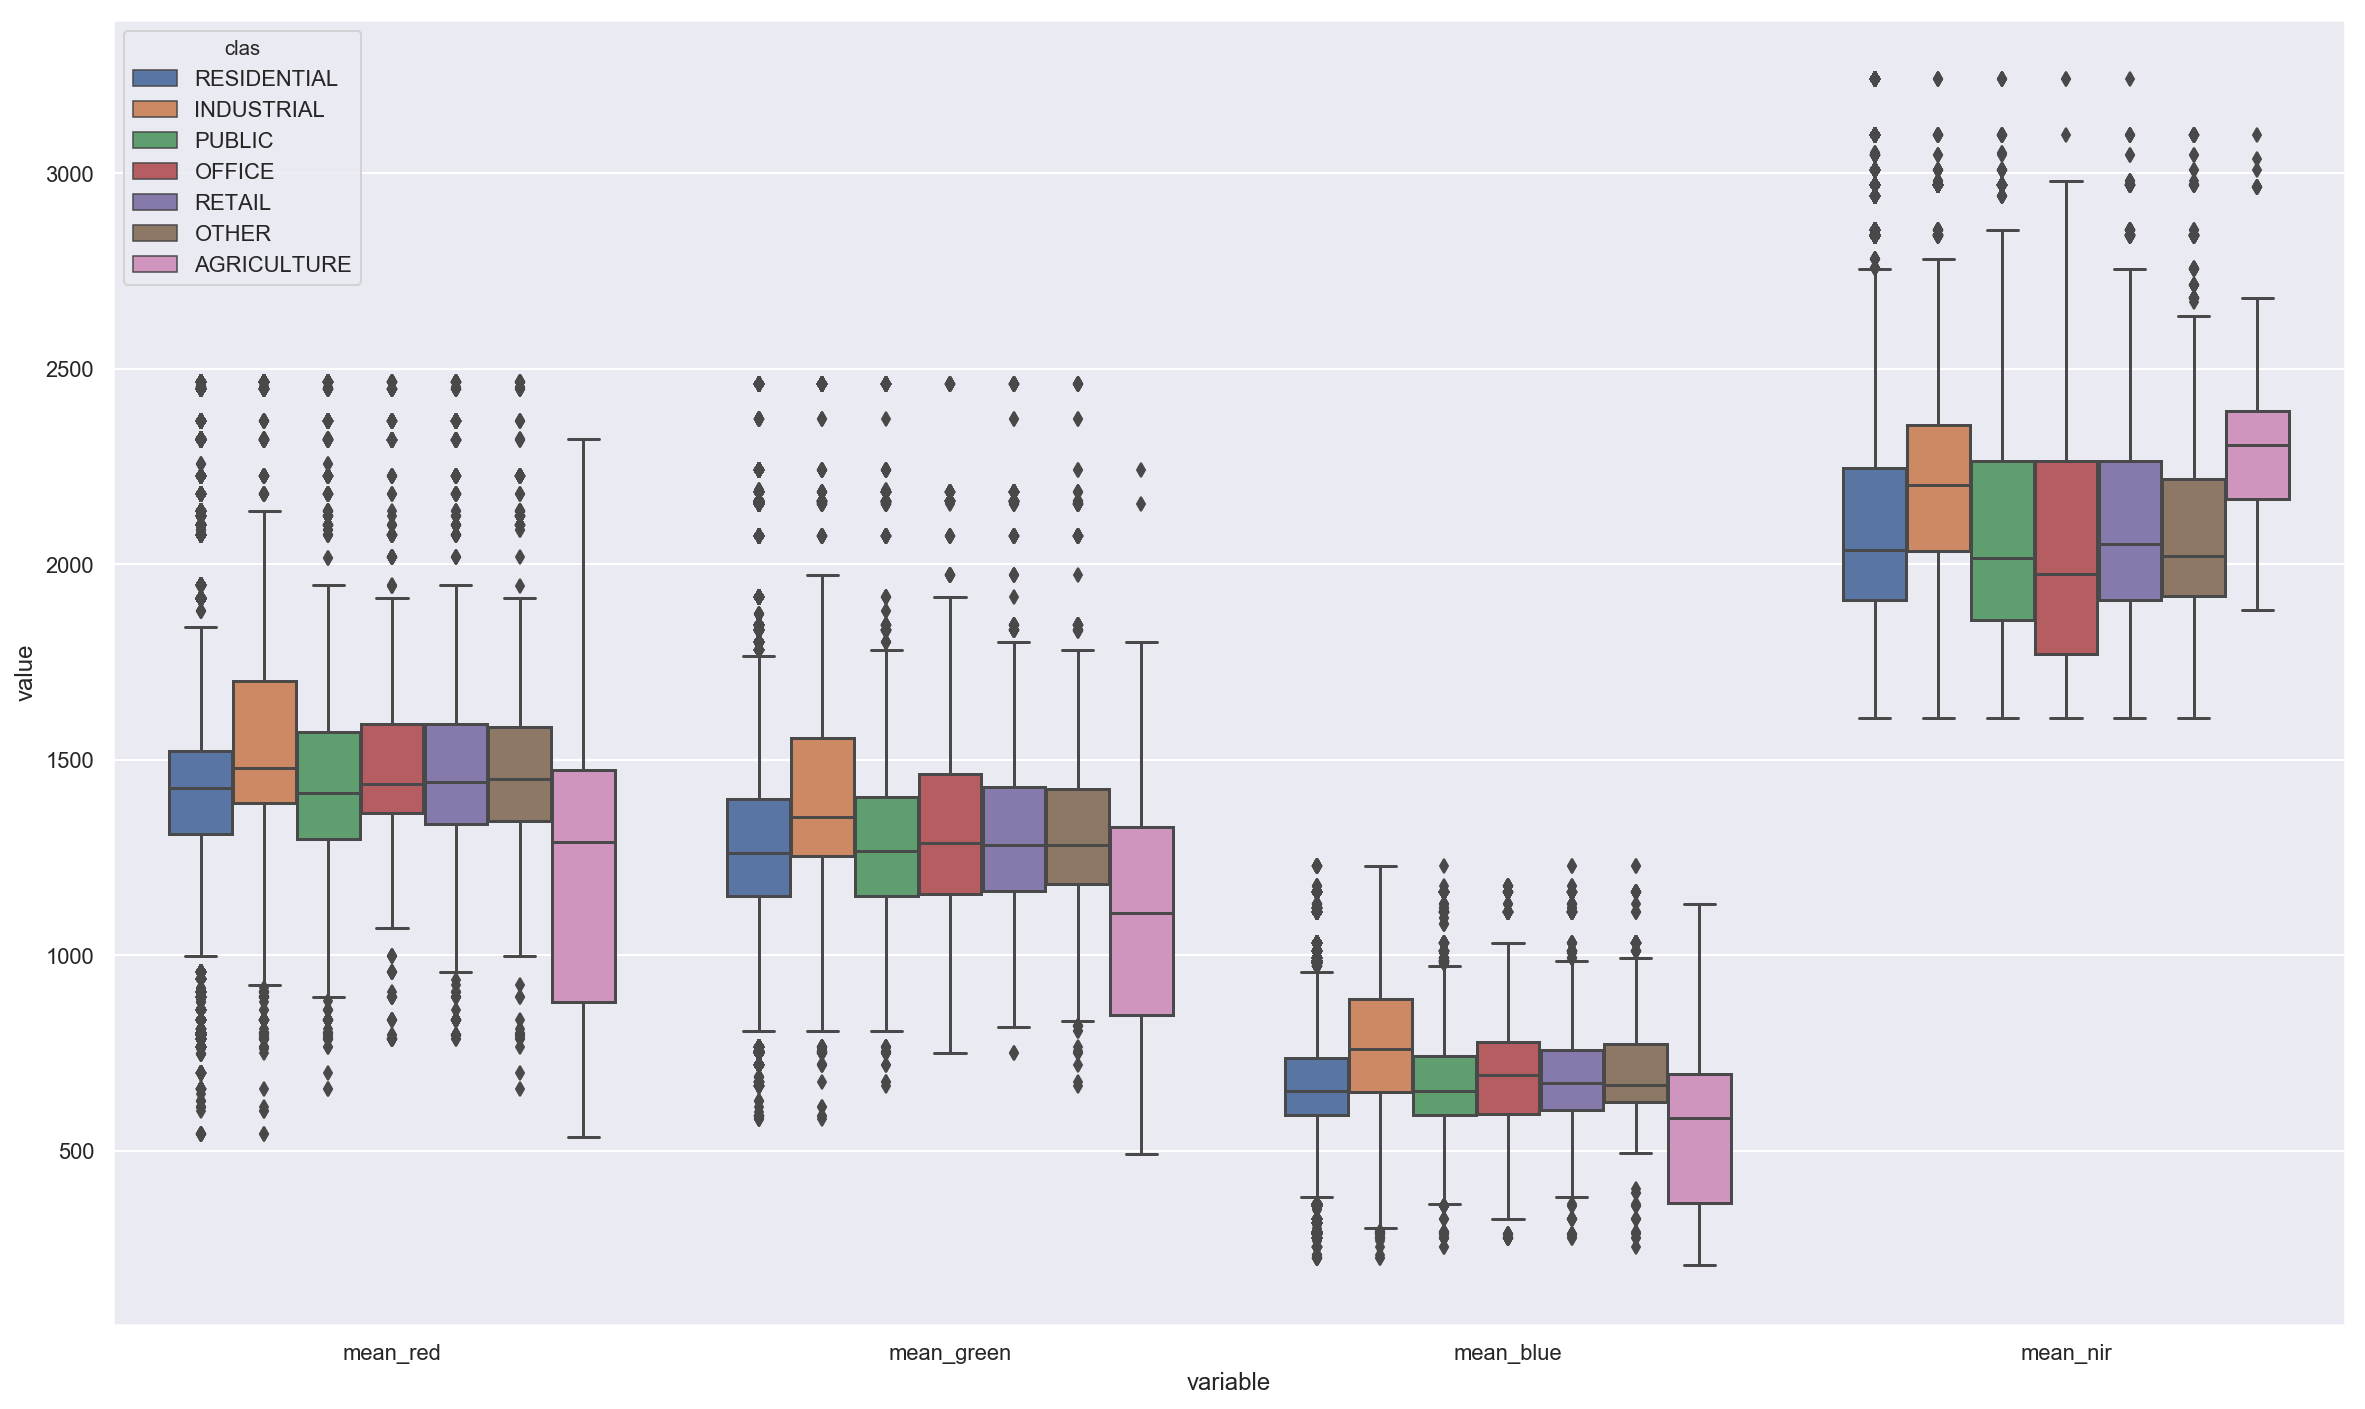

In [24]:
df_modelar['mean_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].mean(axis=1)
df_modelar['mean_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].mean(axis=1)
df_modelar['mean_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].mean(axis=1)
df_modelar['mean_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].mean(axis=1)

data = pd.melt(df_modelar.loc[:, 'mean_red':'mean_nir'])

pd.melt(df_modelar[['CLASE']])
series_list = [
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']])
]
clas = pd.concat(series_list)

data['clas'] = clas.value.values

plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", hue='clas', data=data)
plt.show()

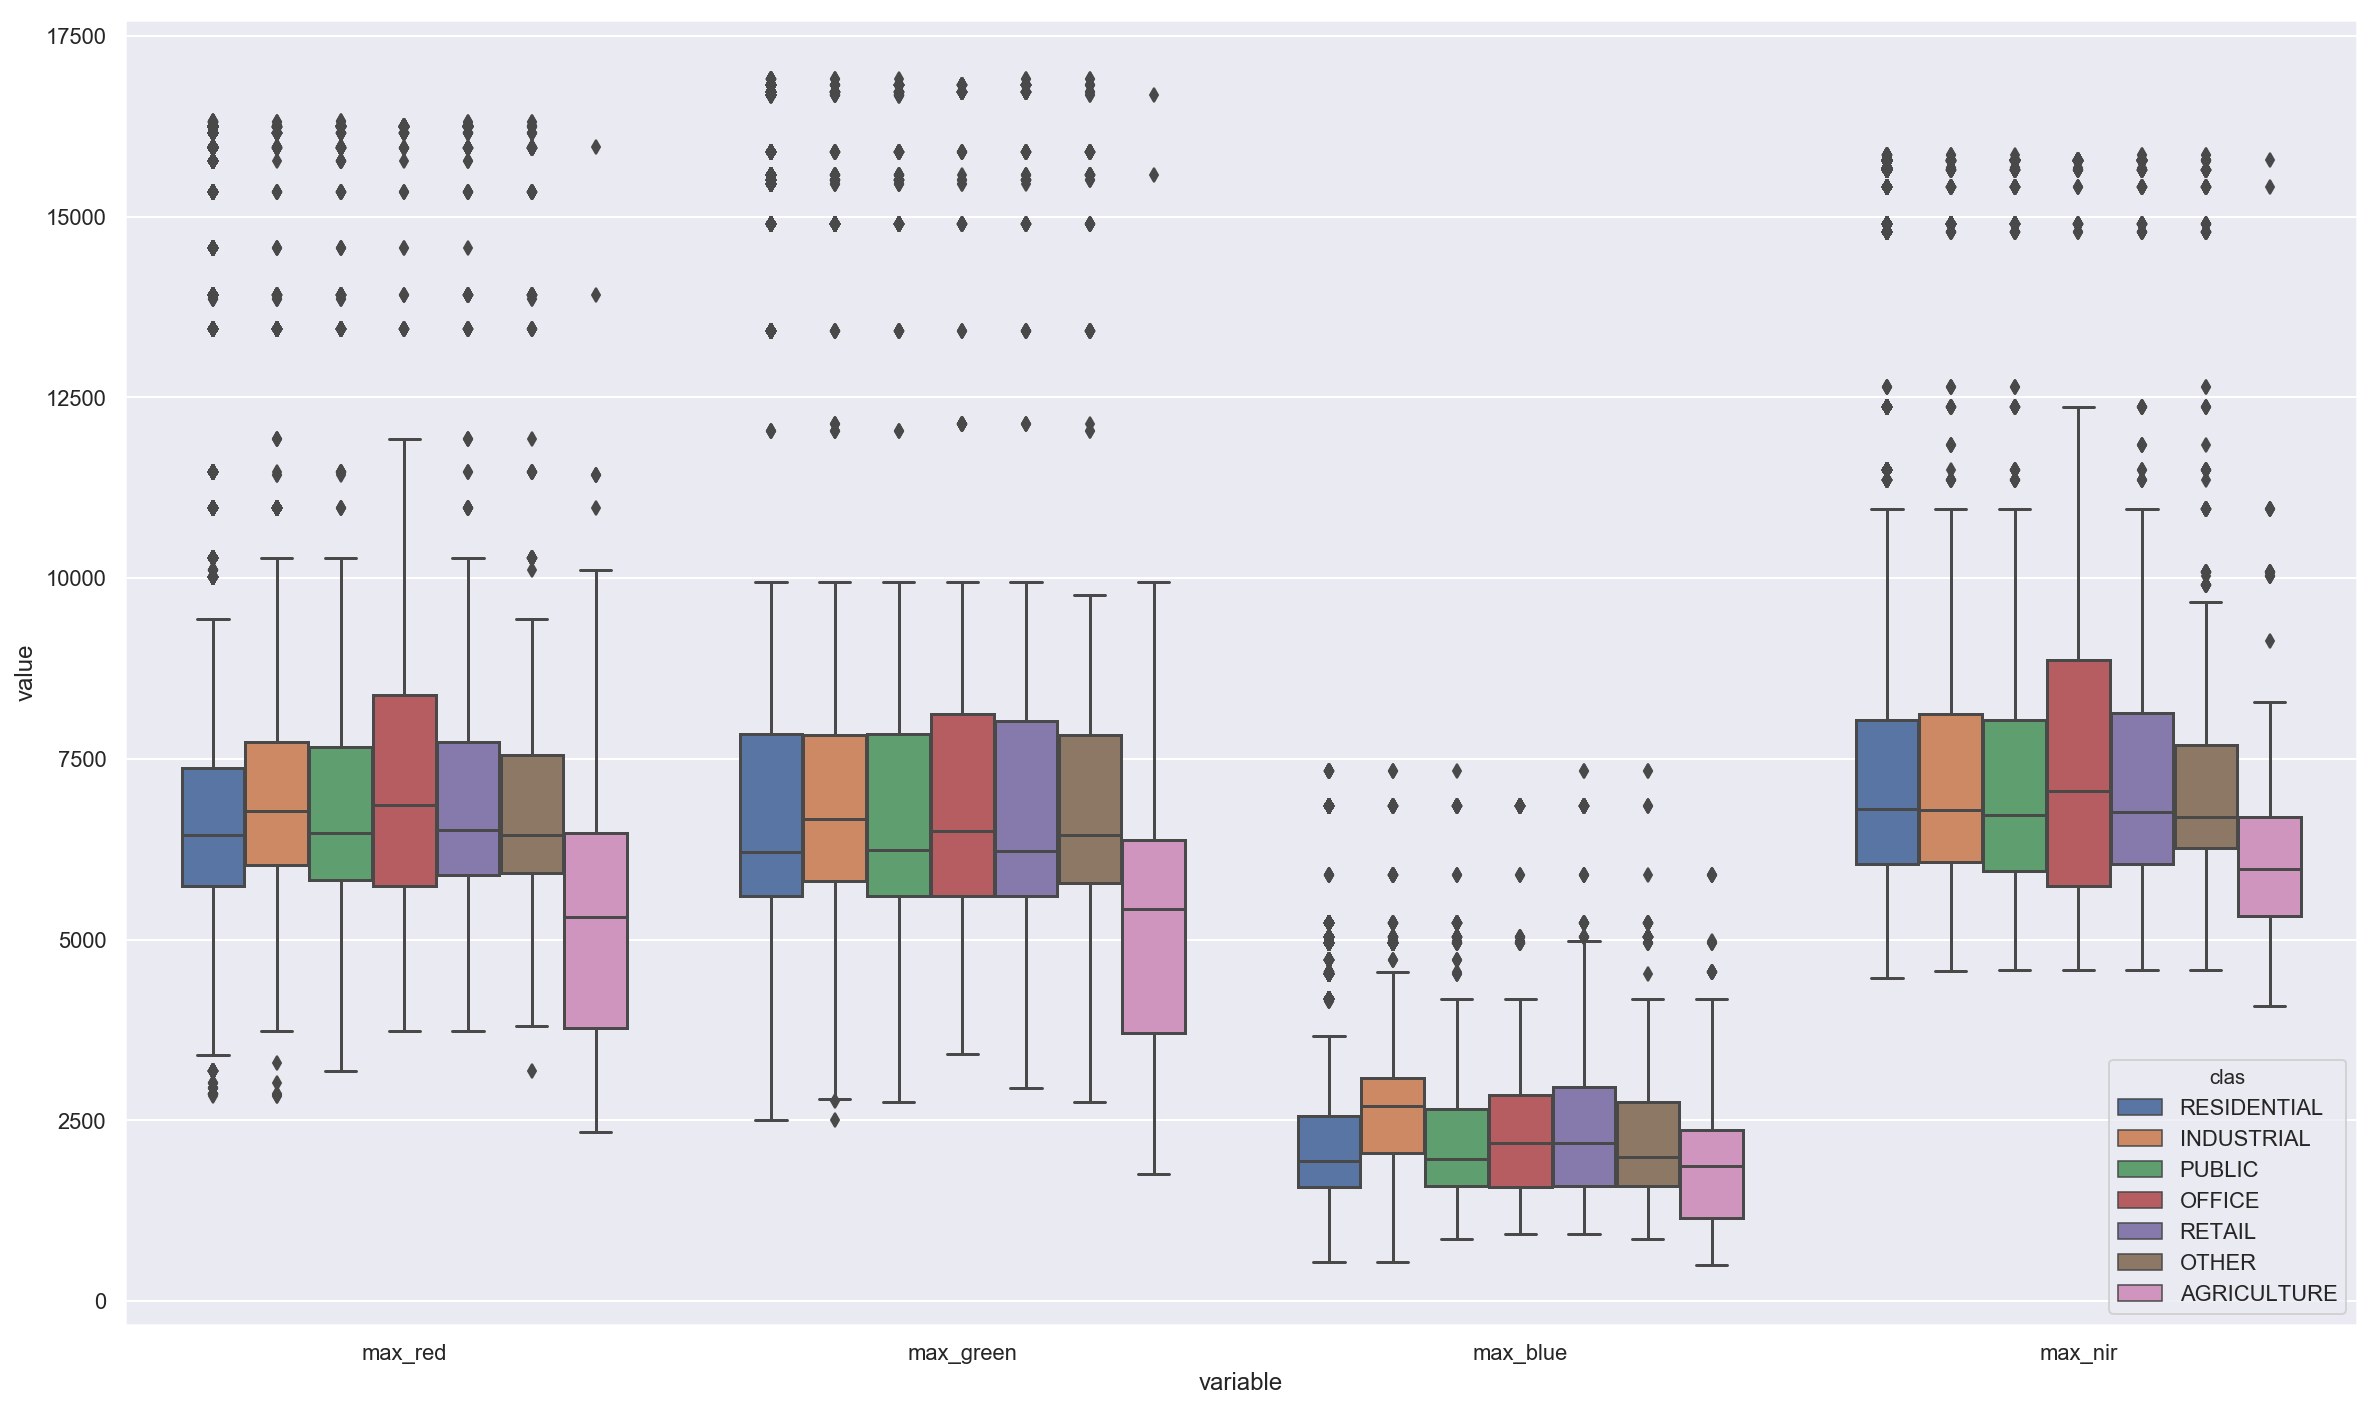

In [42]:
df_modelar['max_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].max(axis=1)
df_modelar['max_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].max(axis=1)
df_modelar['max_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].max(axis=1)
df_modelar['max_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].max(axis=1)

data = pd.melt(df_modelar.loc[:, 'max_red':'max_nir'])

pd.melt(df_modelar[['CLASE']])
series_list = [
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']])
]
clas = pd.concat(series_list)

data['clas'] = clas.value.values

plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", hue='clas', data=data)
plt.show()

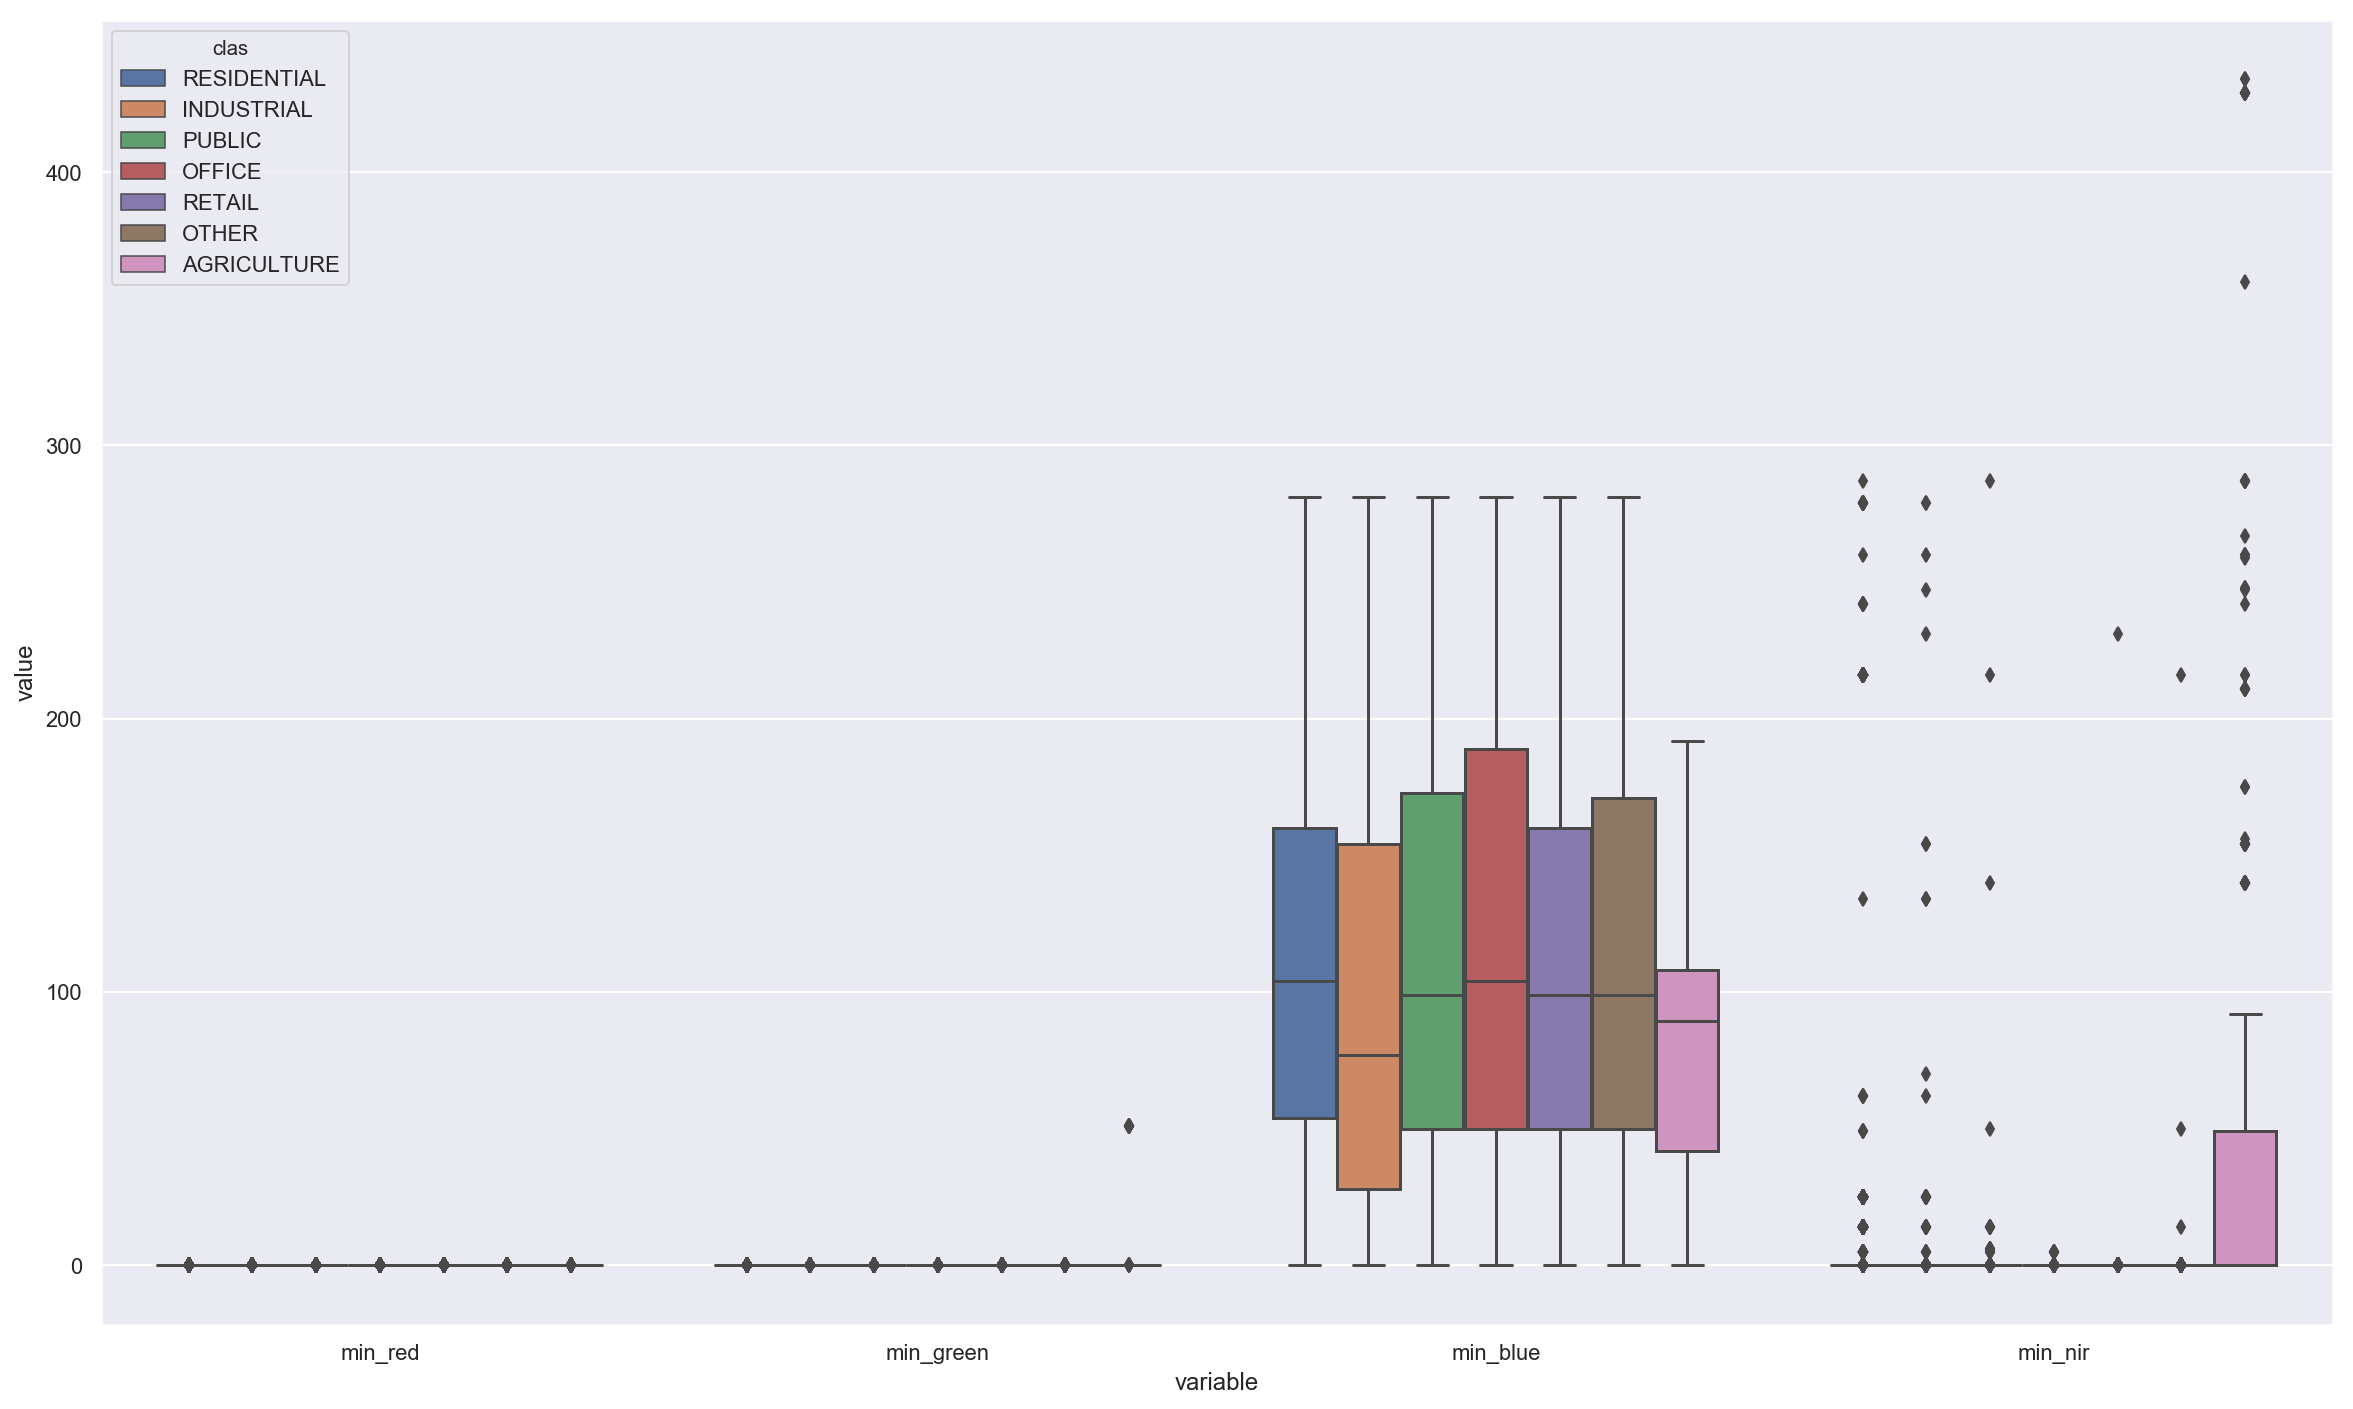

In [43]:
df_modelar['min_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].min(axis=1)
df_modelar['min_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].min(axis=1)
df_modelar['min_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].min(axis=1)
df_modelar['min_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].min(axis=1)

data = pd.melt(df_modelar.loc[:, 'min_red':'min_nir'])

pd.melt(df_modelar[['CLASE']])
series_list = [
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']])
]
clas = pd.concat(series_list)

data['clas'] = clas.value.values

plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", hue='clas', data=data)
plt.show()

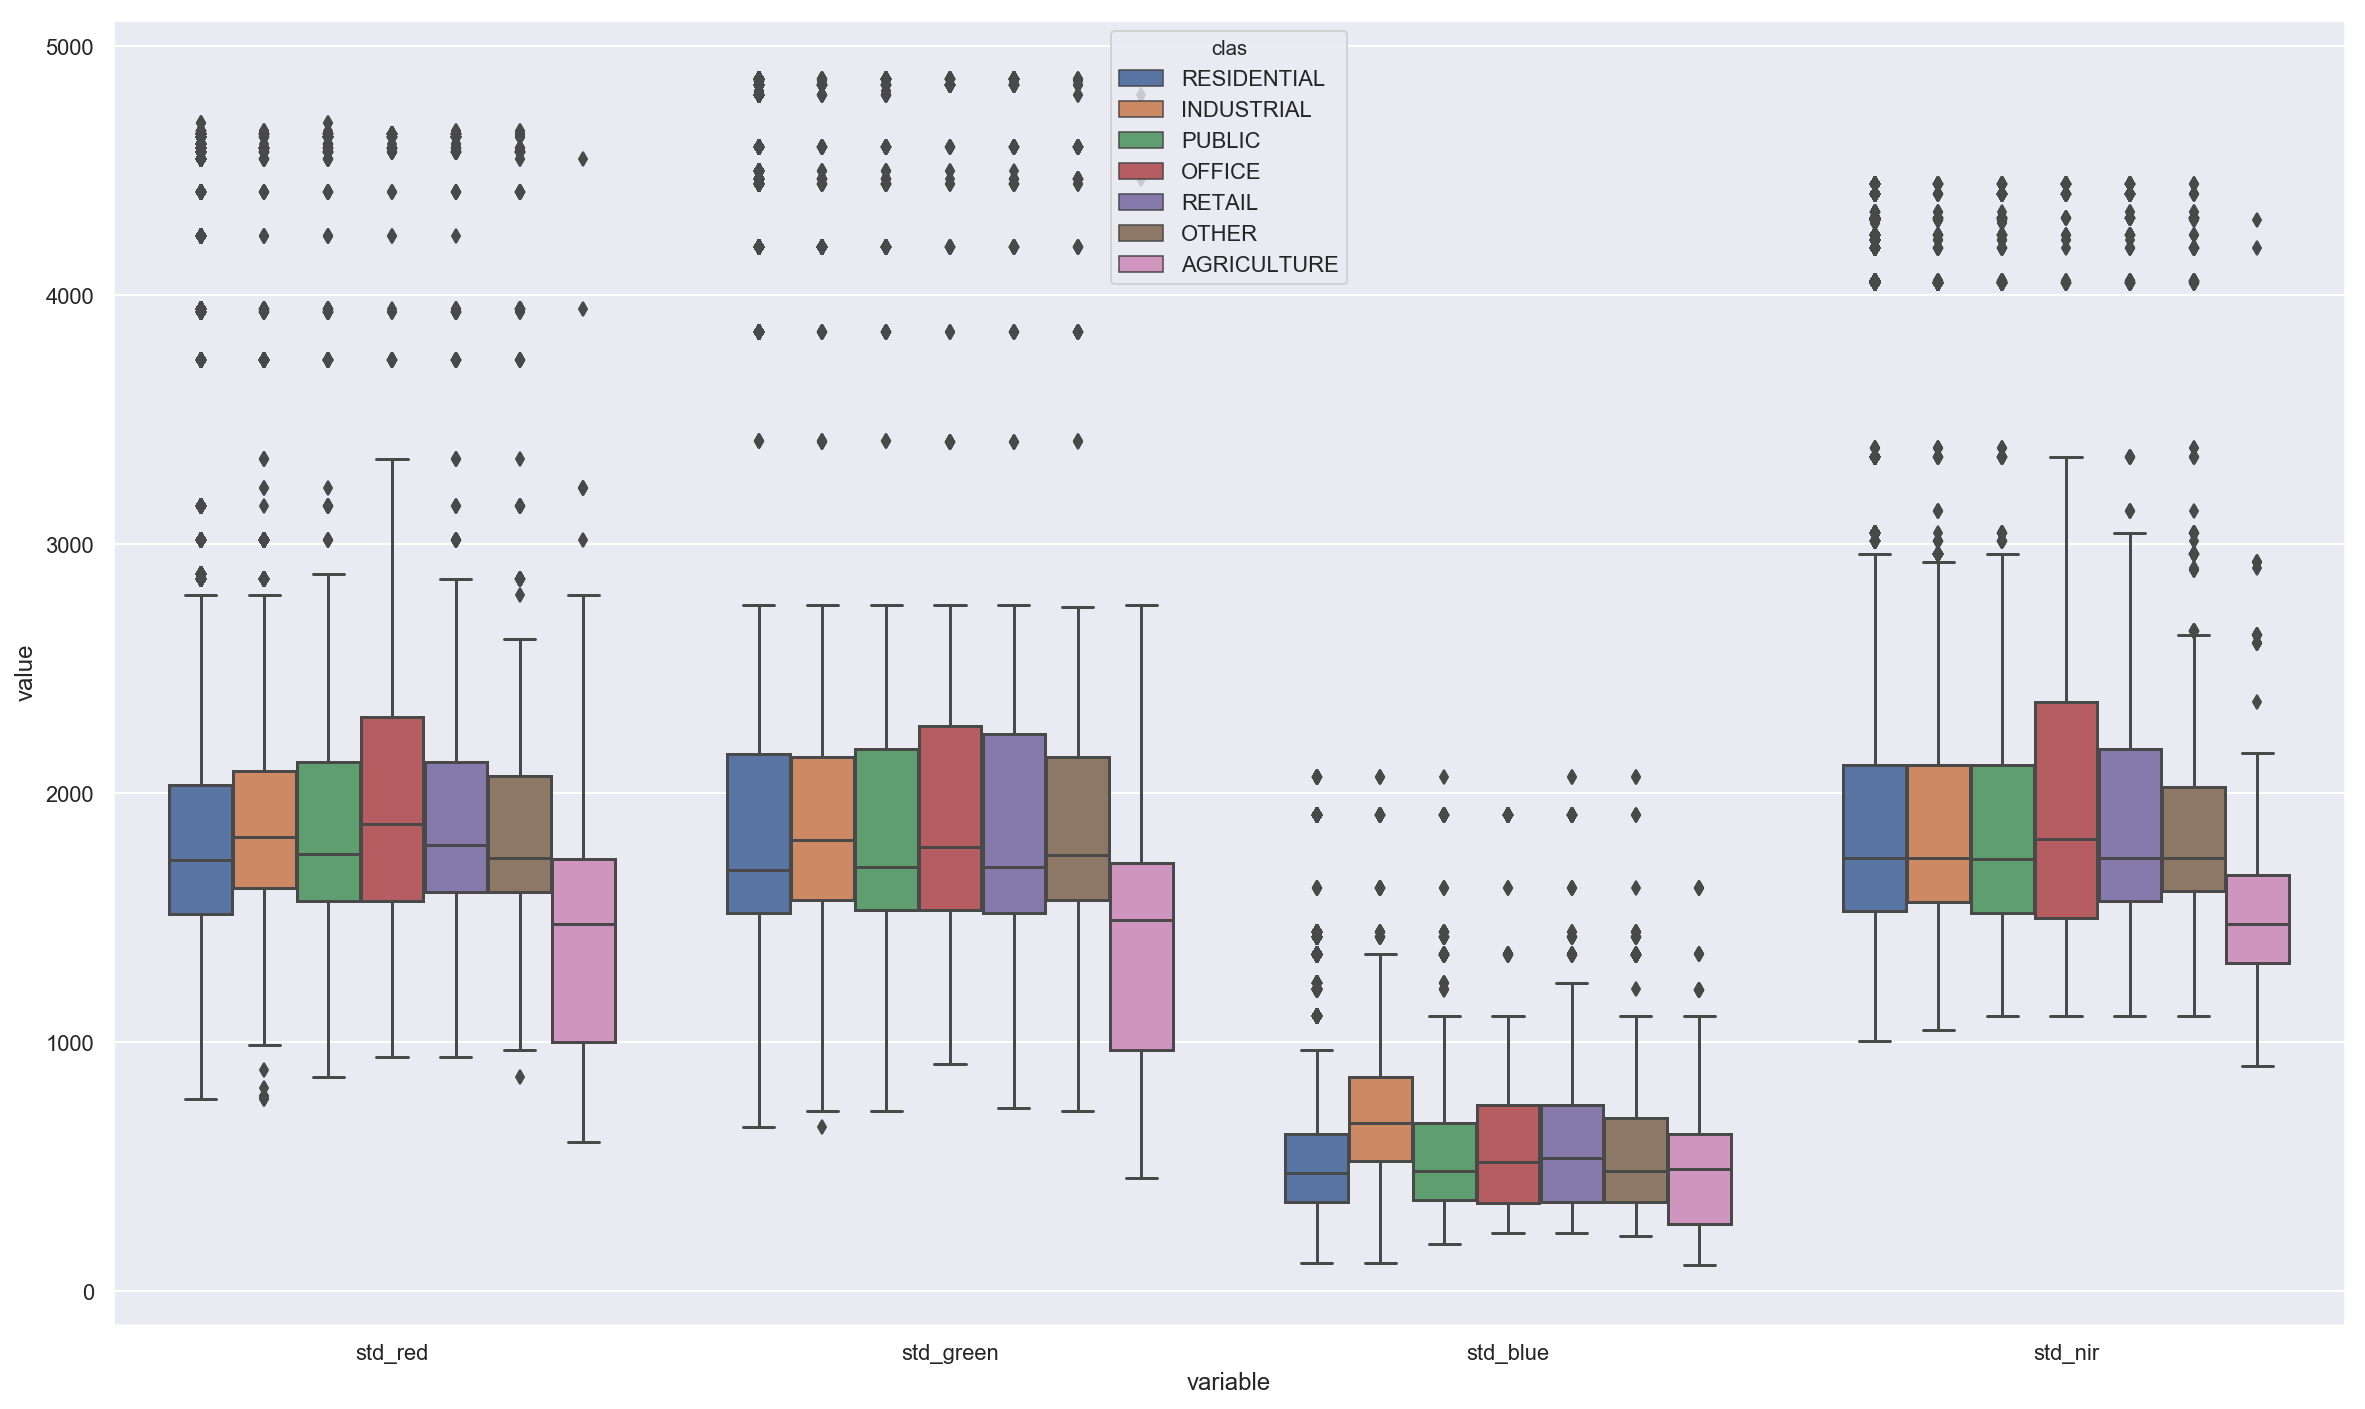

In [25]:
df_modelar['std_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].std(axis=1)
df_modelar['std_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].std(axis=1)
df_modelar['std_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].std(axis=1)
df_modelar['std_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].std(axis=1)

data = pd.melt(df_modelar.loc[:, 'std_red':'std_nir'])

pd.melt(df_modelar[['CLASE']])
series_list = [
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']]),
    pd.melt(df_modelar[['CLASE']])
]
clas = pd.concat(series_list)

data['clas'] = clas.value.values

plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", hue='clas', data=data)
plt.show()

In [26]:
df_modelar.columns

Index(['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3',
       'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8',
       'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2',
       'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7',
       'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1',
       'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5',
       'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9',
       'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
       'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID', 'CLASE',
       'distance_to_center', 'N_AGRICULTURE', 'N_INDUSTRIAL', 'N_OFFICE',
       'N_OTHER', 'N_PUBLIC', 'N_RESIDENTIAL', 'N_RETAIL', 'mean_red',
       'mean_green', 'mean_blue', 'mean_nir', 'std_red', 'std_

In [46]:
df_modelar[df_modelar['CLASE']=='AGRICULTURE'][['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'mean_red', 'max_red', 'min_red','std_red','CLASE']]

Q_R_4_0_0   Q_R_4_0_1   Q_R_4_0_2   Q_R_4_0_3  \
ID                                                                   
AA236D8FA8AD6934  2.146913e-06  464.999939  610.000220  721.000983   
F351C40026825514  4.153913e-04  371.001175  458.999664  521.000397   
493E4E7651BC7325  4.849879e-11  400.998581  570.003540  684.001343   
FB9E58FDCEB3A078  1.139205e-03  493.000519  558.999817  597.000397   
2FDA1C767B043D8A  5.542996e-06  221.999855  254.000000  285.998856   
...                        ...         ...         ...         ...   
B54B3BEA081C446F  1.222033e-06  180.000179  266.000403  444.997711   
D2486E36764CCDB7  1.598830e-03  464.999869  585.003613  708.996710   
3A1BD00C088B391B  1.639429e-06  284.999603  357.000183  419.999115   
4FF046EC257E4836  1.613681e-03  497.500580  608.999878  690.000519   
D0DE0BB6F6A271CC  0.000000e+00  547.999719  658.000720  744.002570   

                   Q_R_4_0_4   Q_R_4_0_5    Q_R_4_0_6    Q_R_4_0_7  \
ID                                                                   
AA236D8FA8AD6934  828.999976  953.000854  1122.000000  1347.999866   
F351C40026825514  565.000000  603.999542   643.000122   690.000061   
493E4E7651BC7325  800.005432  932.995483  1089.997925  1291.003601   
FB9E58FDCEB3A078  625.999268  648.000244   673.000122   706.000610   
2FDA1C767B043D8A  326.999756  384.998672   463.000336   565.999054   
...                      ...         ...          ...          ...   
B54B3BEA081C446F  616.999976  763.998962   911.997327  1105.003894   
D2486E36764CCDB7  841.000378  975.996338  1117.203394  1263.998889   
3A1BD00C088B391B  481.999207  543.999725   609.999207   681.999237   
4FF046EC257E4836  782.003601  902.503479  1069.997314  1298.002380   
D0DE0BB6F6A271CC  825.000037  905.998535   993.999573  1105.999500   

                    Q_R_4_0_8    Q_R_4_0_9    Q_R_4_1_0     mean_red  \
ID                                                                     
AA236D8FA8AD6934  1621.995459  1992.993335  6915.377491  1507.124375   
F351C40026825514   752.998413   901.000275  4836.263416   940.296680   
493E4E7651BC7325  1552.997070  1982.998657  6031.623933  1394.238688   
FB9E58FDCEB3A078   763.999573   897.998962  3741.501229   882.318353   
2FDA1C767B043D8A   714.001099   921.999084  2570.192203   609.926265   
...                       ...          ...          ...          ...   
B54B3BEA081C446F  1356.001001  1756.998743  5314.718364  1156.065142   
D2486E36764CCDB7  1442.000439  1707.002625  7023.844827  1466.368062   
3A1BD00C088B391B   779.001526   993.000122  3567.295518   792.663040   
4FF046EC257E4836  1626.000977  2085.999512  4635.017792  1290.547968   
D0DE0BB6F6A271CC  1266.000928  1546.997400  6247.488976  1349.226178   

                      max_red       min_red      std_red        CLASE  
ID                                                                     
AA236D8FA8AD6934  6915.377491  2.146913e-06  1876.680093  AGRICULTURE  
F351C40026825514  4836.263416  4.153913e-04  1312.854496  AGRICULTURE  
493E4E7651BC7325  6031.623933  4.849879e-11  1632.804058  AGRICULTURE  
FB9E58FDCEB3A078  3741.501229  1.139205e-03   974.713892  AGRICULTURE  
2FDA1C767B043D8A  2570.192203  5.542996e-06   697.074576  AGRICULTURE  
...                       ...           ...          ...          ...  
B54B3BEA081C446F  5314.718364  1.222033e-06  1476.109658  AGRICULTURE  
D2486E36764CCDB7  7023.844827  1.598830e-03  1903.729201  AGRICULTURE  
3A1BD00C088B391B  3567.295518  1.639429e-06   956.952578  AGRICULTURE  
4FF046EC257E4836  4635.017792  1.613681e-03  1245.320980  AGRICULTURE  
D0DE0BB6F6A271CC  6247.488976  0.000000e+00  1673.382522  AGRICULTURE  

[274 rows x 16 columns]

In [138]:
df_modelar.drop(columns=df_modelar.columns[0:44], inplace=True)

In [139]:
df_modelar.head()

AREA   GEOM_R1   GEOM_R2   GEOM_R3   GEOM_R4  \
ID                                                                     
ED9D46EC9089E51C   69.265483  0.549504  0.086580  0.091630  1.058322   
F9643836C56CEF97  170.407108  0.497172  0.048519  0.060132  1.239357   
55C034472ED68EAC  270.463800  0.729586  0.052521  0.051361  0.977915   
37BA5591BA9128AF   61.612400  0.442987  0.086207  0.083403  0.967473   
1F0DC2B421224578   10.474800  0.738119  0.228311  0.308642  1.351852   

                  CONTRUCTIONYEAR  MAXBUILDINGFLOOR  CADASTRALQUALITYID  \
ID                                                                        
ED9D46EC9089E51C             1980               5.0                 5.0   
F9643836C56CEF97             1968               5.0                 3.0   
55C034472ED68EAC             1968               8.0                 5.0   
37BA5591BA9128AF             1985               1.0                 6.0   
1F0DC2B421224578             1977               8.0                 4.0   

                        CLASE  distance_to_center  ...     max_blue  \
ID                                                 ...                
ED9D46EC9089E51C  RESIDENTIAL            0.021845  ...  1940.403140   
F9643836C56CEF97  RESIDENTIAL            0.419746  ...  2316.603431   
55C034472ED68EAC  RESIDENTIAL            0.055612  ...  2962.301546   
37BA5591BA9128AF  RESIDENTIAL            0.483798  ...  1272.582375   
1F0DC2B421224578   INDUSTRIAL            0.389428  ...  2008.771165   

                      max_nir       min_red     min_green    min_blue  \
ID                                                                      
ED9D46EC9089E51C  7092.767616  0.000000e+00  0.000000e+00  193.000626   
F9643836C56CEF97  6351.600628  3.225805e-10  5.348288e-11   82.000023   
55C034472ED68EAC  6803.875107  1.105847e-06  2.385926e-06  147.000473   
37BA5591BA9128AF  7129.170274  2.370434e-06  4.466228e-07   83.000023   
1F0DC2B421224578  6412.296193  0.000000e+00  4.331495e-11   38.001034   

                       min_nir      std_red    std_green    std_blue  \
ID                                                                     
ED9D46EC9089E51C  0.000000e+00  2030.964843  2081.176715  450.052681   
F9643836C56CEF97  1.416269e-03  1603.946002  1535.972564  588.534171   
55C034472ED68EAC  1.063087e-05  1918.759030  1812.010385  745.845472   
37BA5591BA9128AF  9.530236e-07  1351.578182  1261.806214  303.392748   
1F0DC2B421224578  1.182399e-05  1798.933321  1705.057102  493.664627   

                      std_nir  
ID                             
ED9D46EC9089E51C  1883.124040  
F9643836C56CEF97  1579.265904  
55C034472ED68EAC  1791.301293  
37BA5591BA9128AF  1885.560587  
1F0DC2B421224578  1662.112861  

[5 rows x 33 columns]

In [140]:
df_modelar[df_modelar.columns[:10]].corr().style.background_gradient(cmap='coolwarm')

---

# GEOMETRICAS

In [29]:
df_modelar[['AREA']].describe()

AREA
count   87728.000000
mean      434.998807
std      1628.215131
min         0.038770
25%        97.457037
50%       171.862869
75%       344.556649
max    197028.469001

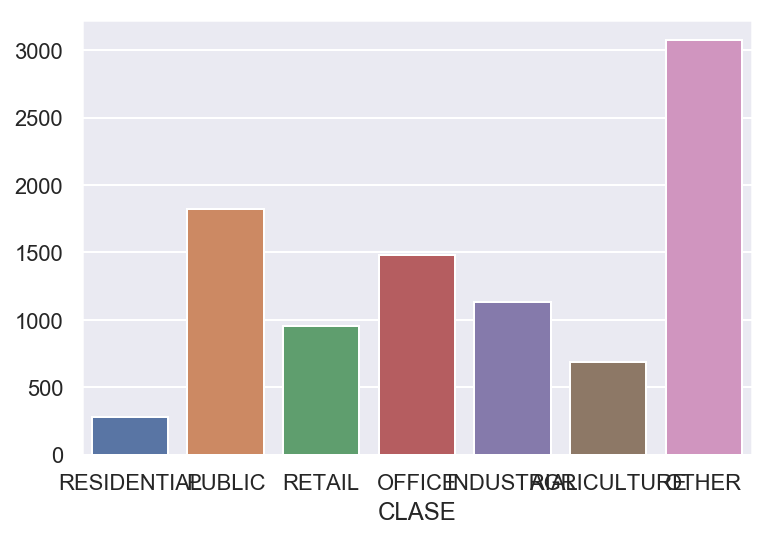

In [30]:
data = df_modelar.groupby('CLASE')['AREA'].mean()
sns.barplot(data.index, data.values, order=list_class_order)

In [112]:
df_modelar[df_modelar.AREA > 197028].CLASE

ID
AAE3529BAC652D71    RETAIL
Name: CLASE, dtype: object

In [108]:
df_modelar[df_modelar.AREA>2000].loc[:,'AREA':'GEOM_R4'].describe()

AREA      GEOM_R1      GEOM_R2      GEOM_R3      GEOM_R4
count    2912.000000  2912.000000  2912.000000  2912.000000  2912.000000
mean     5160.778482     0.403179     0.010845     0.010665     1.078918
std      7351.744658     0.171208     0.004694     0.004642     0.524417
min      2000.297753     0.015011     0.000840     0.000907     0.074779
25%      2432.491647     0.283315     0.007662     0.007434     0.786698
50%      3095.624756     0.379656     0.010500     0.010329     0.993409
75%      4930.784636     0.505164     0.013455     0.013229     1.232940
max    197028.469001     1.000000     0.055556     0.045583     7.241180

In [113]:
df_modelar[df_modelar.AREA>2000]['CLASE'].value_counts()

RESIDENTIAL    1047
PUBLIC          614
INDUSTRIAL      437
OTHER           350
OFFICE          296
RETAIL          144
AGRICULTURE      24
Name: CLASE, dtype: int64

RESIDENTIAL    1047
Name: CLASE, dtype: int64


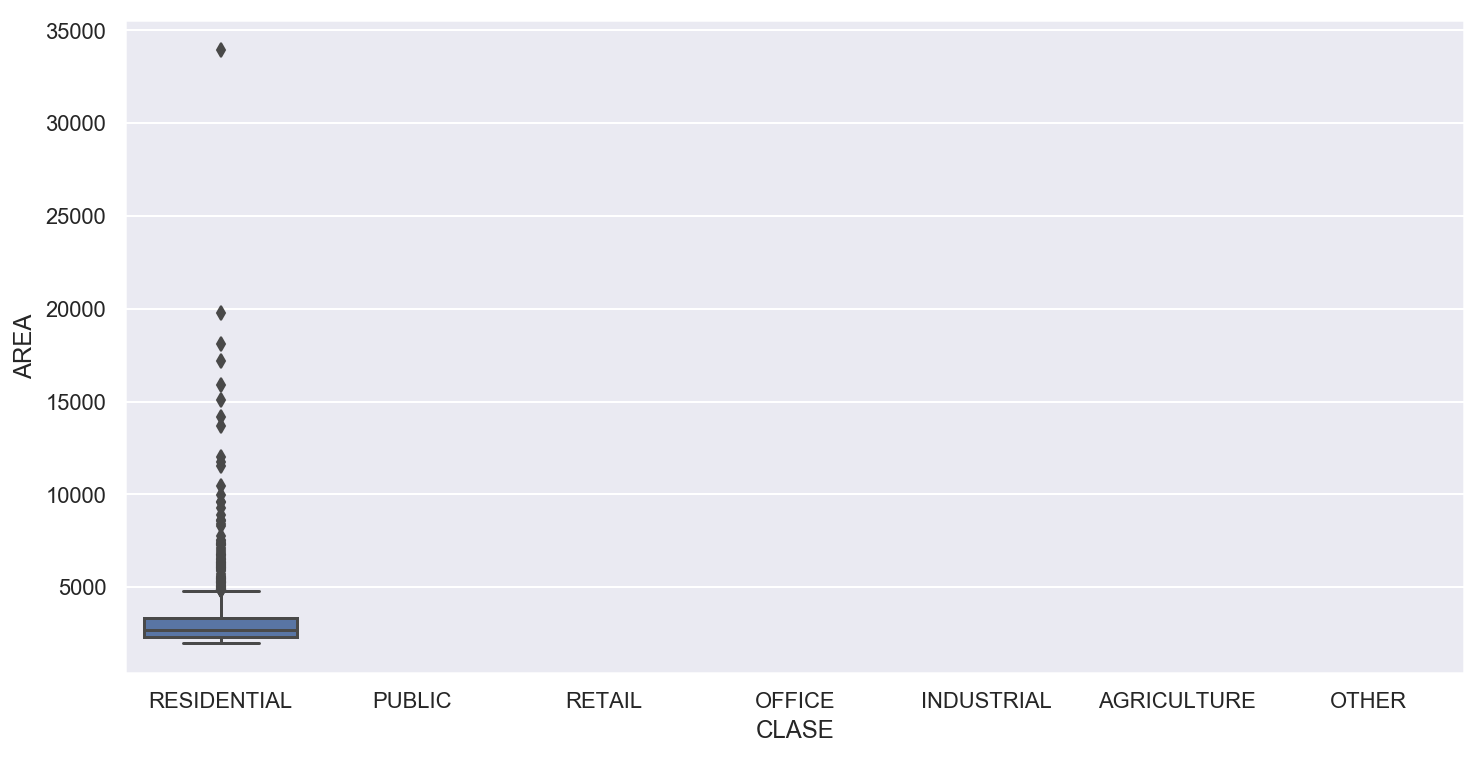

In [41]:
df_aux = df_modelar[(df_modelar.AREA>2000) & (df_modelar.CLASE=='RESIDENTIAL')].copy()
print(df_aux.CLASE.value_counts())
plt.figure(figsize=(12,6))
sns.boxplot(df_aux.CLASE, df_aux.AREA, order=list_class_order)

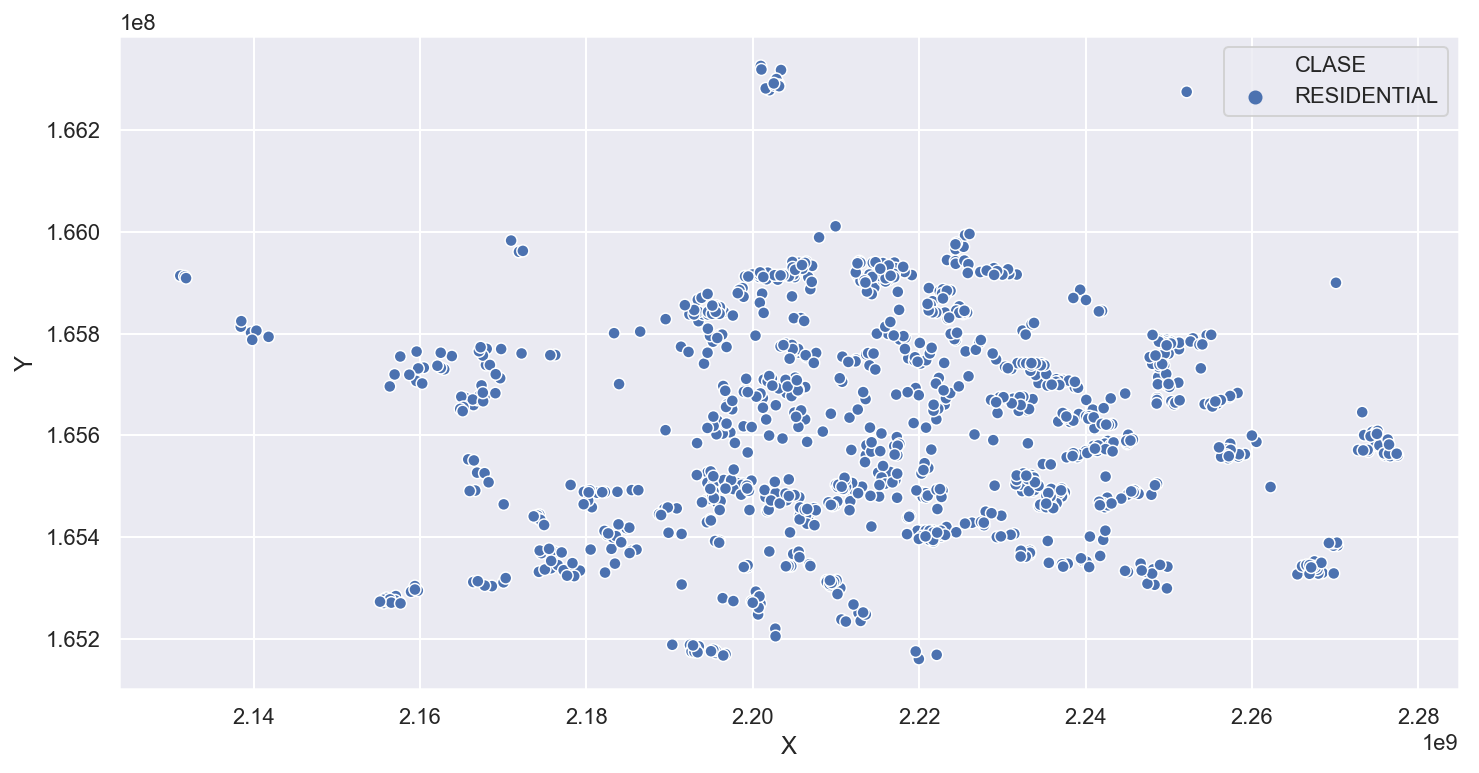

In [42]:
plt.figure(figsize=(12,6))
sns.scatterplot('X', 'Y', data=df_aux, hue='CLASE')

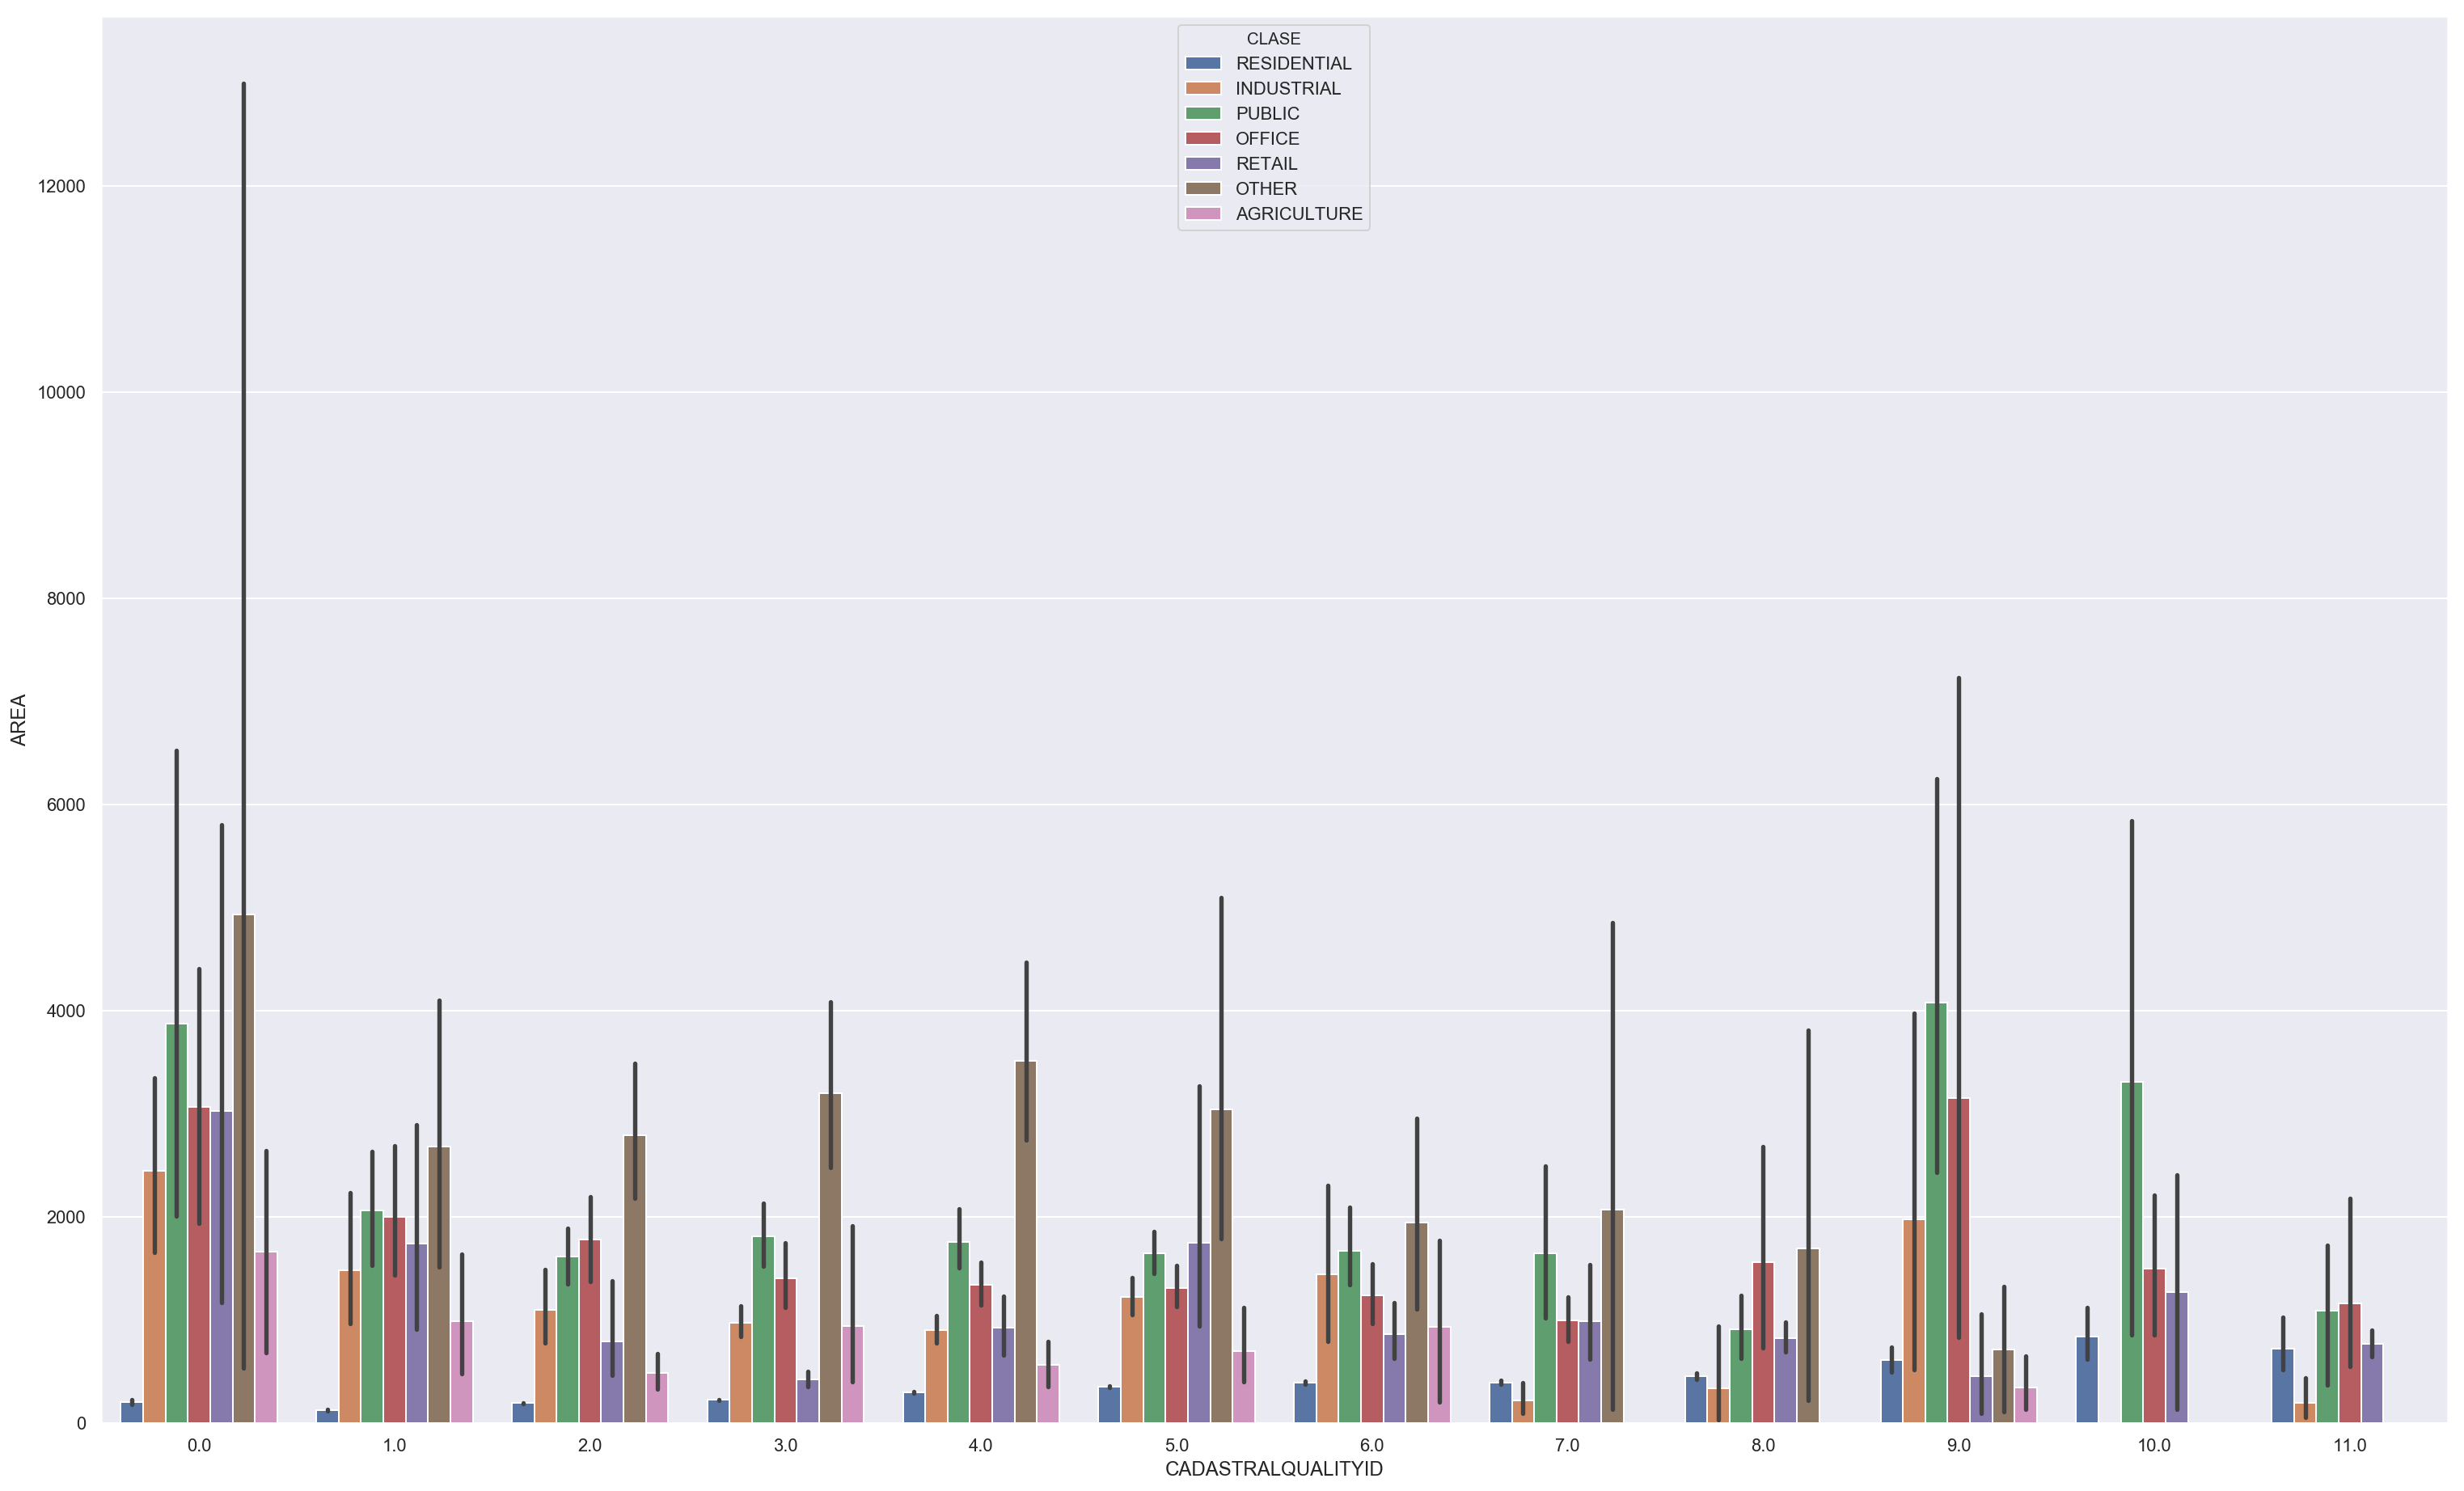

In [73]:
data = df_modelar.groupby('CADASTRALQUALITYID')['AREA'].mean()
plt.figure(figsize=(26,16))
sns.barplot(df_modelar.CADASTRALQUALITYID, df_modelar.AREA, hue=df_modelar['CLASE'])

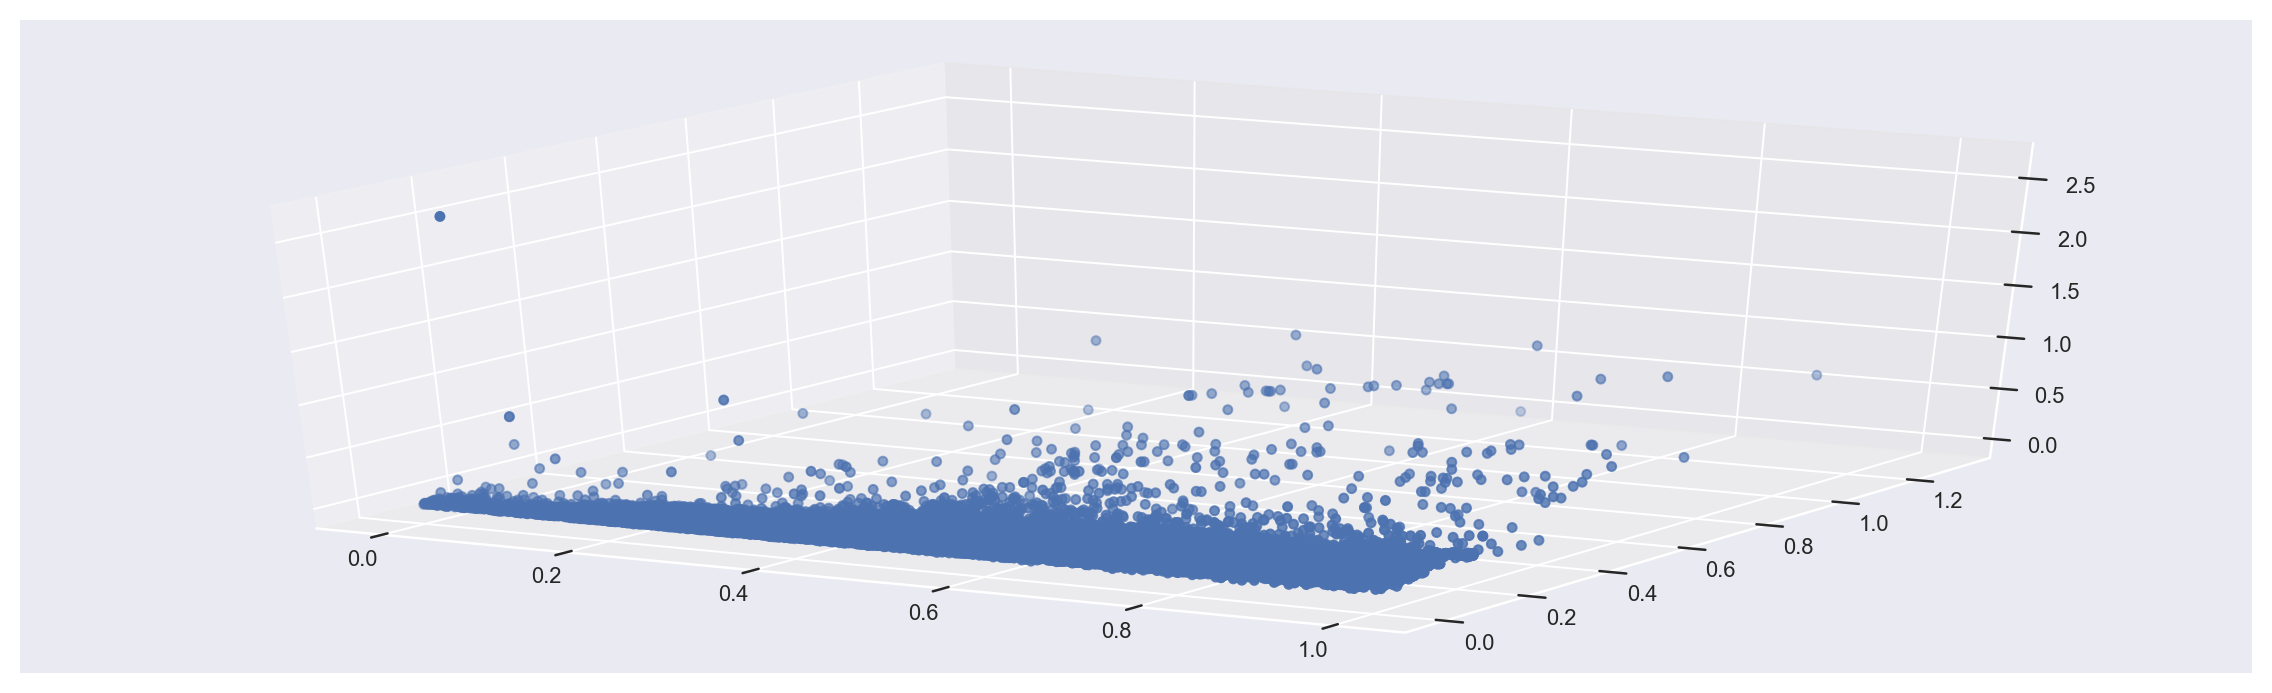

In [116]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_modelar.GEOM_R1, df_modelar.GEOM_R2, df_modelar.GEOM_R3);

In [119]:
import plotly.express as px
data = df_modelar[['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CLASE']].copy()
data['AREA'] = data['AREA']/data['AREA'].max()
data['GEOM_R1'] = data['GEOM_R1']/data['GEOM_R1'].max()
data['GEOM_R2'] = data['GEOM_R2']/data['GEOM_R2'].max()
data['GEOM_R3'] = data['GEOM_R3']/data['GEOM_R3'].max()
data['GEOM_R4'] = data['GEOM_R4']/data['GEOM_R4'].max()

In [125]:
df_modelar[['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4']].corr().style.background_gradient(cmap='coolwarm')

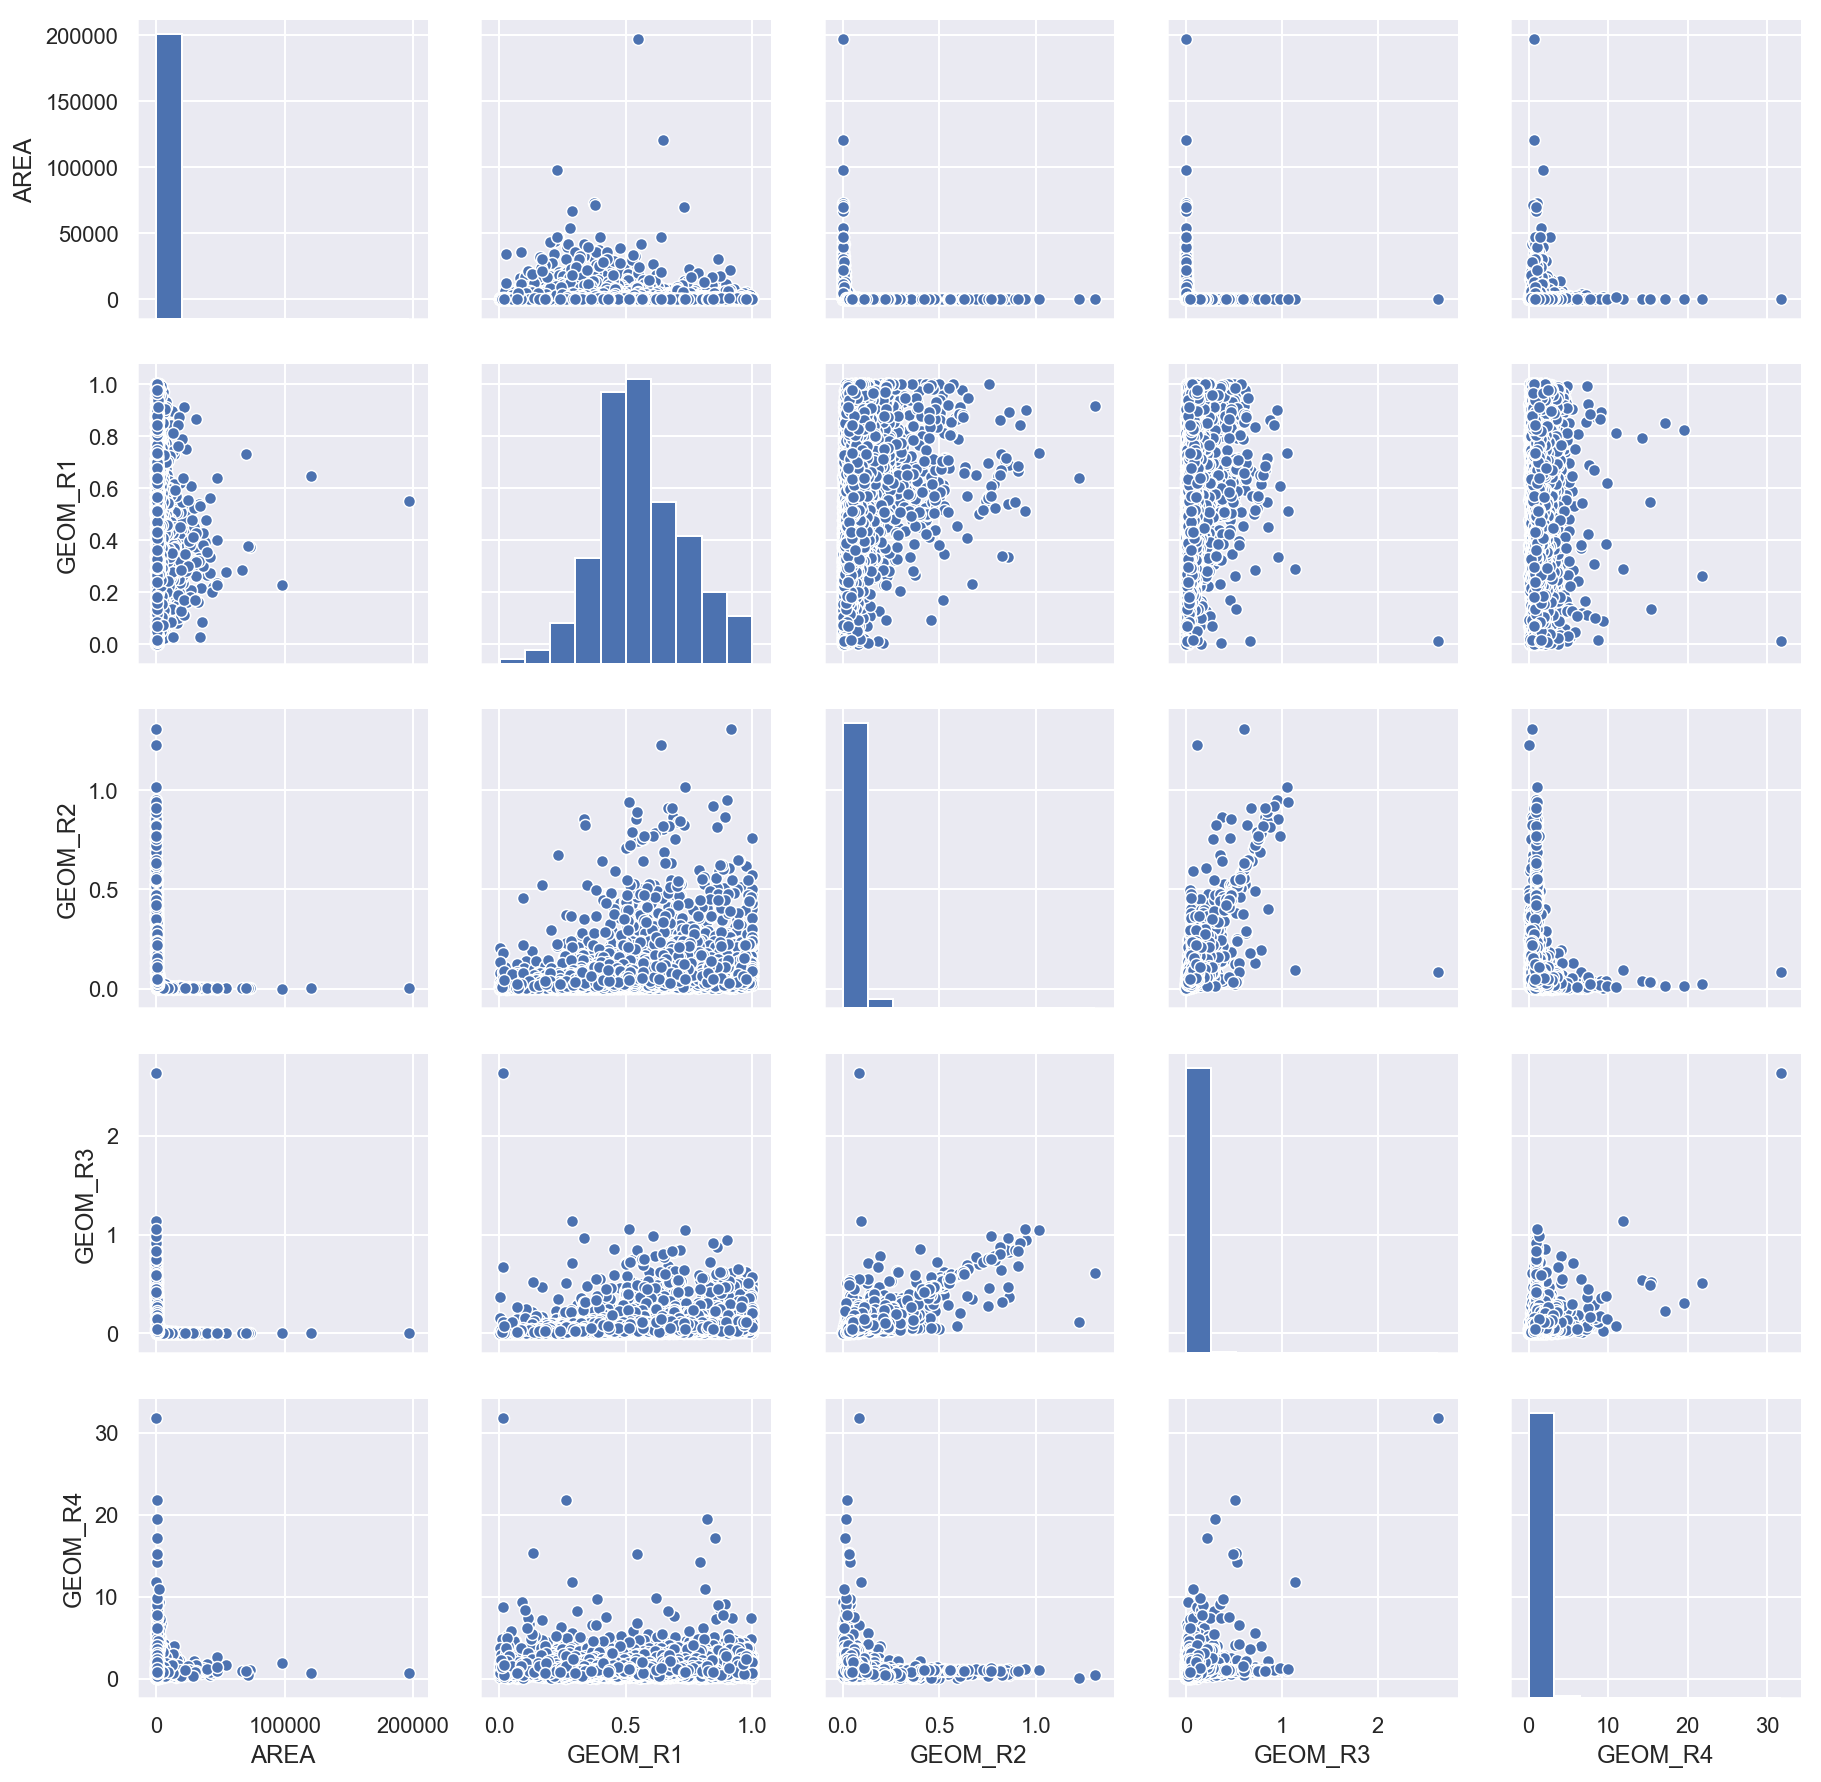

In [132]:
sns.pairplot(df_modelar[['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4']])

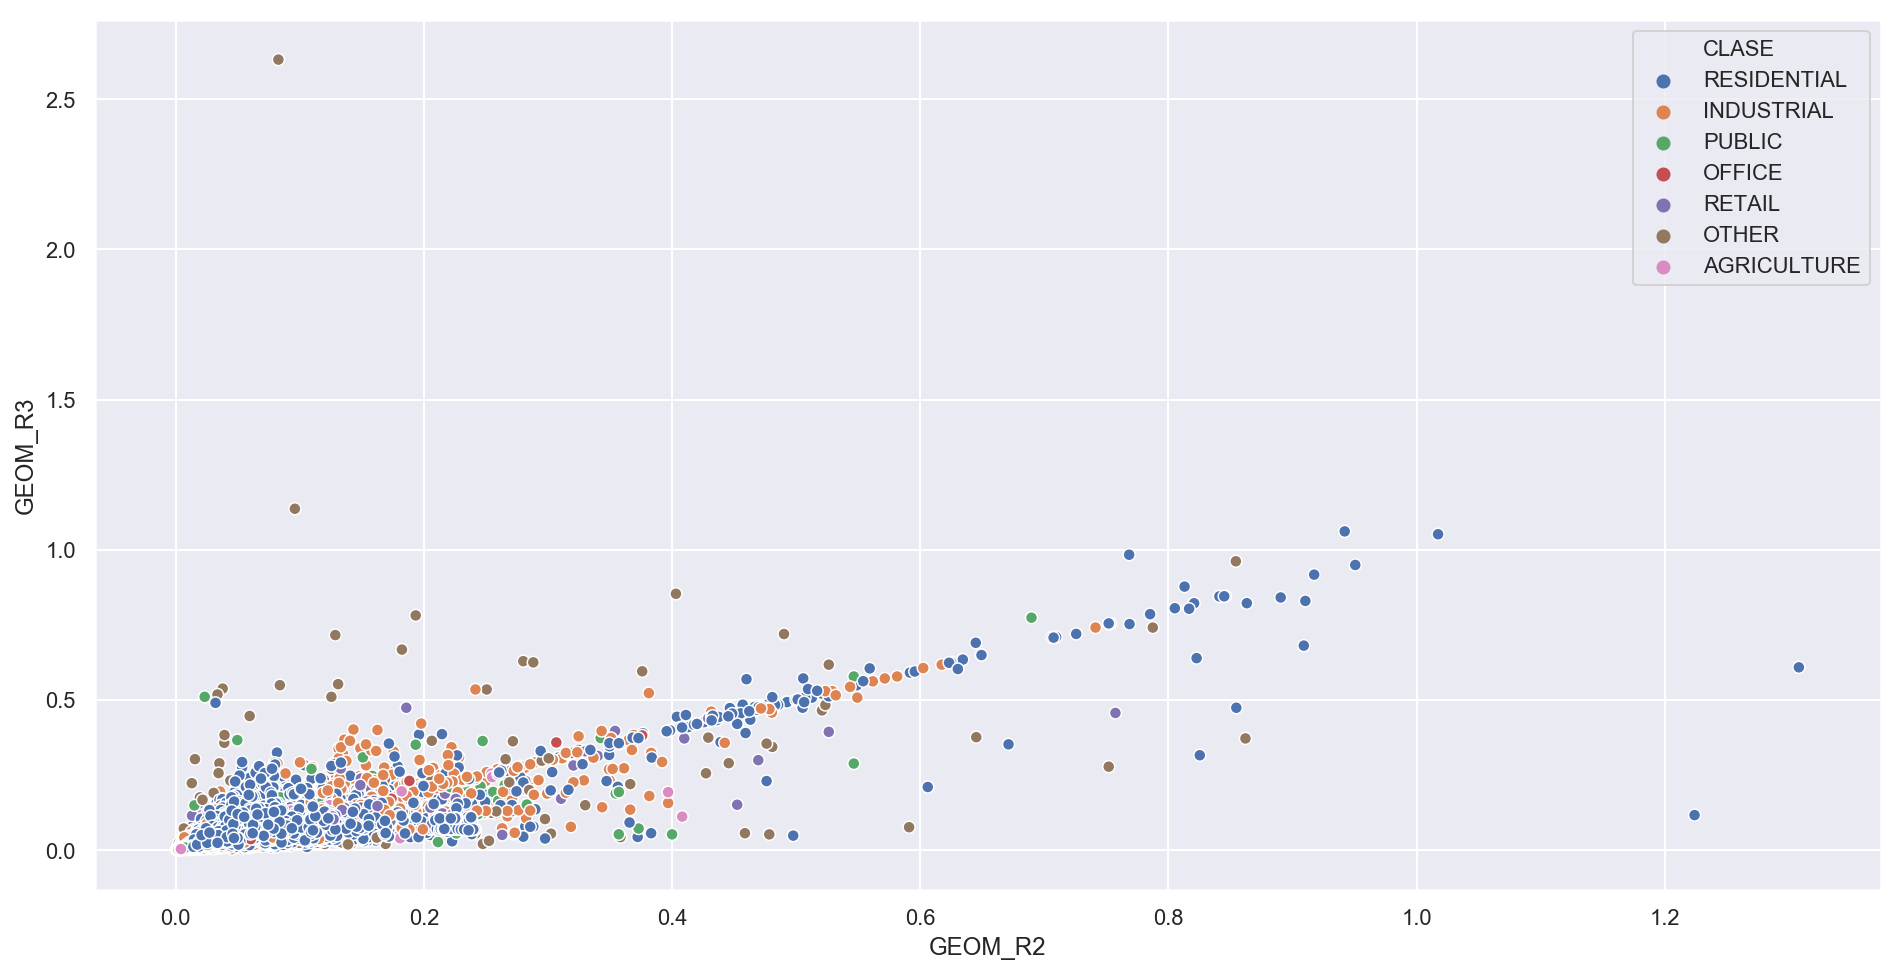

In [134]:
plt.figure(figsize=(16,8))
sns.scatterplot(df_modelar.GEOM_R2, df_modelar.GEOM_R3, hue=df_modelar.CLASE);

{'AGRICULTURE': 69, 'INDUSTRIAL': 953, 'OFFICE': 389, 'OTHER': 283, 'PUBLIC': 633, 'RESIDENTIAL': 19162, 'RETAIL': 445}


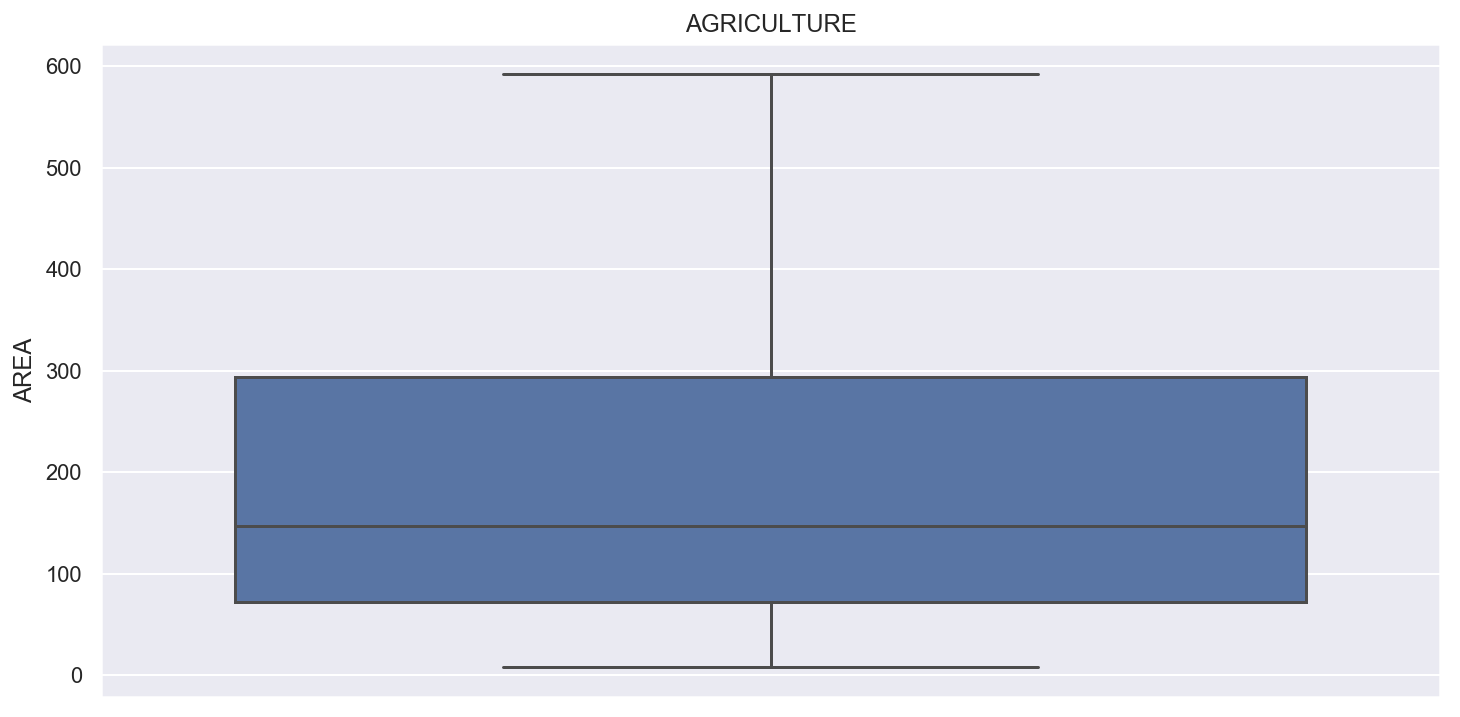

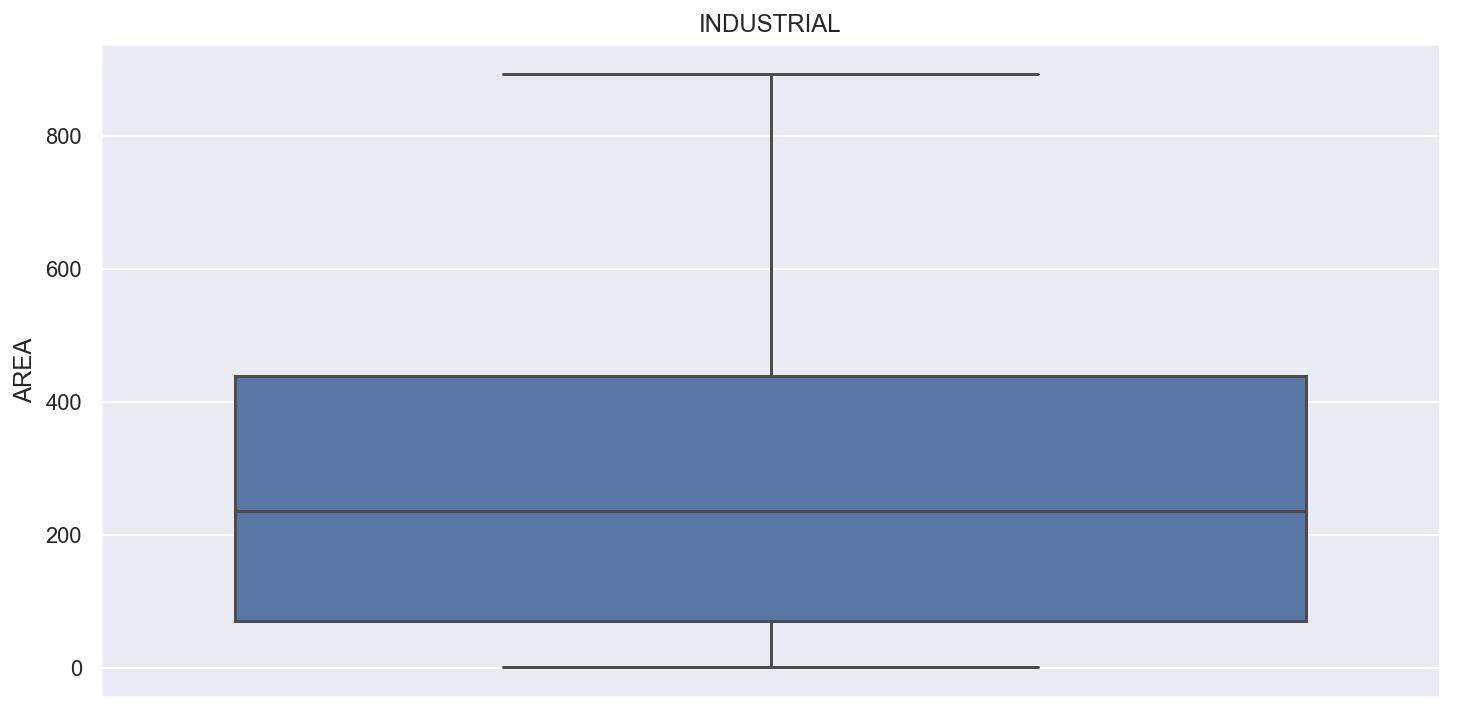

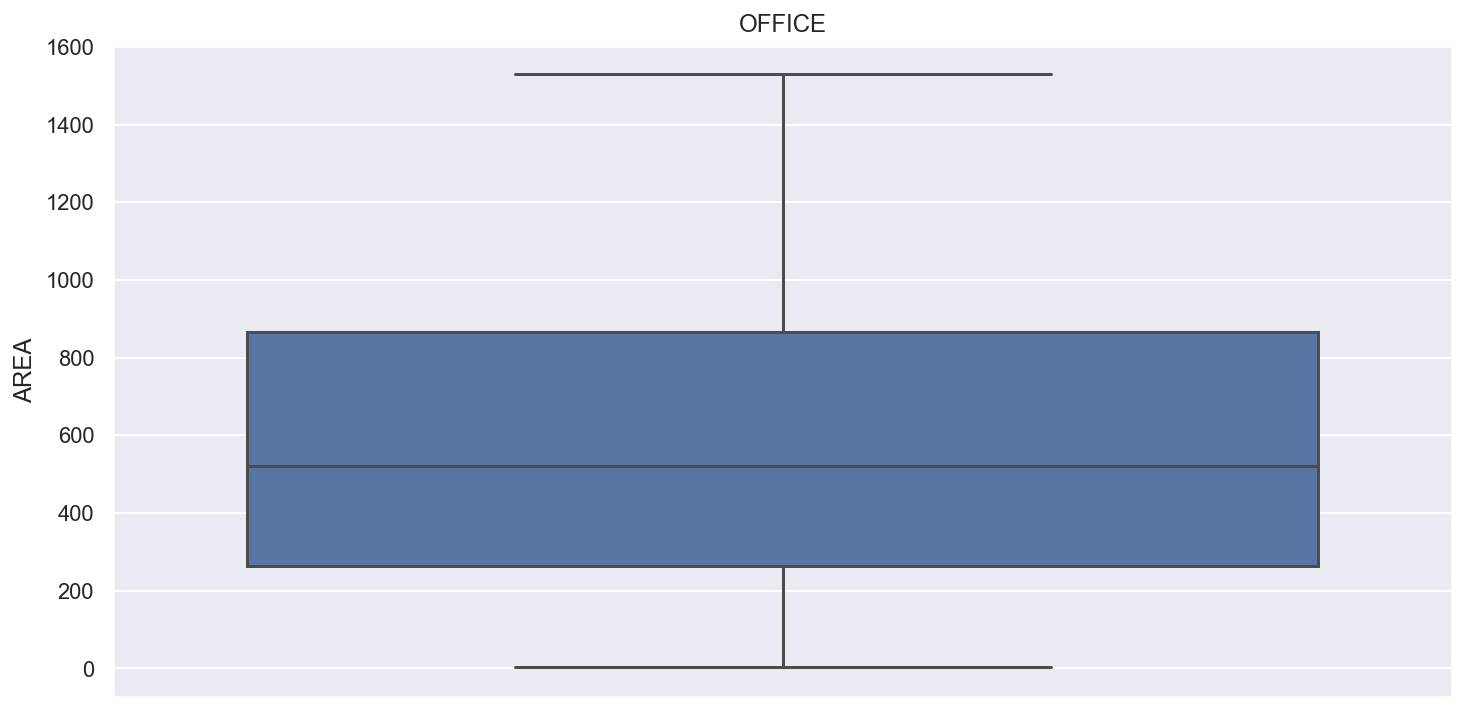

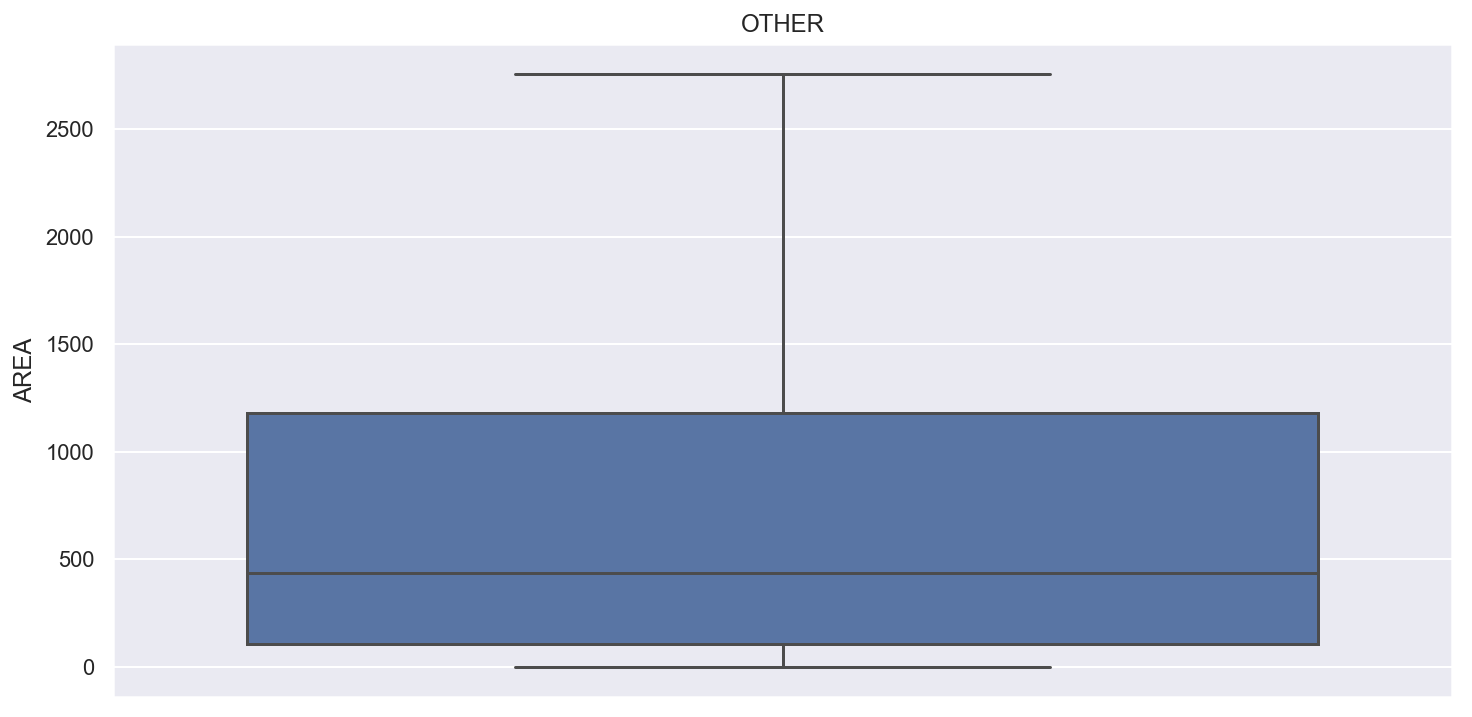

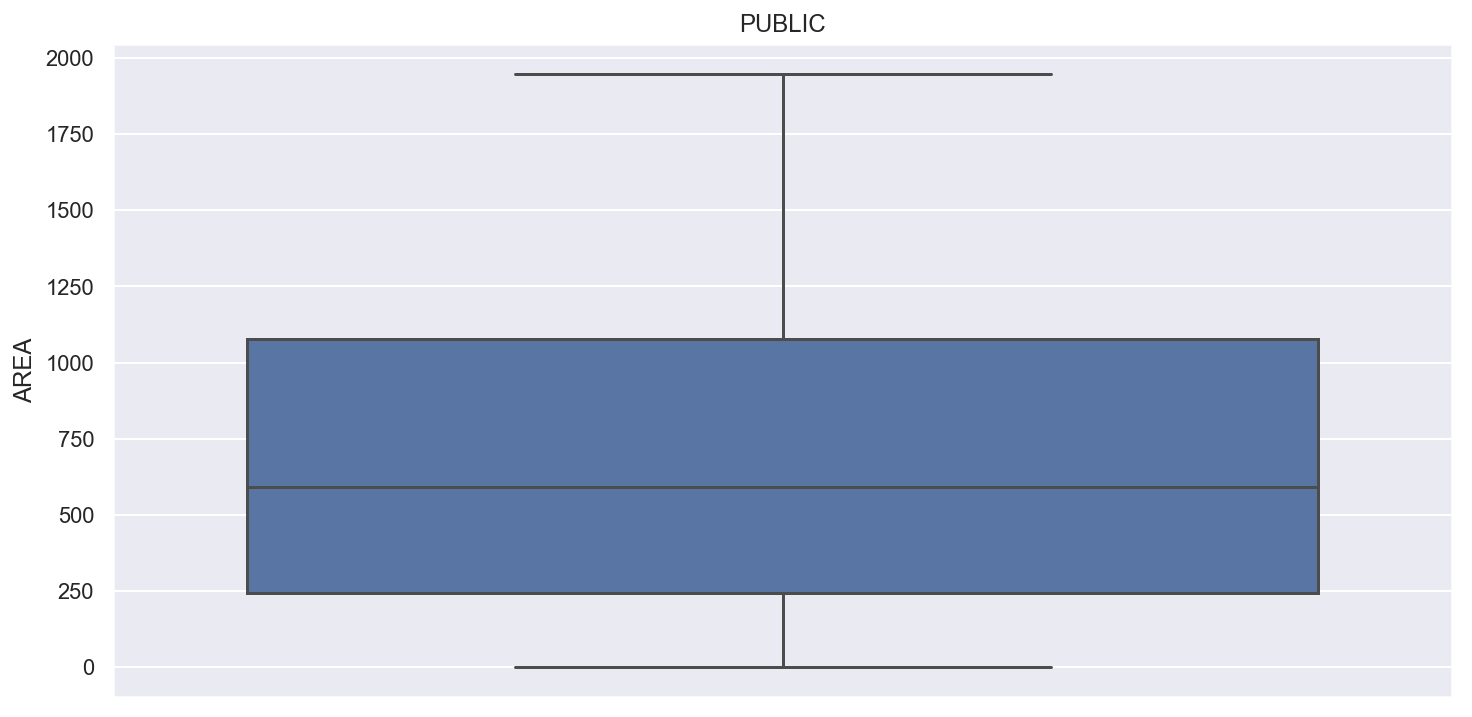

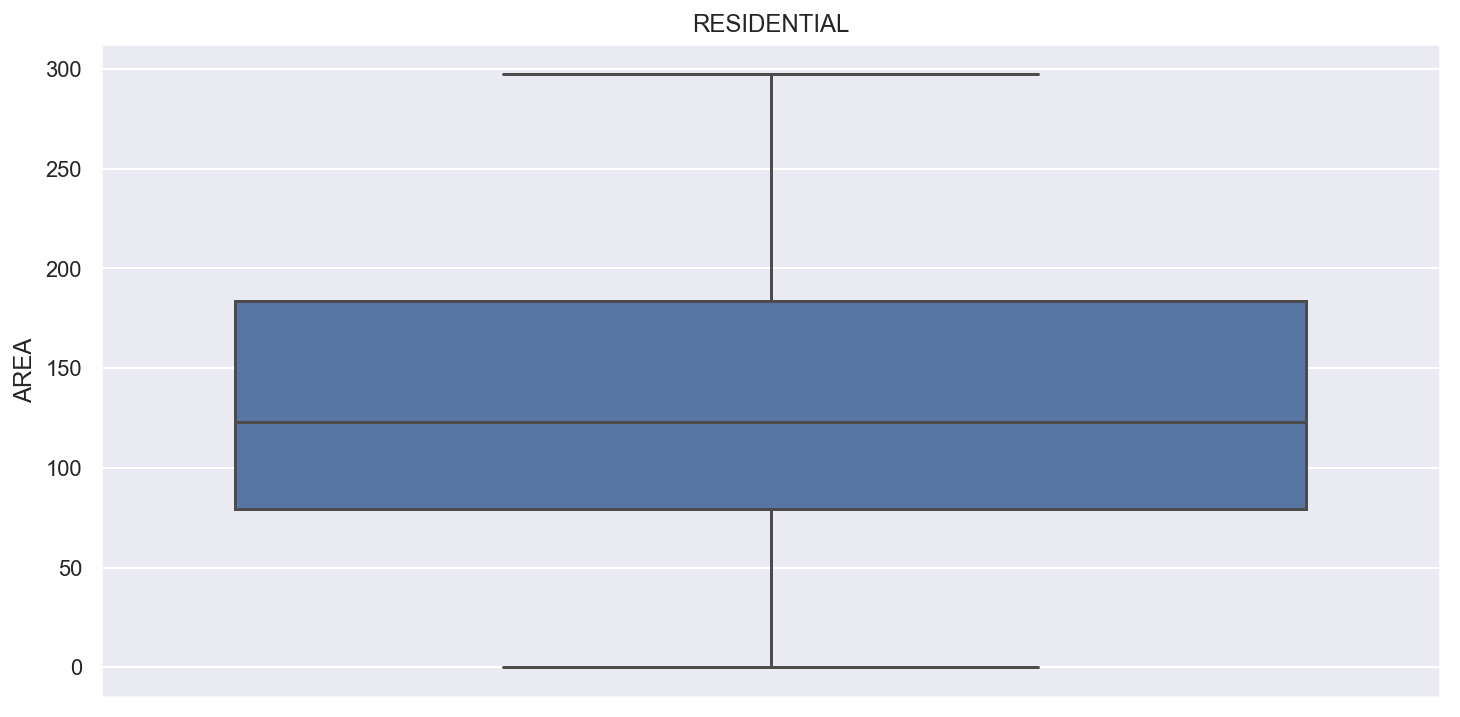

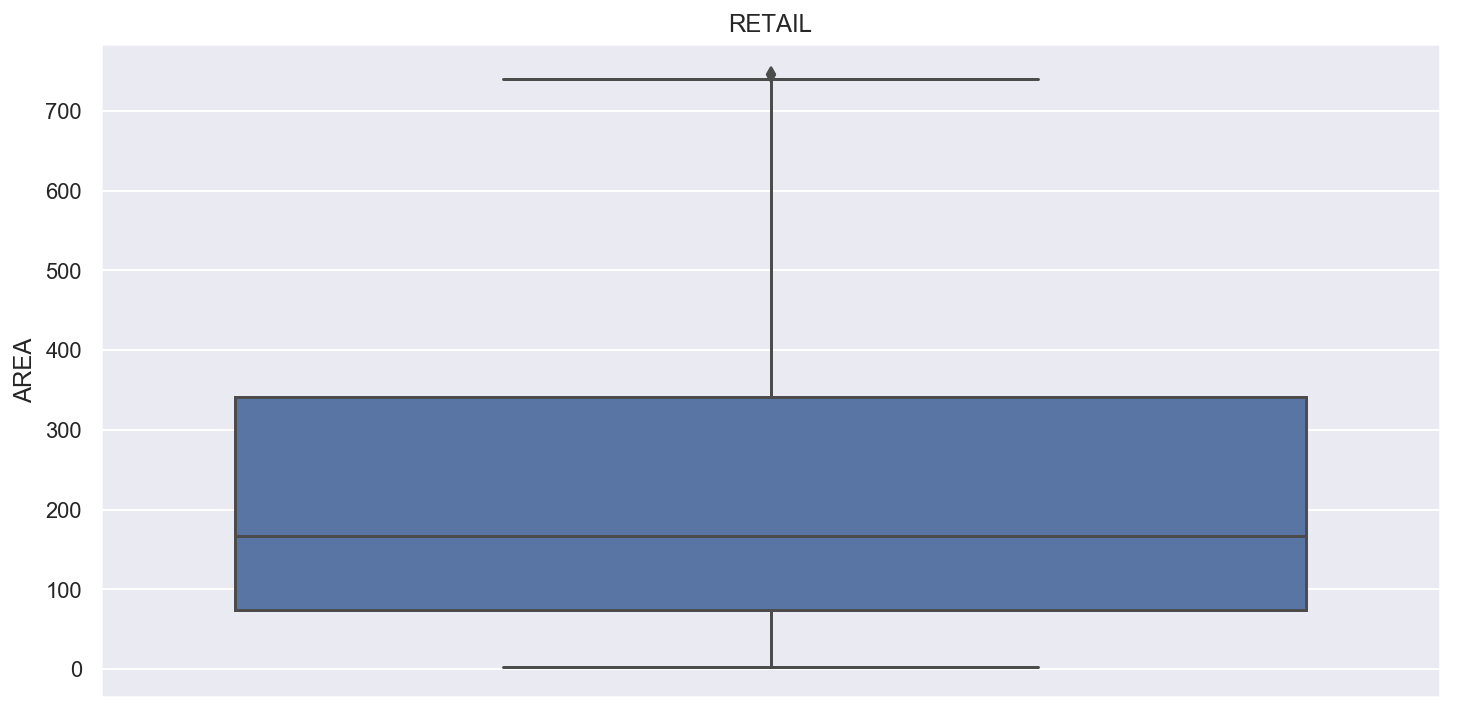

In [27]:
data = df_modelar.groupby('CLASE')
d = {}
aux_without_outliers = []
for name, group in data:
    plt.figure(figsize=(12,6))
    d[name] = len(group[group['AREA']> group['AREA'].quantile(0.75)])
    group = group[group['AREA']< group['AREA'].quantile(0.75)]
    aux_without_outliers.append(group.reset_index())
    sns.boxplot(group['AREA'], orient='vertical')
    plt.title(name)
print(d)

In [28]:
df_aux_without_outliers = pd.concat(aux_without_outliers).set_index('ID').sample(frac=1, random_state=10)

In [29]:
df_aux_without_outliers['CLASE'].value_counts()

RESIDENTIAL    57485
INDUSTRIAL      2859
PUBLIC          1897
RETAIL          1333
OFFICE          1165
OTHER            849
AGRICULTURE      205
Name: CLASE, dtype: int64

In [30]:
df_modelar[['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4']].describe()

AREA       GEOM_R1       GEOM_R2       GEOM_R3       GEOM_R4
count   87728.000000  87728.000000  87728.000000  87728.000000  87728.000000
mean      434.998807      0.563073      0.062461      0.061849      1.073786
std      1628.215131      0.173850      0.042416      0.042313      0.500394
min         0.038770      0.000626      0.000679      0.000907      0.074779
25%        97.457037      0.455073      0.038226      0.038081      0.801740
50%       171.862869      0.535942      0.055741      0.055036      0.997210
75%       344.556649      0.674505      0.078465      0.078021      1.223660
max    197028.469001      1.000000      1.308044      2.631579     31.789474

In [52]:
len(df_aux_without_outliers[df_aux_without_outliers['GEOM_R4']> df_aux_without_outliers['GEOM_R4'].quantile(0.75)])

16448

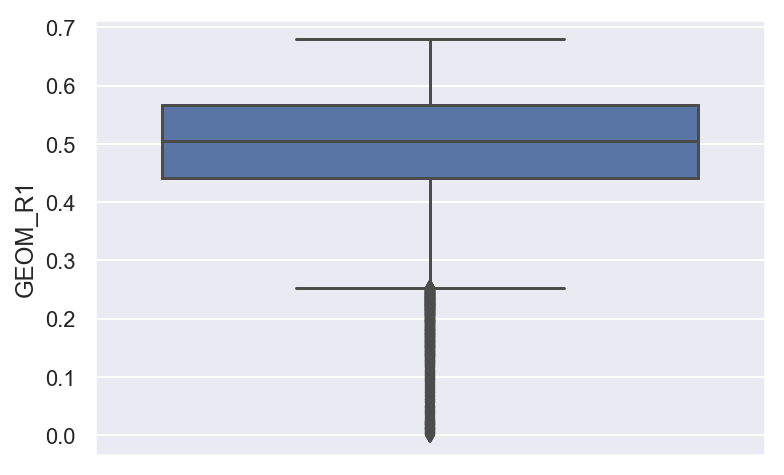

In [46]:
sns.boxplot(df_aux_without_outliers[df_aux_without_outliers['GEOM_R1']< df_aux_without_outliers['GEOM_R1'].quantile(0.75)]['GEOM_R1'], orient='v')

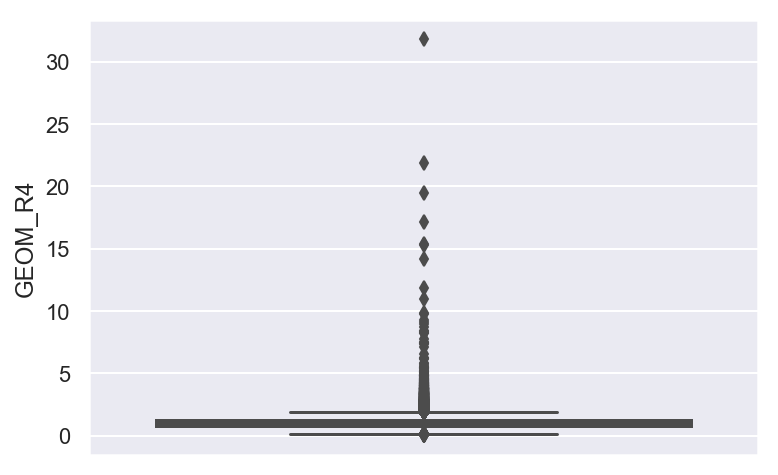

In [49]:
sns.boxplot(df_aux_without_outliers['GEOM_R4'], orient='v')

# Modelos

In [89]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])

#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, df_aux_without_outliers.select_dtypes(include=np.number).columns.tolist())])

In [90]:
df_aux_without_outliers['SUBCLASE'] = (df_aux_without_outliers['CLASE'] == 'RESIDENTIAL').astype(int)

In [91]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_aux_without_outliers.drop(columns=['CLASE', 'SUBCLASE']).copy()
y = df_aux_without_outliers['SUBCLASE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [92]:
X_train.columns

Index(['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3',
       'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8',
       'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2',
       'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7',
       'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1',
       'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5',
       'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9',
       'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
       'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'distance_to_center', 'N_AGRICULTURE', 'N_INDUSTRIAL', 'N_OFFICE',
       'N_OTHER', 'N_PUBLIC', 'N_RESIDENTIAL', 'N_RETAIL', 'mean_red',
       'mean_green', 'mean_blue', 'mean_nir', 'std_red', 'std_green',
 

In [97]:
import xgboost as xgb
rfc_p_model = xgb.XGBClassifier(random_state=10)
underSampling = RandomUnderSampler('majority', random_state=10)
smote = SMOTE('minority', random_state=10)

parameters = {
    'clas__max_depth': [10, 20],
    'clas__n_estimators': [100, 200]
}

minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('smt', smote), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  2.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.4min finished


Mejor score:  0.9810916632221505
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__n_estimators': 200}


In [95]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

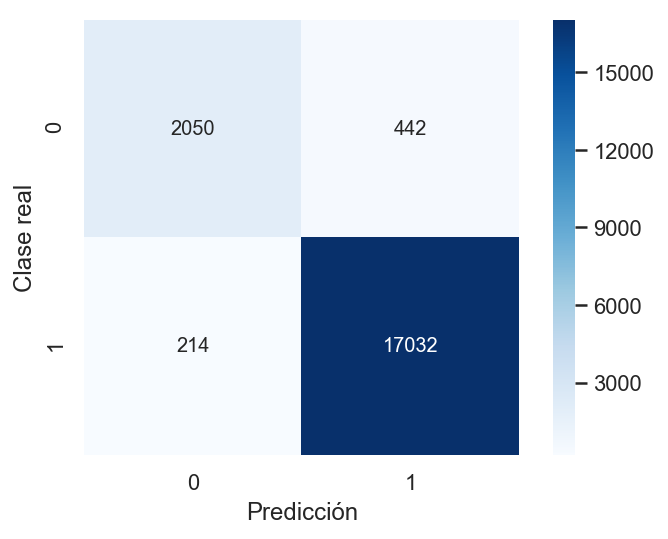

Resultados
Accuracy: 0.967


In [102]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
show_results(y_test, y_pred)

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2492
           1       0.97      0.99      0.98     17246

    accuracy                           0.97     19738
   macro avg       0.94      0.91      0.92     19738
weighted avg       0.97      0.97      0.97     19738



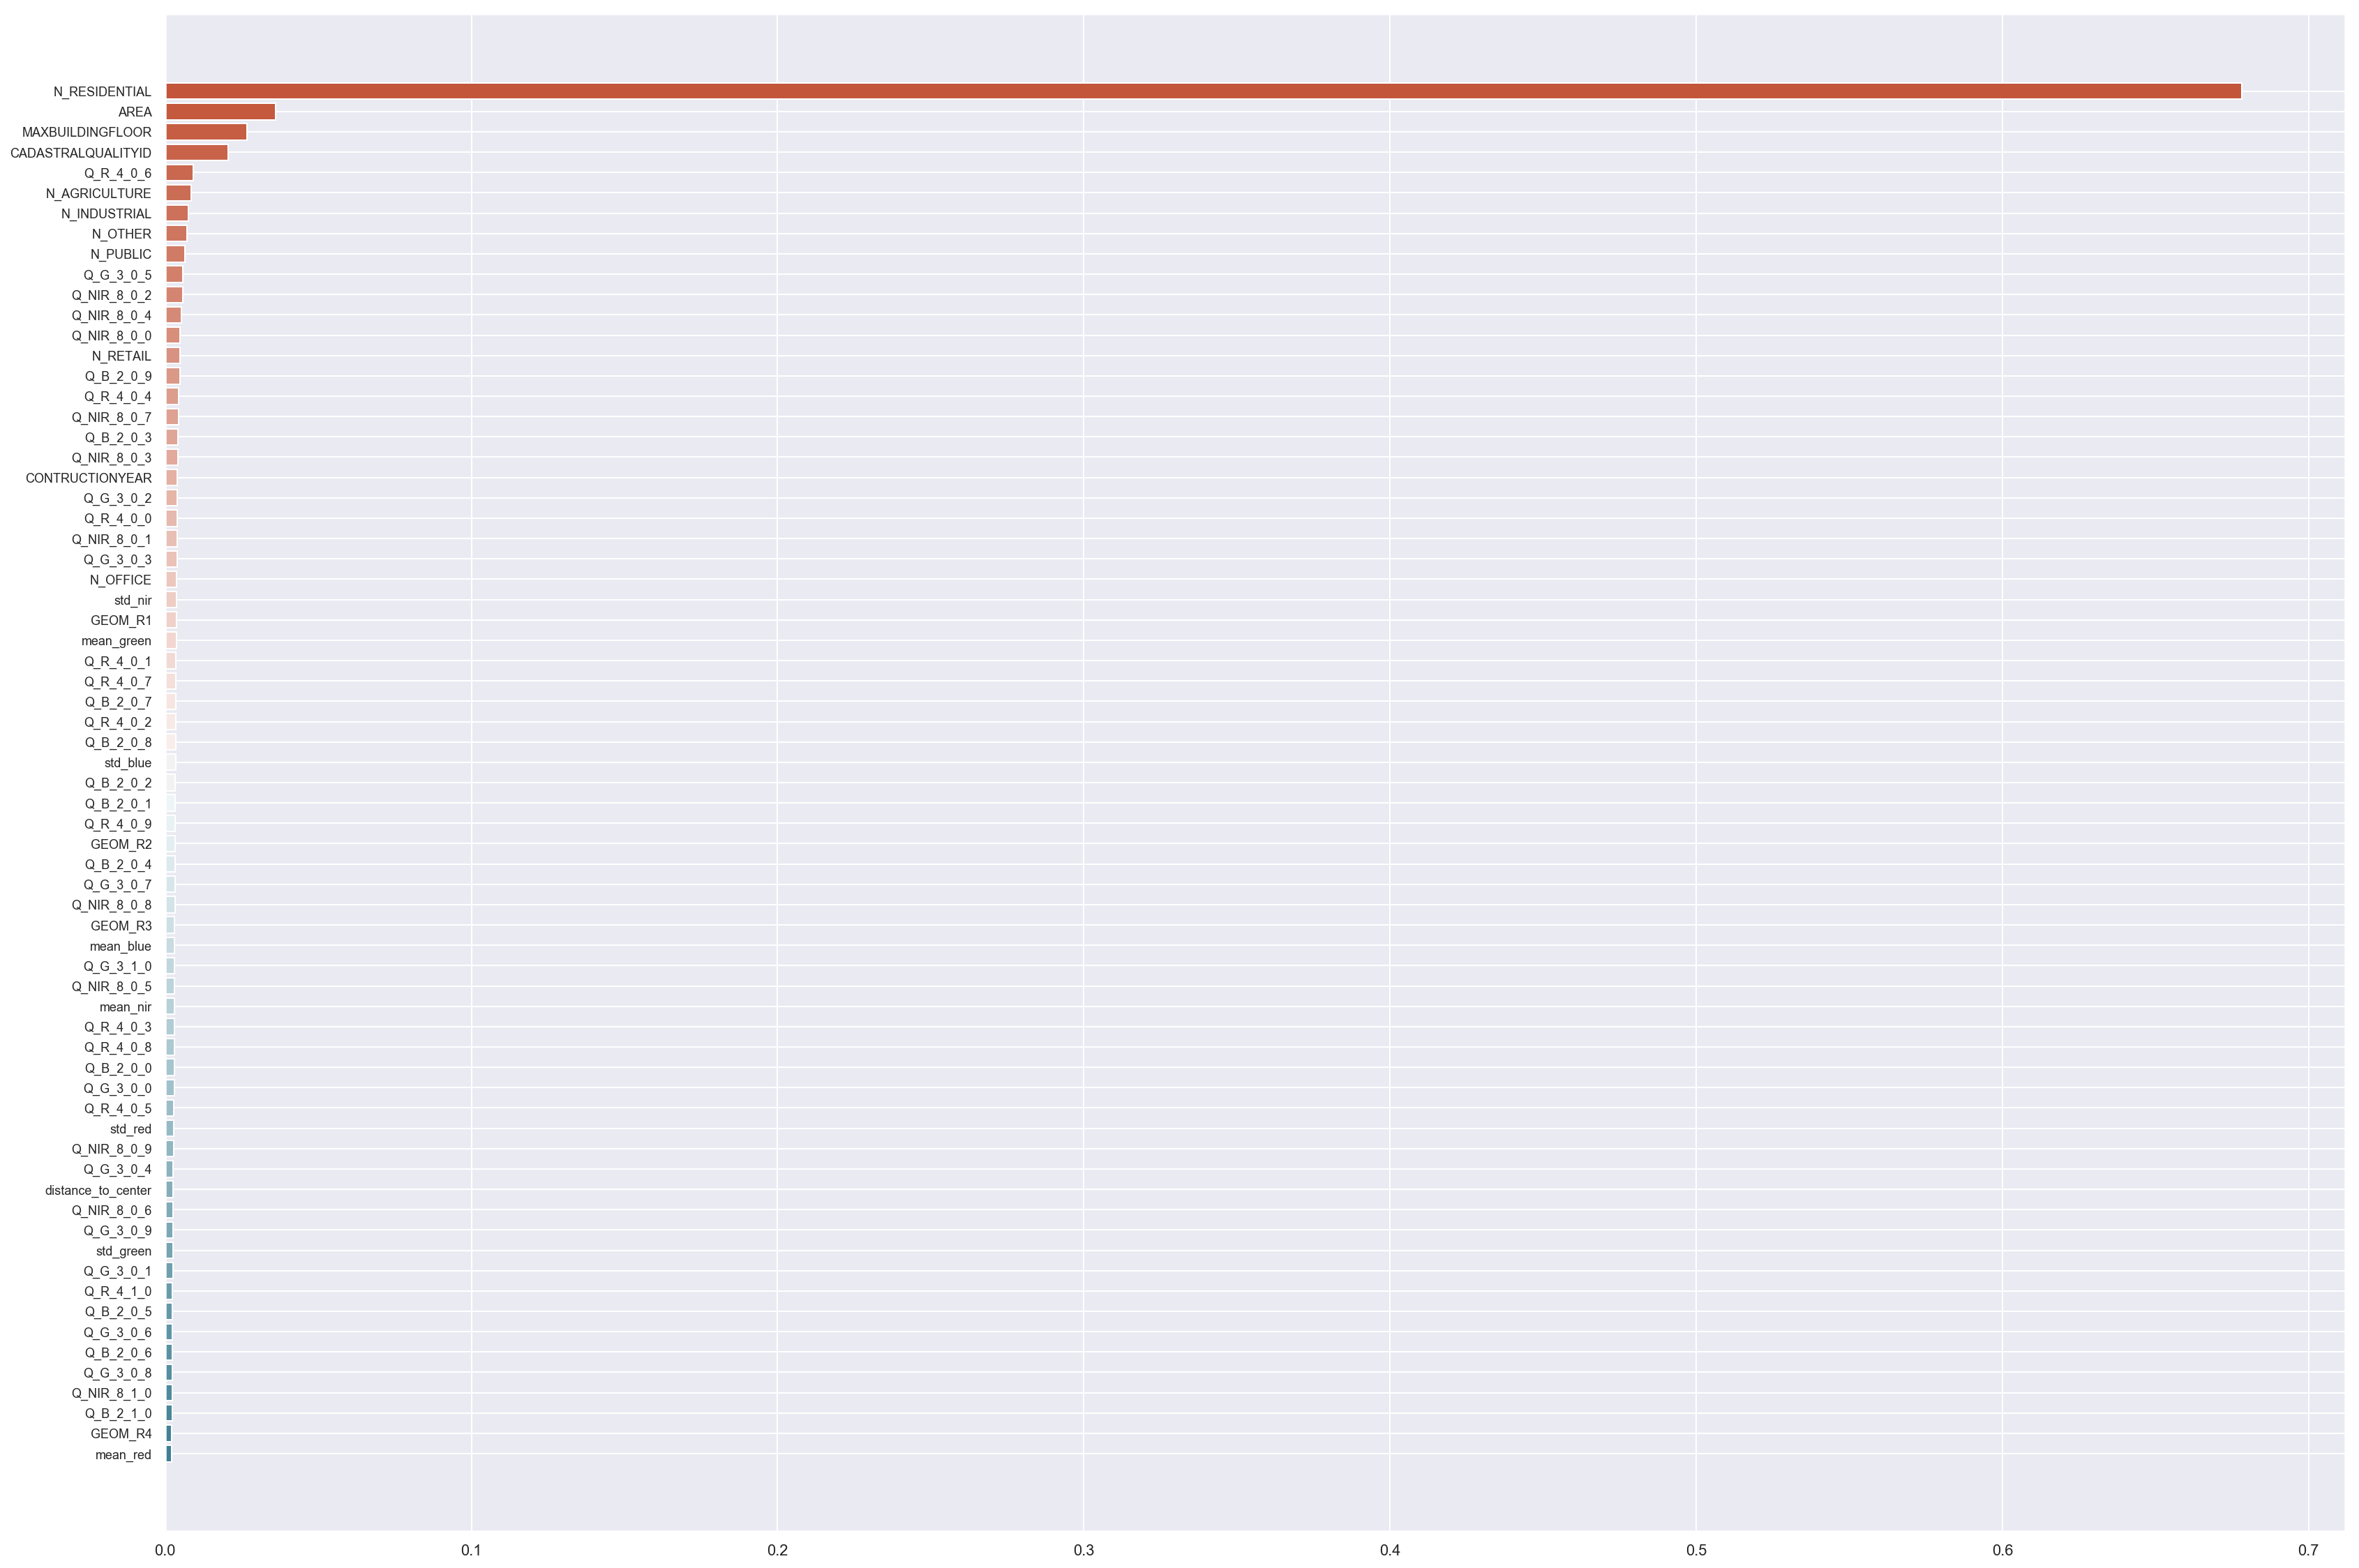

In [100]:
importances = minsait_pipe_rfc_p['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_aux_without_outliers.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=len(importances)),align='center')
plt.yticks(range(df_aux_without_outliers.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [104]:
import pickle
pickle.dump(minsait_pipe_rfc_p, open('binary_xgboost_CCG.model', 'wb'))

---

# MULTIETIQUETA

In [105]:
y_pred_train = minsait_pipe_rfc_p.predict(X_train)

In [106]:
X_multi = df_aux_without_outliers.loc[X_train[y_pred_train==0].index.tolist()].drop(columns=['CLASE', 'SUBCLASE']).copy()
y_multi = df_aux_without_outliers.loc[X_train[y_pred_train==0].index.tolist()]['CLASE'].copy()

In [107]:
y_multi.value_counts()

INDUSTRIAL     2014
PUBLIC         1328
RETAIL          900
OFFICE          805
OTHER           574
AGRICULTURE     133
RESIDENTIAL       4
Name: CLASE, dtype: int64

In [109]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=10)
#smt = SMOTE('not majority', random_state=10)

In [110]:
X_train_multi.columns

Index(['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3',
       'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8',
       'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2',
       'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7',
       'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1',
       'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5',
       'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9',
       'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
       'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'distance_to_center', 'N_AGRICULTURE', 'N_INDUSTRIAL', 'N_OFFICE',
       'N_OTHER', 'N_PUBLIC', 'N_RESIDENTIAL', 'N_RETAIL', 'mean_red',
       'mean_green', 'mean_blue', 'mean_nir', 'std_red', 'std_green',
 

In [111]:
y_train_multi.value_counts()

INDUSTRIAL     1391
PUBLIC          933
RETAIL          641
OFFICE          571
OTHER           404
AGRICULTURE      88
RESIDENTIAL       2
Name: CLASE, dtype: int64

In [112]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = RandomForestClassifier(random_state=10)
#model = BalancedRandomForestClassifier(random_state=10, sampling_strategy='majority')

parameters = {}
parameters['clas__max_depth'] = [5, 10, 20] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                            # Lo forzamos a ponerle profundidad, como máximo 20, aunque se podría establecer mayor profundidad pero no queremos que sobreajute a los datos del train.
parameters['clas__n_estimators'] = [100, 200]
#parameters['clas__class_weight'] = ['balanced']

pipe = Pipeline(steps=[('prep', df_minsait_trans),('clas', model)])
GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train_multi, y_train_multi)
print(f"Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

model_multilabel = GS.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished


Mejor score:  0.8873449131513647
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__n_estimators': 200}


In [113]:
y_pred_multi = model_multilabel.predict(X_test_multi)
print(classification_report(y_test_multi, y_pred_multi))

              precision    recall  f1-score   support

 AGRICULTURE       0.92      0.78      0.84        45
  INDUSTRIAL       0.87      0.96      0.91       623
      OFFICE       0.87      0.80      0.83       234
       OTHER       0.97      0.84      0.90       170
      PUBLIC       0.90      0.91      0.90       395
 RESIDENTIAL       0.00      0.00      0.00         2
      RETAIL       0.92      0.84      0.88       259

    accuracy                           0.89      1728
   macro avg       0.78      0.73      0.75      1728
weighted avg       0.89      0.89      0.89      1728



In [114]:
print(confusion_matrix(y_test_multi, y_pred_multi))

[[ 35  10   0   0   0   0   0]
 [  2 598   8   1   7   0   7]
 [  0  31 188   1  11   0   3]
 [  0  11   0 142  13   0   4]
 [  0  16  15   0 359   0   5]
 [  0   0   0   0   1   0   1]
 [  1  25   6   2   8   0 217]]


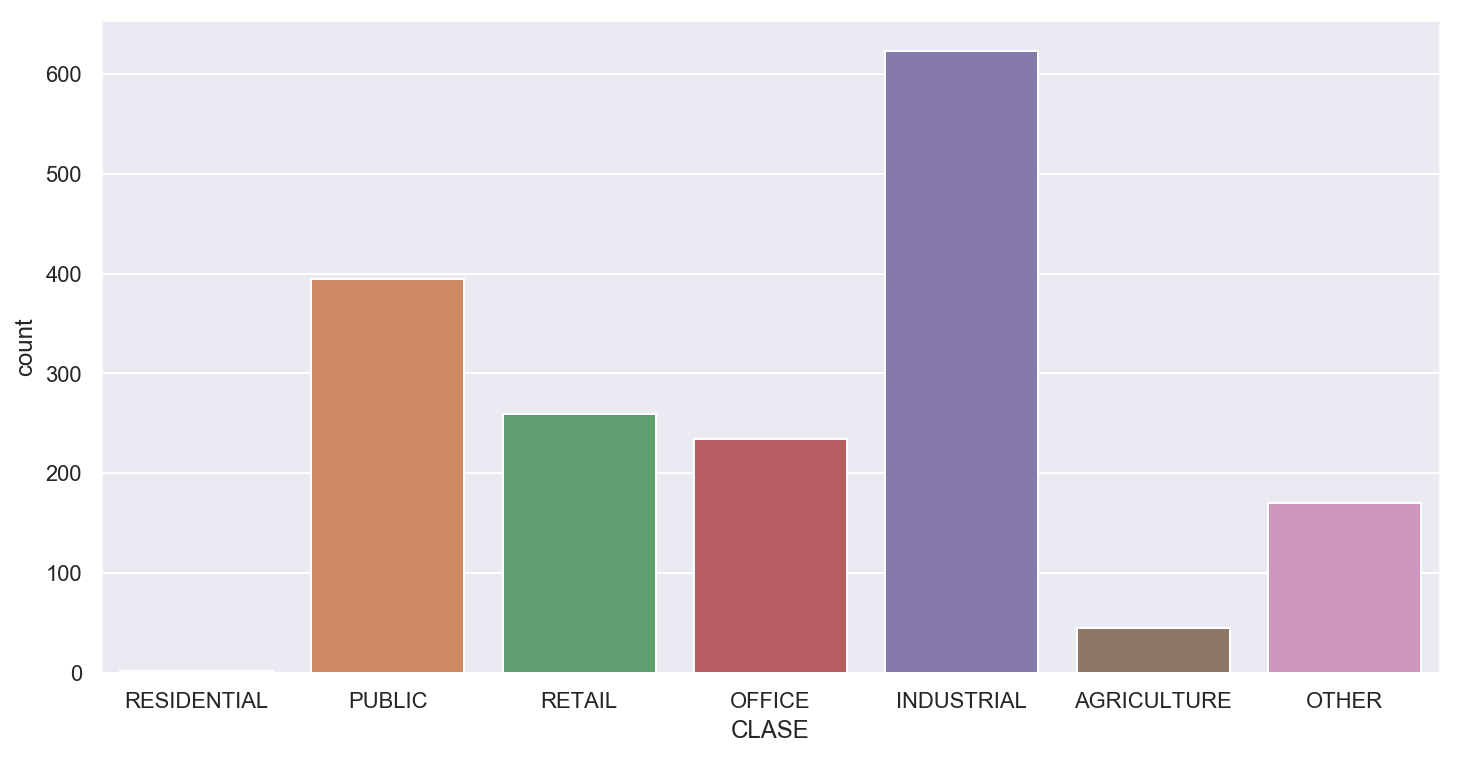

In [119]:
plt.figure(figsize=(12,6))
sns.countplot(y_test_multi, order=list_class_order);

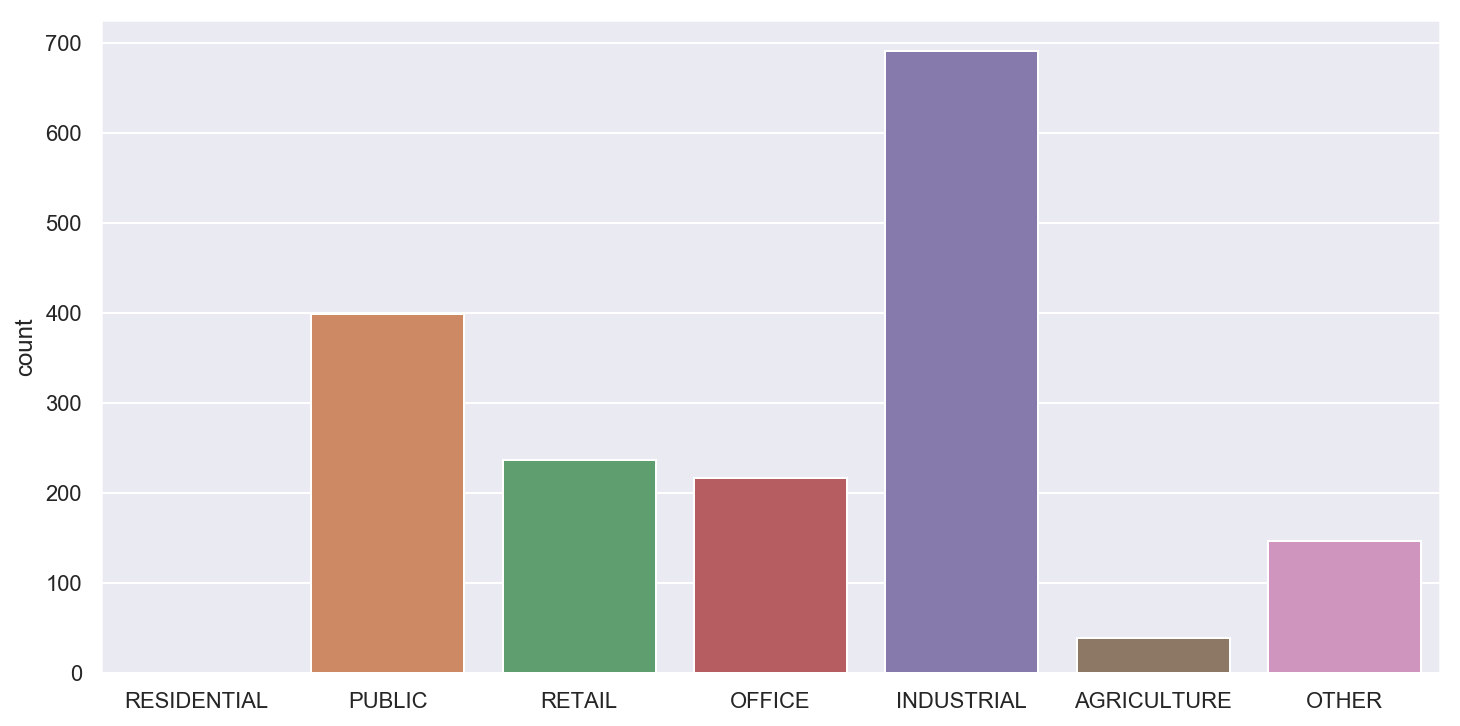

In [115]:
plt.figure(figsize=(12,6))
sns.countplot(y_pred_multi, order=list_class_order);

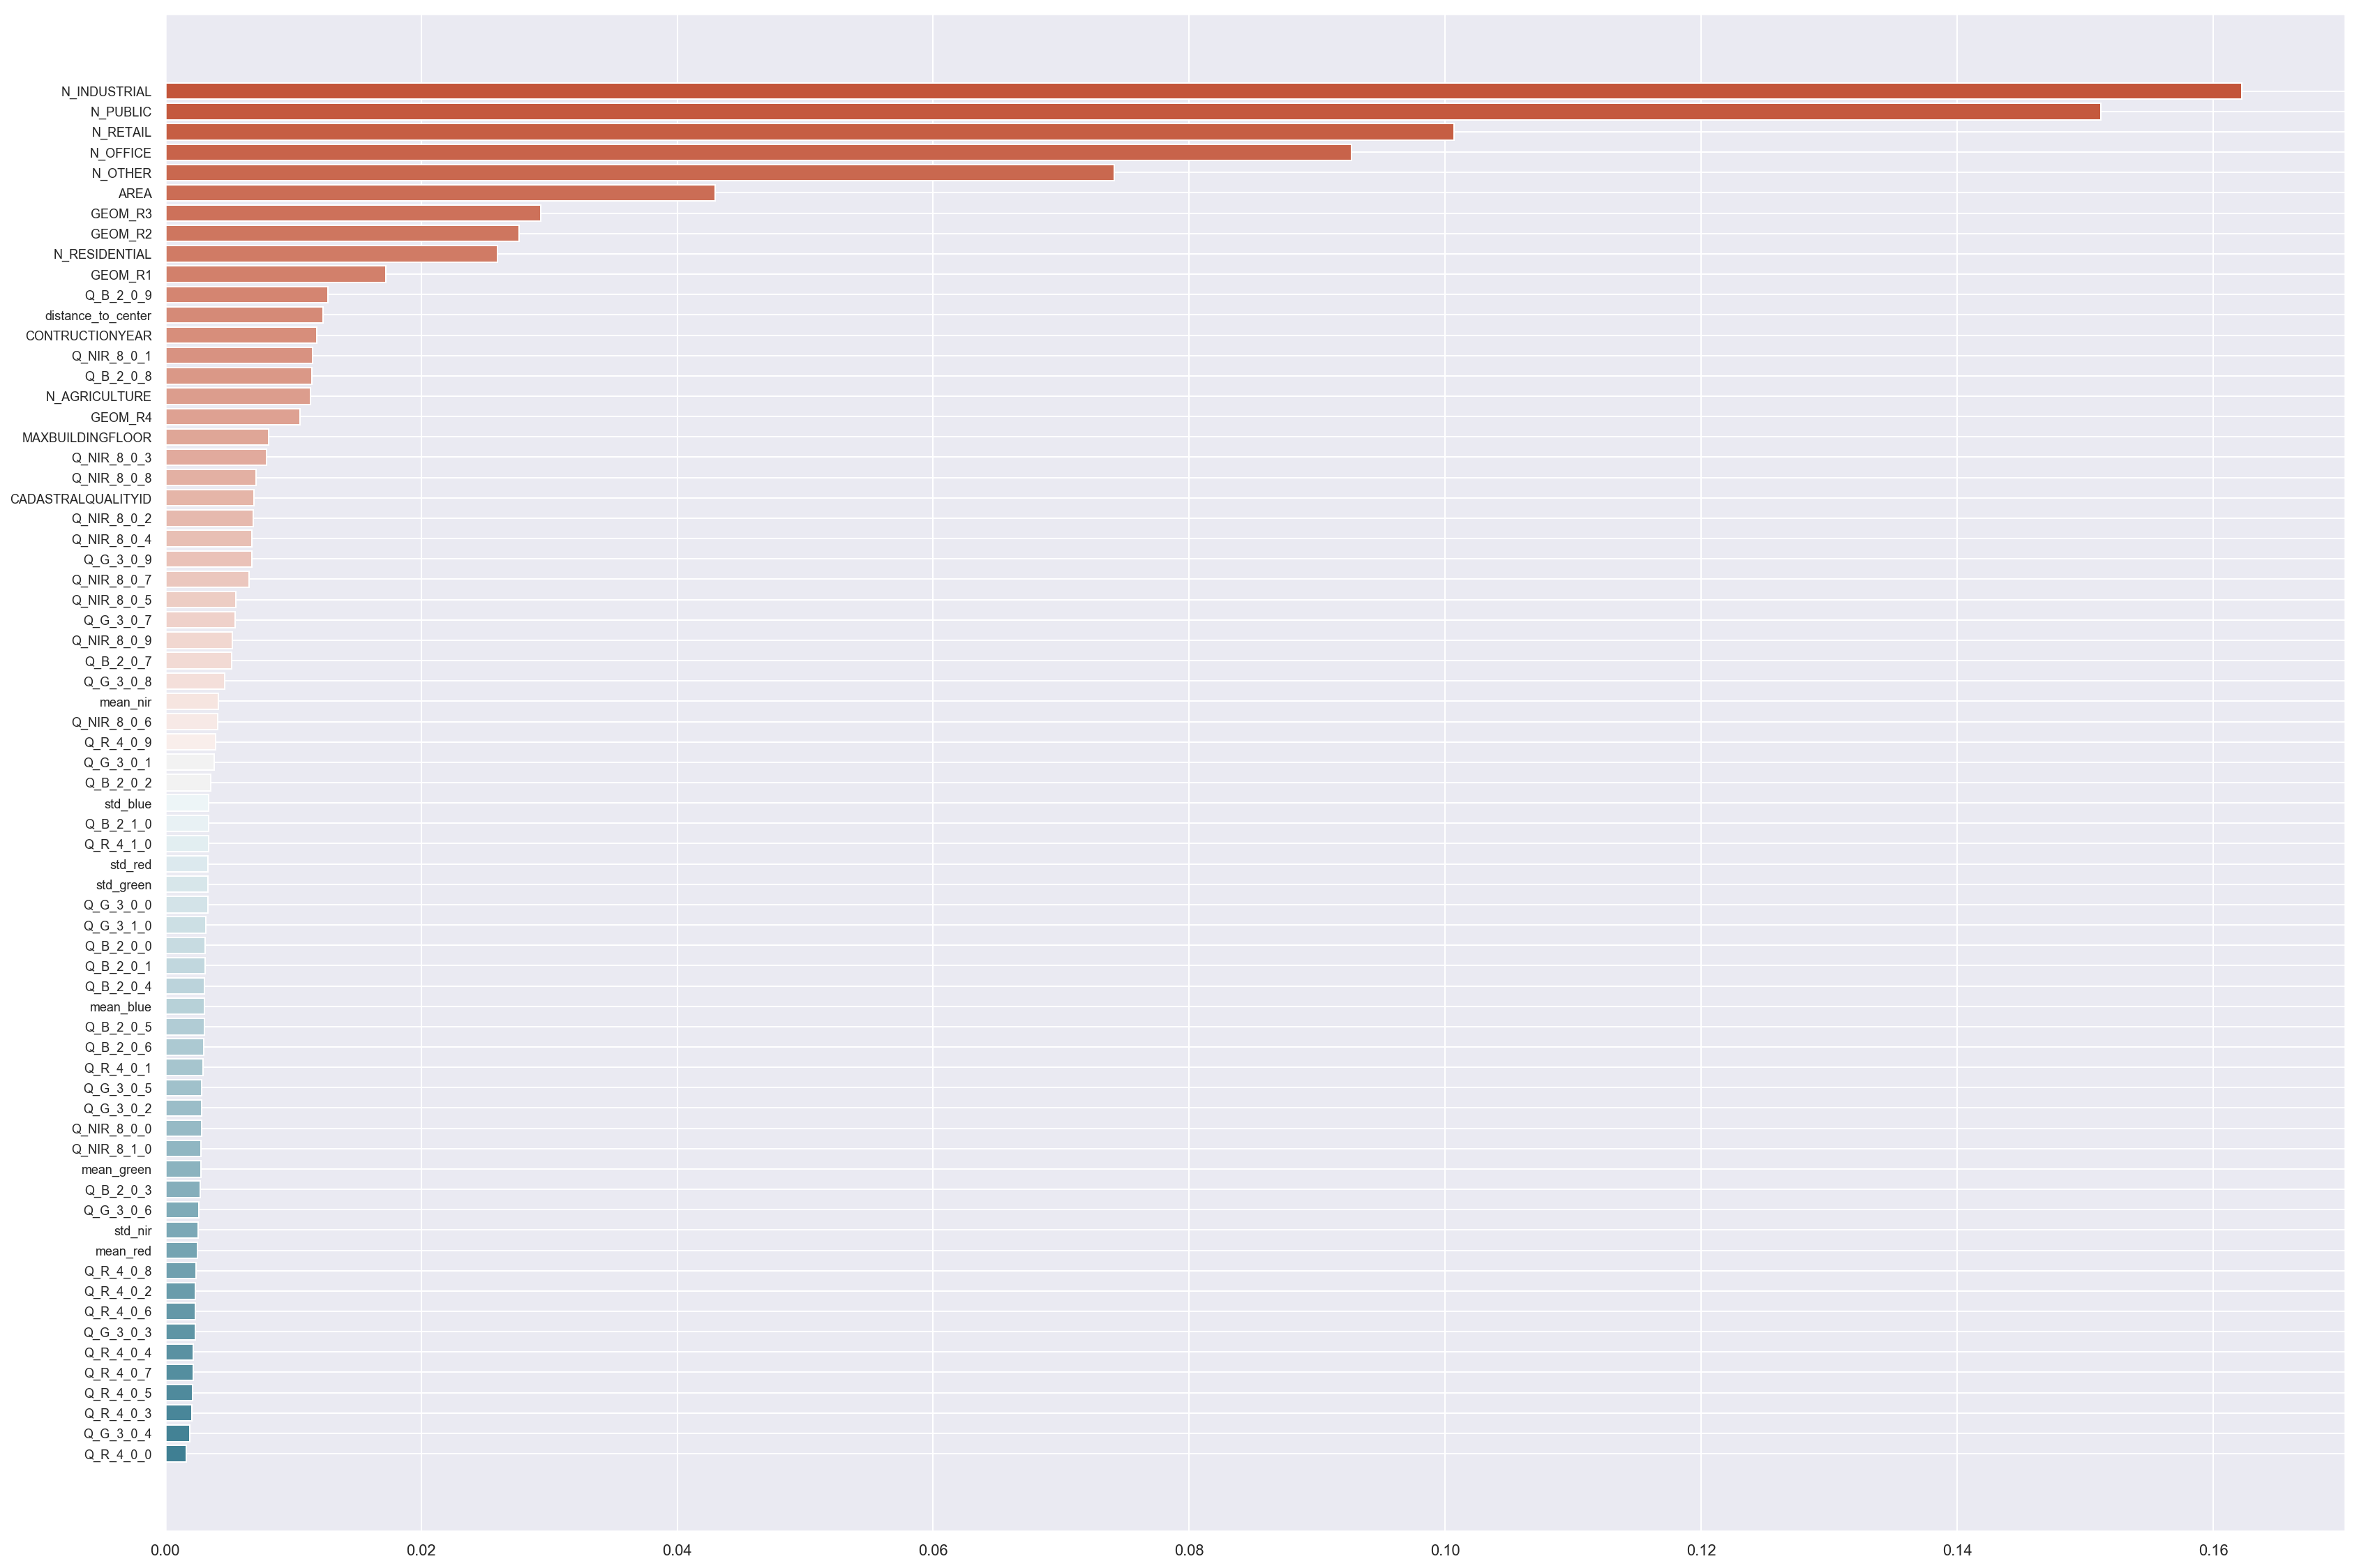

In [117]:
importances = model_multilabel['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_aux_without_outliers.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=len(importances)),align='center')
plt.yticks(range(df_aux_without_outliers.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [118]:
import pickle
pickle.dump(model_multilabel, open('multilabel_rfc_CCG.model', 'wb'))

---

# Validacion


In [123]:
def estimate(df):
    def process_cadastral_quality(df):
        dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
        df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)
        return df

    def process_max_building_floor(df):
        df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
        return df
    
    def calculate_distance_to_center(df):
        def distance(p0, p1):
            return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
        center_x = df['X'].sum()/len(df['X'])
        center_y = df['Y'].sum()/len(df['Y'])
        df['distance_to_center'] = df.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)
        df['distance_to_center'] = df['distance_to_center'] / df['distance_to_center'].max() #Normalizamos 0,1
        return df
    
    def calculate_context_class(df):
        neigh = pickle.load(open('knn_CCG.model', 'rb'))
        predict = neigh.predict_proba(df[['X', 'Y']])
        aux = pd.DataFrame(predict*5, columns=[ 'N_'+c for c in neigh.classes_ ], index=df.index)
        df = df.merge(aux, on='ID', how='inner') 
        df.drop(columns=['X', 'Y'], inplace=True)
        return df
    
    
    def calculate_colors_value(df):
        df['mean_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].mean(axis=1)
        df['mean_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].mean(axis=1)
        df['mean_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].mean(axis=1)
        df['mean_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].mean(axis=1)

        #df['max_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].max(axis=1)
        #df['max_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].max(axis=1)
        #df['max_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].max(axis=1)
        #df['max_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].max(axis=1)

        #df['min_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].min(axis=1)
        #df['min_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].min(axis=1)
        #df['min_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].min(axis=1)
        #df['min_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].min(axis=1)

        df['std_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].std(axis=1)
        df['std_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].std(axis=1)
        df['std_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].std(axis=1)
        df['std_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].std(axis=1)
        #df.drop(columns=df.columns[0:44], inplace=True)
        return df
    
    #process_cadastral_quality(df)
    process_max_building_floor(df)
    calculate_distance_to_center(df)
    df = calculate_context_class(df)
    df = calculate_colors_value(df)
    
    X = df.copy()

    #Cargamos el modelo y predecimos
    model_bin = pickle.load(open('binary_xgboost_CCG.model', 'rb'))
    y_pred = model_bin.predict(X)
    
    list_ids_no_residential = X[y_pred==0].index.tolist()
    y_resident = pd.Series(index=X[y_pred==1].index, data='RESIDENTIAL')
    df_no_resident = df[df.index.isin(list_ids_no_residential)]
    
    #Modelo final
    X_val = df_no_resident.copy()
    model_multi = pickle.load(open('multilabel_rfc_CCG.model', 'rb'))
    y_val_pred = model_multi.predict(X_val)
    
    # Lo convertimos en serie para tener referenciado el ID
    y_no_resident = pd.Series(index=X_val.index, data=y_val_pred)
    all_data_pred = y_resident.append(y_no_resident)
    
    solution = all_data_pred[df.index].reset_index()
    plt.figure(figsize=(12,6))
    sns.countplot(all_data_pred[df.index], order=list_class_order)
    return all_data_pred[df.index]

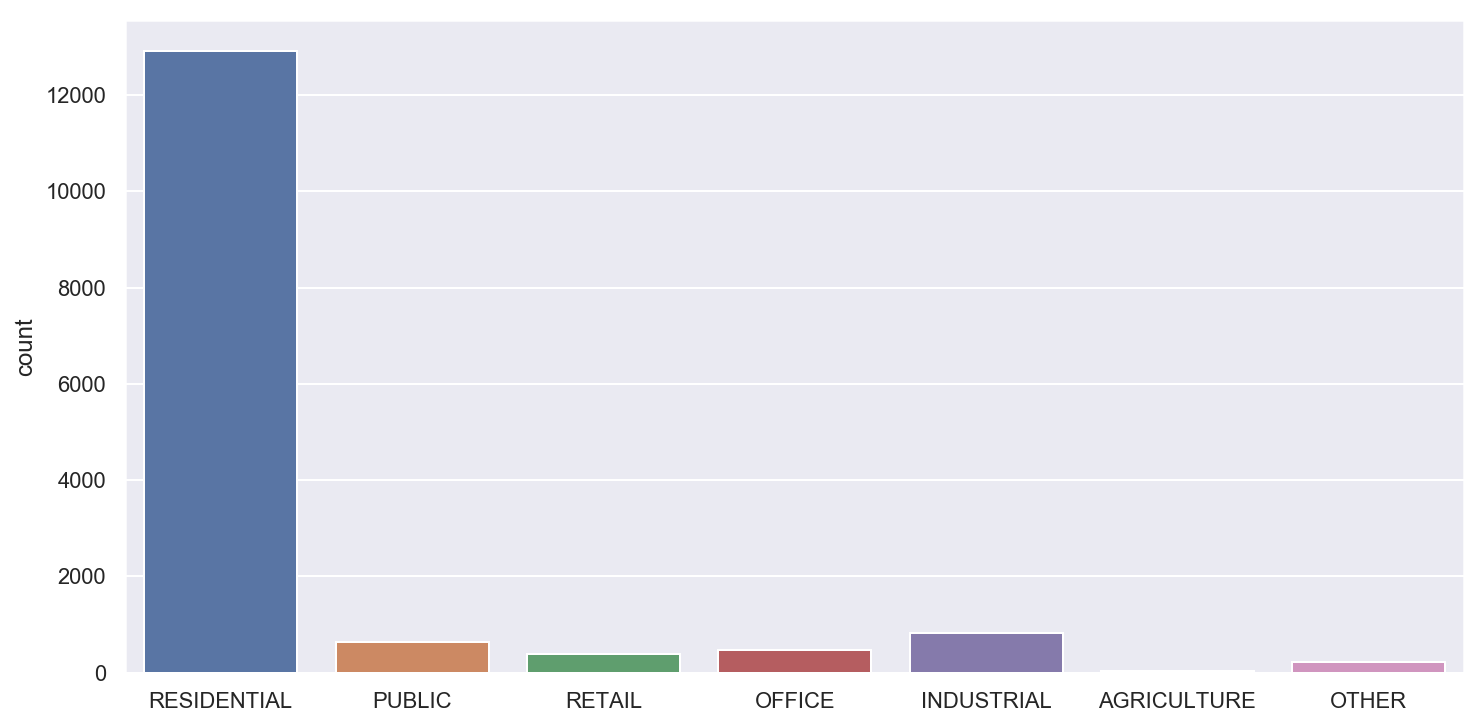

In [124]:
X = df_modelar_new.drop(columns='CLASE').copy()
y = df_modelar_new['CLASE'].copy()
sol = estimate(X)

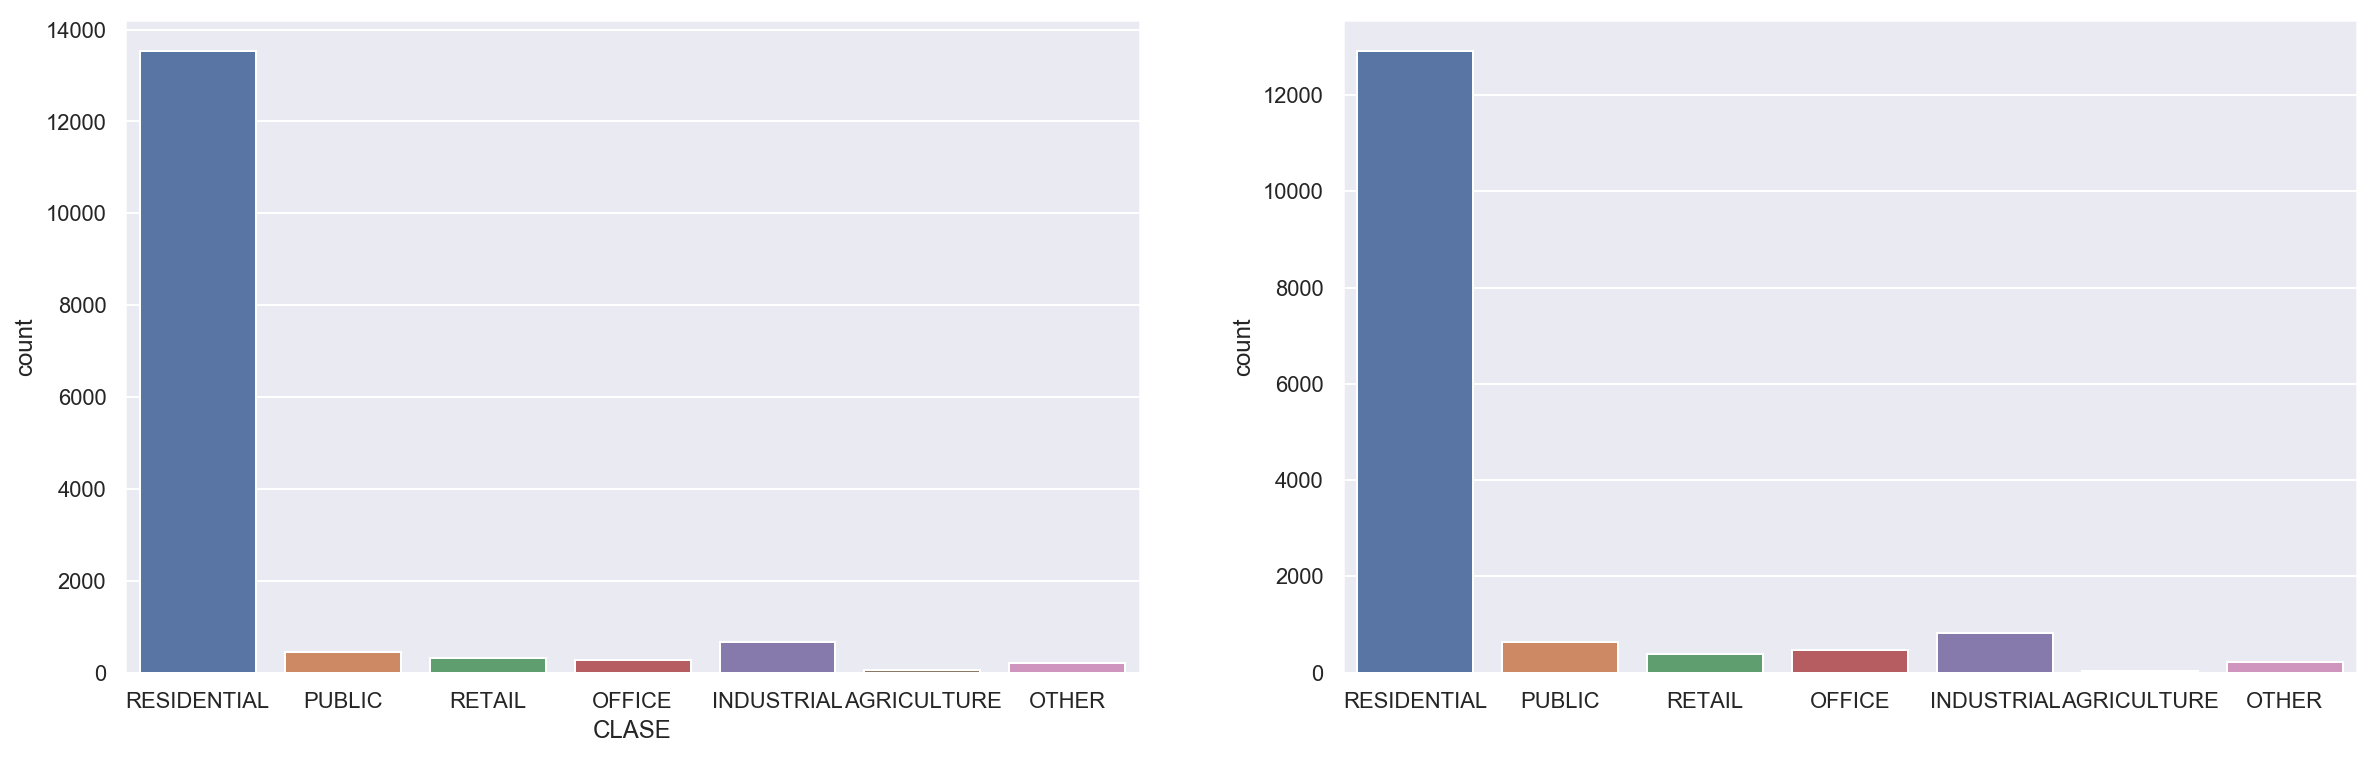

In [136]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.countplot(y, order=list_class_order, ax=ax1)
sns.countplot(sol, order=list_class_order, ax=ax2);

In [132]:
sol.value_counts()

RESIDENTIAL    12908
INDUSTRIAL       828
PUBLIC           630
OFFICE           475
RETAIL           388
OTHER            222
AGRICULTURE       31
dtype: int64

In [133]:
accuracy_score(y, sol)

0.8141712956982302